# Forecasting Bike Demand in NYC: A Time Series Approach

Bike rental systems like CitiBike are crucial parts of public transportation. Understanding and predicting how demand changes over time can help allocate bikes efficiently, reduce shortages, and improve user satisfaction.

In this Jupyter Notebook, I will explore five years of CitiBike usage data in New York City, along side weather data that was independently collected. The main objective is it build a forecasting model that can predict future bike demand and uncovering key patterns and behaviors between weather and CitiBike usage in the data as well as within the bike data itself

This notebook walks through the full analysis pipeline:
- Exploring temporal trends (hourly, daily, weekly patterns)
- Investigating differences between weekends and weekdays
- Uncovering seasonal trends though various seasonal plots
- Performing seasonal decomposition and anomaly detection
- Analyzing correlations with weather
- Building a forecasting model to predict future demand (SARIMAX, Multivariate MLP, LSTM)
- And finally, recursive forecasting with the best model

*The csv file used was extracted and formatted separate from this notebook for both weather data and Citibike usage data

## Dataset Definition

Key Variables

1. time: date and time (shown hourly) from the dates of 2020 January 1st -> 2025 April 30th
2. ride_count: Total number of CitiBike users who have rented a bike with a certain hour
3. avg_ride_duration_min: Average duration a bike was rented out in minutes
4. temperature_2m: Average temperature in New York City in degrees celcius
5. relative_humidity_2m: Average humidity as a percentage
6. windspeed_10m : Average wind speed in m/s
7. precipitation: Average precipitation in mm
8. cloudcover: Average percentage of cloud cover over the city
9. rain: Average rainfall in mm
10. snowfall: Average snowfall in mm
11. snow_depth: Average snow depth in mm
12. wind direction: Average wind direction in degrees (0° = North)

#### Citibike source: https://s3.amazonaws.com/tripdata/index.html
#### Weather Source: https://open-meteo.com/

## Project Goals
1. To explore the CitiBike rental data alongside corresponding weather data, not only identifying trends and seasonality, but also uncovering deeper patterns within the rental behavior itself and examining complex relationships between bike rentals and weather conditions.
2. To utilize insights from the exploratory analysis to build and compare different forecasting models (including linear statistical and machine learning models) in order to predict future Citibike demand and determine the most effective forecasting approach 

## Research Questions

1. What are the long term trends in Citibike rental demand in New York City from 2020 to 2025
2. How does bike rental demand vary seasonally throughout the year
3. Do any anomalies exist that cannot be explained by trend and seasonality? If so what caused them?
4. Do weather factors actually affect the the bike rental demand? If not what other factors exist?
5. What models, given different input features, perform the best?
6. From answering these research question, in what ways can forecasting models be improved? (bringing in more features vs introduction more variables)

# 1. Imports

In this section, multiple libraries are imported for data loading/proccesing, visualization, statistical analysis, and machine learning modeling

### Key Imports
1. pandas, numpy: for data manipulation
2. matplotlib, seaborn: for visualization
3. statsmodels: for statistical time series modeling
4. scikit-learn: for machine learning preprocessing and evaluation metrics
5. torch: for building more complex machine learning models

In [8]:
# Basic libraries
import numpy as np
import pandas as pd
import random
from datetime import datetime
from pandas.api.types import CategoricalDtype
from pandas.tseries.offsets import Week

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Modeling
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Machine Learning
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import ParameterGrid
import optuna
import torch.nn.functional as F

# Other
from IPython.display import display
import warnings
import calendar


# 2. Loading and Viewing Data

The Original CitiBike rental data was provided as monthly CSV files, with each row corresponding to an individual rental. The raw data also included detailed information such as rental start and end times, station names, and station coordinates.

However, for the goals of this time series forecasting project, the data needed to be aggregated into an hourly format. During preproccessing (done outside of this notebook), the data was transformed to include two key columns:
1. ride_count: total number of bike rentals per hour
2. avg_ride_duration_min: average duration of rentals (in minutes) per hour

In addition, weather daa was obtained using the Open_Meteo free API, based on the latitude and longitude of New York City (specifical Central Park). This provided hourly weather variables such as temperature, humidity, etc. 

### Initial Data Checks

After merging the Citibke and weather datasets, I conducted initial checks to confirm the consistency of the data
- Displayed the first few rows of the combined dataset
- Checked for missing values in each column

In [9]:
file_path = 'final_data/citibike_weather_merged_2020_to_2025.csv'
citibike_df = pd.read_csv(file_path)

citibike_df

time  ride_count  avg_ride_duration_min  temperature_2m  \
0      2020-01-01 00:00:00         512              75.237051             4.3   
1      2020-01-01 01:00:00         639              37.530957             2.9   
2      2020-01-01 02:00:00         484              19.216176             1.8   
3      2020-01-01 03:00:00         261              20.324312             1.4   
4      2020-01-01 04:00:00         137              11.664175             0.9   
...                    ...         ...                    ...             ...   
46642  2025-04-30 19:00:00       12664              12.744457            20.3   
46643  2025-04-30 20:00:00        8638              12.233272            18.9   
46644  2025-04-30 21:00:00        6488              11.936519            18.9   
46645  2025-04-30 22:00:00        4835              11.797297            17.7   
46646  2025-04-30 23:00:00        2668               9.638460            16.4   

       relative_humidity_2m  windspeed_10m  precipitation  cloudcover  rain  \
0                        75           17.7            0.0          40   0.0   
1                        75           18.4            0.0           2   0.0   
2                        77           17.3            0.0           0   0.0   
3                        78           17.3            0.0           0   0.0   
4                        76           18.7            0.0          25   0.0   
...                     ...            ...            ...         ...   ...   
46642                    24           12.6            0.0          86   0.0   
46643                    28           11.3            0.0          96   0.0   
46644                    25            9.8            0.0          78   0.0   
46645                    30           10.3            0.0          93   0.0   
46646                    35            9.7            0.0          94   0.0   

       snowfall  snow_depth  winddirection_10m  
0           0.0         0.0                274  
1           0.0         0.0                272  
2           0.0         0.0                270  
3           0.0         0.0                269  
4           0.0         0.0                270  
...         ...         ...                ...  
46642       0.0         0.0                324  
46643       0.0         0.0                323  
46644       0.0         0.0                320  
46645       0.0         0.0                329  
46646       0.0         0.0                338  

[46647 rows x 12 columns]

In [10]:
citibike_df.isnull().sum()

time                     0
ride_count               0
avg_ride_duration_min    0
temperature_2m           0
relative_humidity_2m     0
windspeed_10m            0
precipitation            0
cloudcover               0
rain                     0
snowfall                 0
snow_depth               0
winddirection_10m        0
dtype: int64

### Observations

1. The dataframe displayed correctly, showing the expected hourl aggregation of Citibike rental variables and weather features
2. No missing values were found in any of the columns, which ensures that the dataset was complete and ready for further exploratory analysis

# 3. Plotting Citibike Demand & Descriptive Statistics

The first step into exploratory analysis was to plot the aggregated Citibike and weather data as a time plot using the column ride_count. This step was executed to get an initial understanding of what the data visually looks like that can tell us about its trend or seasonality. Aggregating the data further into higher level granularity or using a rolling mean was also implemented if the data was noisy or hard to analyze.

Then, standard descriptive statistics such as total datapoints, mean, standard deviation, min/max, were also analyzed to get a better prespective of the data.

And finally, to make sure that the data is not stationary and has features that can be extracted, a ADF test was implemented for further confirmation (rather than just visual)

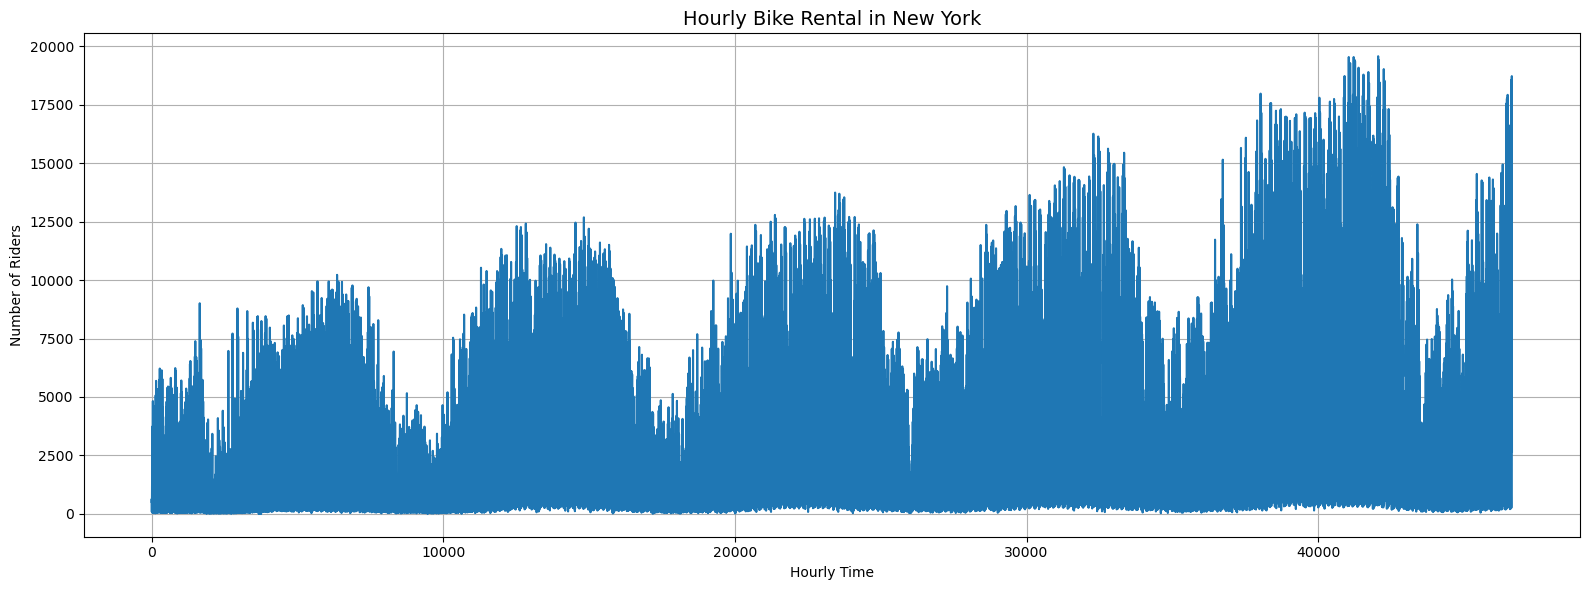

In [11]:
plt.figure(figsize=(16,6))
cbp = citibike_df['ride_count'].plot()
cbp.set_title('Hourly Bike Rental in New York', fontsize=14)
cbp.set_xlabel('Hourly Time')
cbp.set_ylabel('Number of Riders')
cbp.grid(True)

plt.tight_layout()
plt.show()

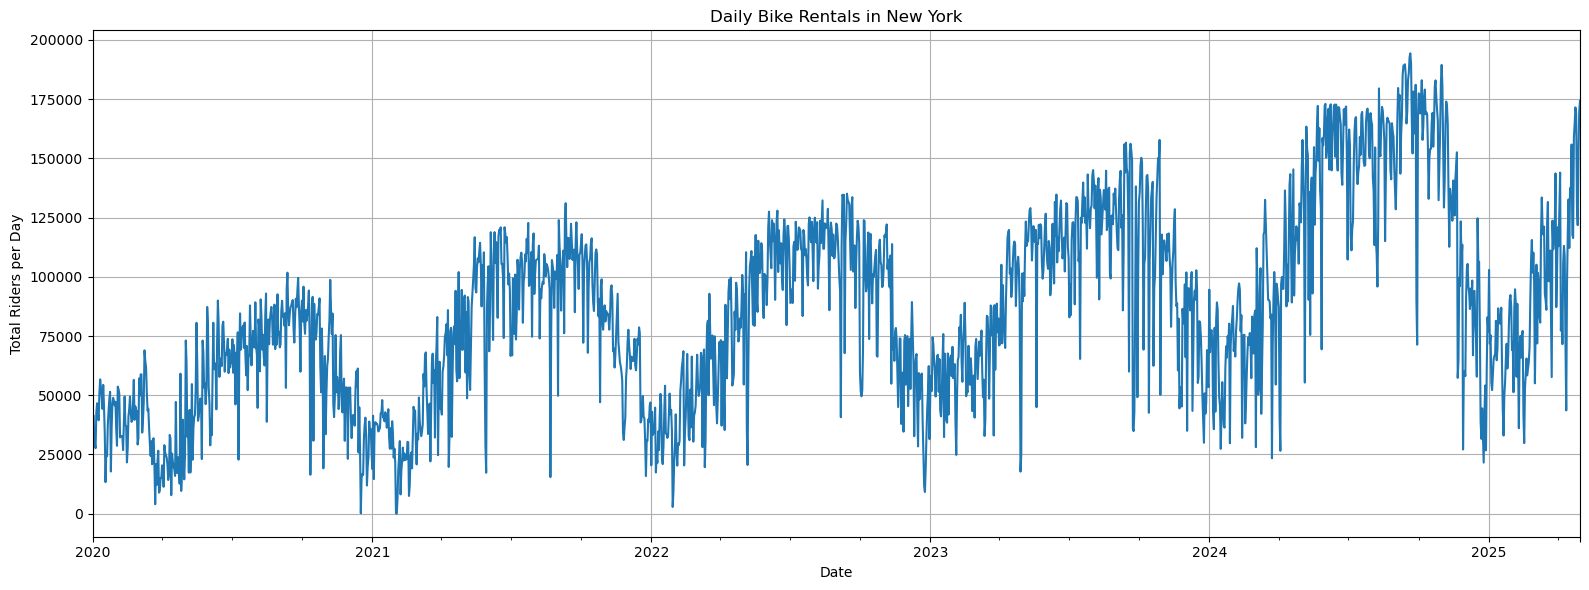

In [12]:
citibike_df['time'] = pd.to_datetime(citibike_df['time'])
citibike_df.set_index('time', inplace = True)

daily_avg = citibike_df['ride_count'].resample('D').sum()

plt.figure(figsize=(16, 6))
daily_avg.plot()
plt.title('Daily Bike Rentals in New York')
plt.xlabel('Date')
plt.ylabel('Total Riders per Day')
plt.grid(True)
plt.tight_layout()
plt.show()

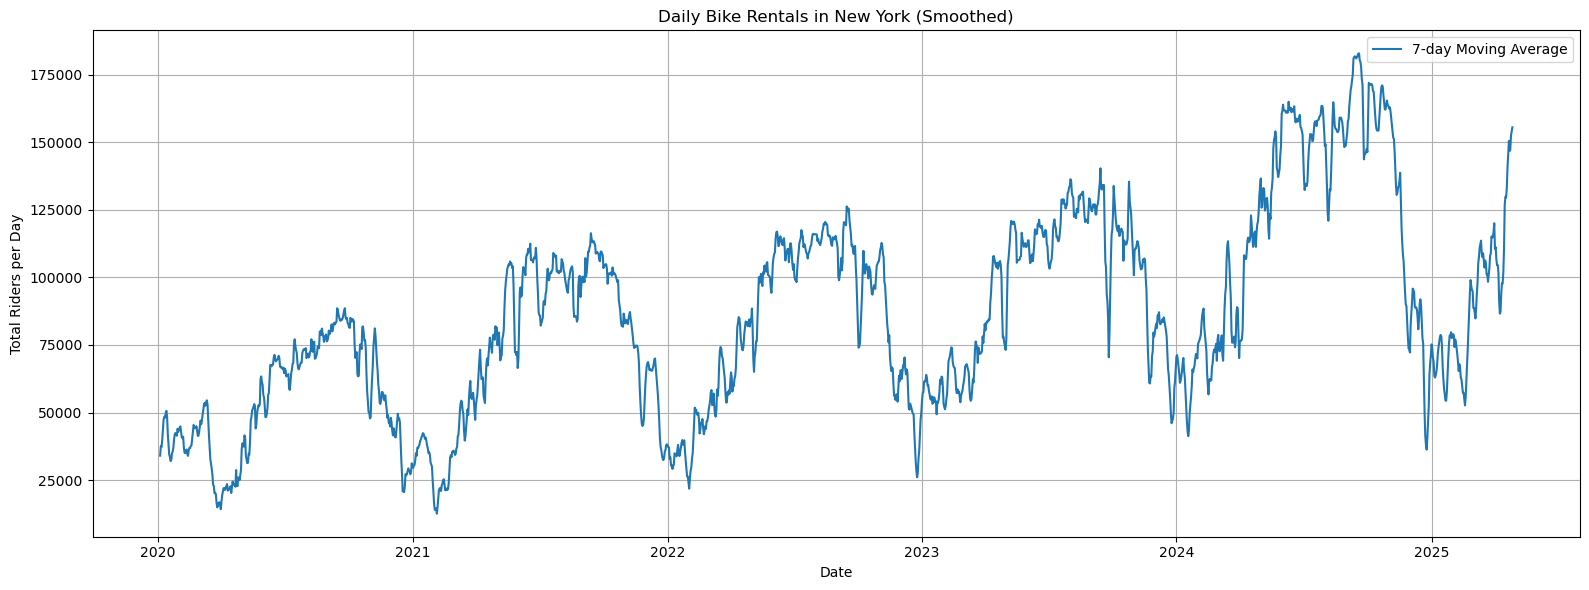

In [13]:
# 7-day centered moving average
daily_avg_smoothed = daily_avg.rolling(window=7, center=True).mean()

# Plot both raw and smoothed
plt.figure(figsize=(16, 6))
plt.plot(daily_avg_smoothed.index, daily_avg_smoothed, label='7-day Moving Average')
plt.title('Daily Bike Rentals in New York (Smoothed)')
plt.xlabel('Date')
plt.ylabel('Total Riders per Day')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
y = citibike_df['ride_count'].resample('D').sum().describe()
print(y)

count      1947.000000
mean      85848.652286
std       40198.413195
min           0.000000
25%       54521.000000
50%       83782.000000
75%      113562.500000
max      194315.000000
Name: ride_count, dtype: float64


In [15]:
result = adfuller(y.dropna())
print(f'p-value: {result[1]:.4f}')

p-value: 0.9988


### Observations

- The original hourly aggregated data, when plotted, resulted in a fairly noisy time plot, making it difficult to infer trends or seasonality. Therefore, data was aggregated to daily totals and applying a 7 day moving average which produced a clearer view
- The smoothed time series showed an overall upward trend in demand with noticable dips around the start and end of each year
- In terms of descriptive statistics, the mean was around 86,000 with the standard deviation being around 40,000, which shows that there is significant variability in demand over the entire dataset (46,000 to 126,000)
- The ADF test resulted in a p value of 0.9988, indicating that the data is not stationary and does have features that can be extracted.

With these insights, we proceed to breaking down this infered trend further to gain even more understanding

# 4. Weekday vs Weekend Analysis

With the knowledge of the previous step, average weekday vs weekend demand analysis was also conducted to understand demand from a different perspective. As weekdays include people commuting via bike and weekends include people spending their free time travelling, I wanted to visualize if there was a period of time where one was greater than the other.

More specifically, a plot for yearly comparisons as well as monthly comparisons were done to get two different perspectives
- yearly comparisons: demand differences between weekend and weekday across years -> do certain years have more weekend usage than weekday?
- monthly comparisons: demand differences between weekend and weekday across months (averaged across years) -> do certain months have more weekend usage than weekday?
  
From a more overall perspective, analysis into if the difference between the two over years and months can also be analyzed

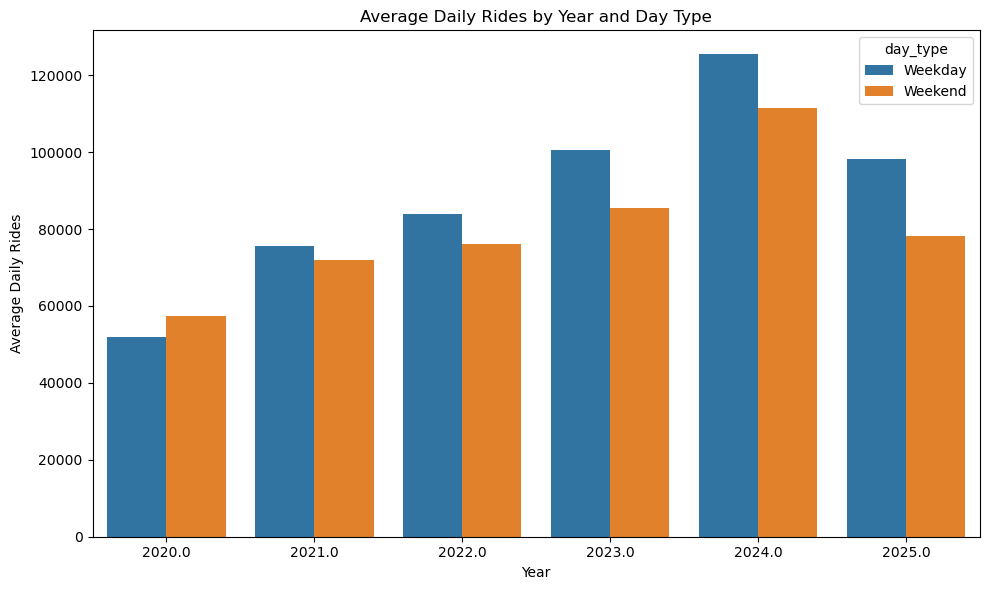

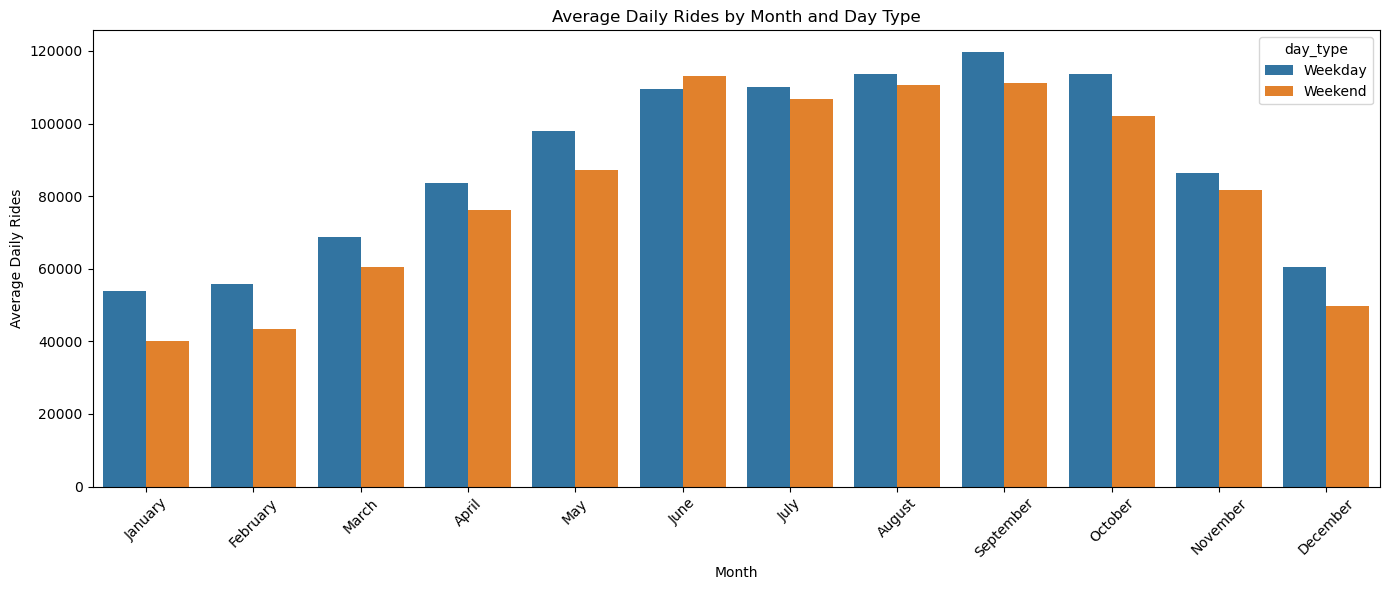

In [16]:
citibike_df['day_type'] = citibike_df.index.dayofweek.map(lambda x: 'Weekend' if x >= 5 else 'Weekday')
citibike_df['month'] = citibike_df.index.month_name()
citibike_df['year'] = citibike_df.index.year  # NEW: add year column

daily = citibike_df['ride_count'].resample('D').sum().to_frame()

daily['day_type'] = citibike_df['day_type'].resample('D').first()
daily['month'] = citibike_df['month'].resample('D').first()
daily['year'] = citibike_df['year'].resample('D').first()  # NEW: join year info

monthly_avg = (
    daily
    .groupby(['month', 'day_type'])['ride_count']
    .mean()
    .reset_index()
)

month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_avg['month'] = monthly_avg['month'].astype(CategoricalDtype(month_order, ordered=True))
monthly_avg = monthly_avg.sort_values('month')

yearly_avg = (
    daily
    .groupby(['year', 'day_type'])['ride_count']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(data=yearly_avg, x='year', y='ride_count', hue='day_type')
plt.title('Average Daily Rides by Year and Day Type')
plt.ylabel('Average Daily Rides')
plt.xlabel('Year')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(data=monthly_avg, x='month', y='ride_count', hue='day_type')
plt.title('Average Daily Rides by Month and Day Type')
plt.ylabel('Average Daily Rides')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Observations

Weekend vs Weekday by year
- 2020 was the only year where weekend usage was higher than weekday. This possibly suggests that because 2020 was one of the COVID lockdown years, during weekdays, people were staying at home working while during the weekends, people were travelling outdoors slight more. But overall there is still low demand compared to the other years due to the lockdown
- from 2021 onwards there was a steady upward trend overall but also increasing diffrence between weekday rides vs weekend rides. This possibly suggests that as COVID restrictions started to be less strict, more people travelled to their respective jobs or other activities.
- It is also important to keep in mind that the overall average demand for 2025 has gone down due to the fact that data only until April was collected for that specific year.

Weekend vs Weekday by month
- From the analysis of the entire datasets time plot, the monthly weekend vs weekday follows a similar seasonality where demand peaks during the middle of the year and crashes at the end of the year and beginning
- Differences between weekend and weekday demand are greater during late and early months of the year where as they start to converge as the months go on. For the month of June, weekend demand exceeds weekday demand
- These overall trends suggest that during the summer months where much of the population are on holiday, weekend usage significantly rises in comparison to weekday and eventually takes over weekday demand (July only). As the months move on and the population return to their jobs/school, the difference once again increases.

These results can be beneficial as features for the model as they would be able to have the knowledge that certain months or years have varying weekend and weekday usages. 

# 5. Seasonal Plots Analysis

To better understand the seasonal patterns that can be seen in bike rental data, several types of seasonal plots were created. While ealier analysis did reveal trends, these plots pinpoint focus specifically on patterns within a year

Plots Used
1. Monthly Line Plot: Shows total bike demand for each year across different years, making it easy to compare seasonal trends year by year
2. Polar Plot: Provides a circular view of average monthly bike demand to better visualize patterns that could not be seen in a standard seasonal plot
3. Seasonal Subseries Plot: Breaks down the time series by both, highlighting month specific patterns, variations, and the mean

Analyzing these seasonal effects gives us more insights into how the data is behaving and can give knowledge into choosing the right features to be the inputs for a model. Specifically for models such as SARIMA, seasonal patterns are often beneficial as it can benefit from picking up periodicity. 

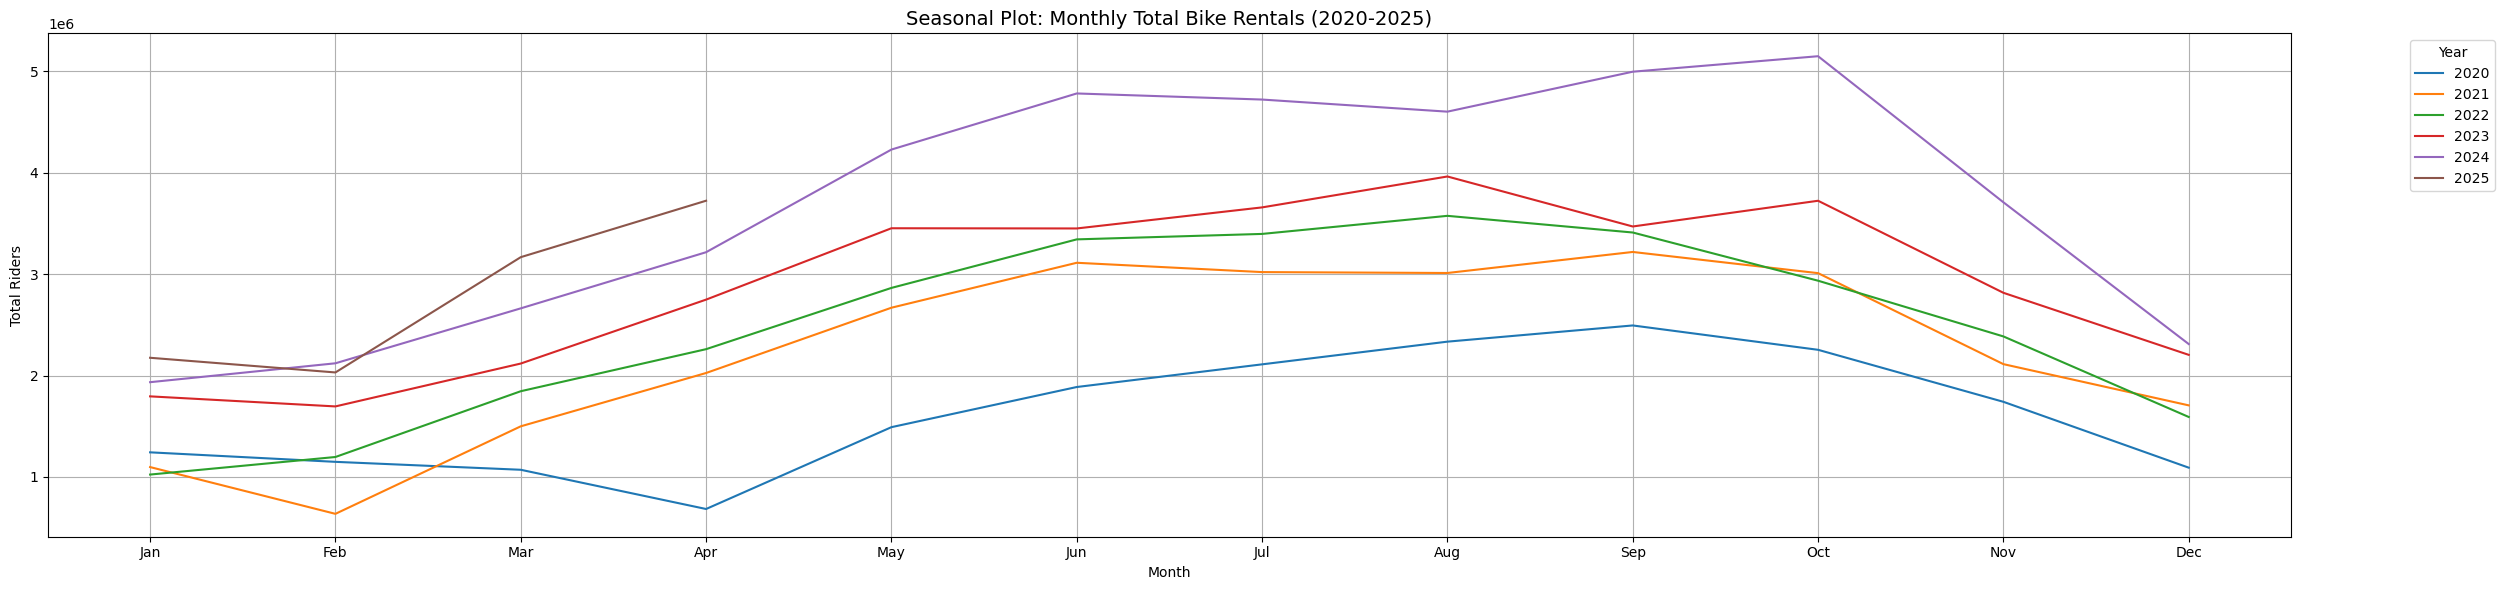

In [17]:
citibike_df.index = pd.to_datetime(citibike_df.index)

filtered_df = citibike_df[(citibike_df.index.year >= 2020) & (citibike_df.index.year <= 2025)].copy()

filtered_df['Year'] = filtered_df.index.year
filtered_df['Month'] = filtered_df.index.month

month_totals = filtered_df.groupby(['Year', 'Month'])['ride_count'].sum().unstack(0)
month_totals.plot(figsize=(25,6))

plt.title('Seasonal Plot: Monthly Total Bike Rentals (2020-2025)', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Total Riders')
plt.xticks(ticks=range(1, 13), labels=[calendar.month_abbr[m] for m in range(1, 13)])
plt.grid(True)
plt.legend(title='Year', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

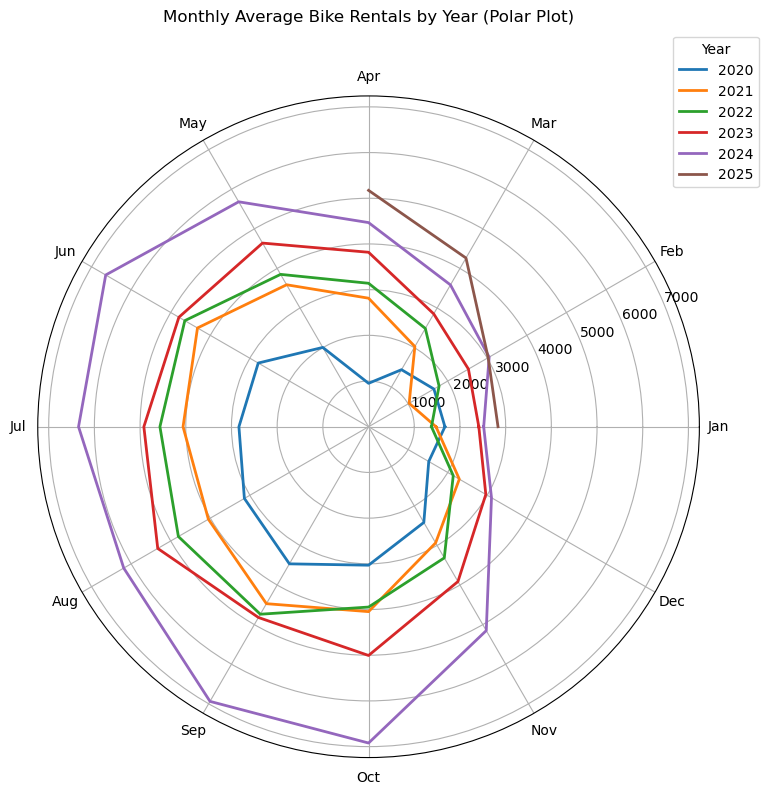

In [18]:
month_by_year = citibike_df['ride_count'].groupby([citibike_df.index.year, citibike_df.index.month]).mean()

years = month_by_year.index.get_level_values(0).unique()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, polar = True)

angles = np.linspace(0, 2 * np.pi, 13)

for year in years:
    monthly_values = month_by_year.loc[year]
    monthly_values = monthly_values.reindex(range(1, 13), fill_value=np.nan)  # fill missing months with NaN
    values = np.append(monthly_values.values, monthly_values.values[0])  # close the loop
    ax.plot(angles, values, label=str(year), linewidth=2)

ax.set_xticks(angles[:-1])  
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])       

ax.grid(True)

ax.legend(title='Year', loc='upper right', bbox_to_anchor=(1.1,1.1))
ax.set_title('Monthly Average Bike Rentals by Year (Polar Plot)', y=1.1)

plt.tight_layout()
plt.show()

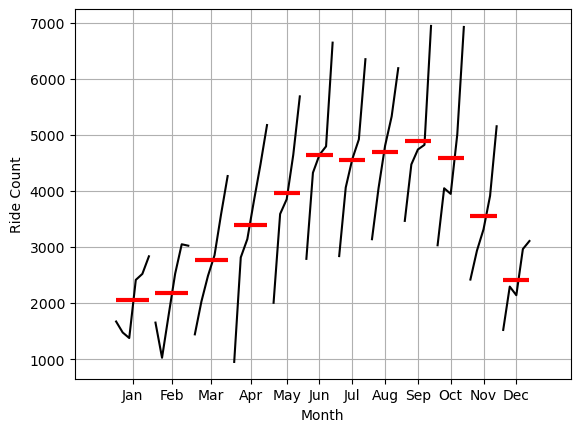

In [19]:
monthly_count = citibike_df['ride_count'].resample('MS').mean()

fig, ax = plt.subplots()
sm.graphics.tsa.month_plot(monthly_count, ax=ax)
ax.set(xlabel='Month', ylabel='Ride Count')
ax.grid()

### Observations

Monthly Line Plot
- Across all years, the patterns for seasonality seems to be the same, as mentioned before. Demand rises consistently for most years from February onwards and peak between August and September. This suggests that holiday seasons (New Years, Christmas, Summer Holidays) have significant impacts on how many people are renting bikes across a year. 2020 stands out as an outlier for this plot, consistent with COVID impacts while years after 2020 show increases in demand year by year.

Polar Plot
- Similar to the monthly line plot, the cyclical perspective of this plot suggests even stronger proof that late and early months in the year have low demand and summer months have high demand. And this trend follows all years shown by the smooth consistent shape of the plot.

Seasonal Subseries Plot
- Once again this type of plot provides proof that there is strong seasonality between the low demand of late and early months of the year versus the summer. Furthermore the variability of bike rentals is seen higher for the months between March and April where as it stays compact between July and August. This type of visualization suggets that while seasonality is strong, there is some year to year variation within months.

Now that seasonality has been clearly understood, the next logical step is to apply seasonal decomposition to analyze where there are any factors outside trend and seasonality that is affecting bike demand. 

# 6. STL Decomposition & Anomaly Detection

To better understand the underlying components of the data, I then applied Seasonal Trend decomposition using Loess (STL). STL is a flexible method that gives data, decomposes it into three different parts
1. Trend: The long term increase or decrease of the data
2. Seasonality: Repeating short term cycles (eg. yearly seasonality)
3. Residuals: Features or components of the data that could not be captured by the trend or seasonality

Decomposing the data not only helps isolate and analyze trend, seasonality, and residuals separately, it also provides clear insights into the patterns that produce the Citibike demand as shown in part 1. 

Beyong STL decomposition, anomaly detection was implemented by analyzing the residuals. 
- A threshold of ±3 standard deviations from the residuals was also set to detect any days with unsual spikes or drops.
- After visualizing the the residuals against the threshold and identifying the anomalies, they were plotted into the original data to get an understanding of where these anomalies were occuring in time.
- The next logical step was to plot the bike demand at these anomalies to analyze if any of those days showed un-natural spikes or dips. Therefore, by taking the extreme spikes or dips, they were compared against real world events to infer relationships between the two. 

Detecting these anomalies are also important for recognizing outliers that could affect forecasting models but can also show us real world events that may have caused these outliers. 

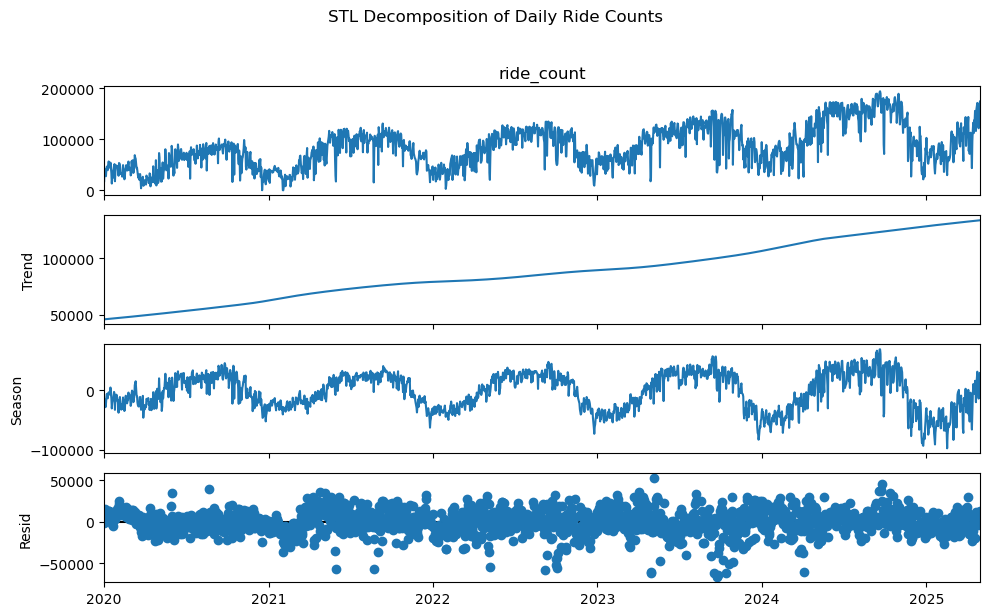

In [20]:
daily_ride_counts = citibike_df['ride_count'].resample('D').sum()
stl = STL(daily_ride_counts, period=365)
result = stl.fit()

fig = result.plot()
fig.set_size_inches(10, 6) 
plt.suptitle("STL Decomposition of Daily Ride Counts", y=1.02)
plt.tight_layout()
plt.show()

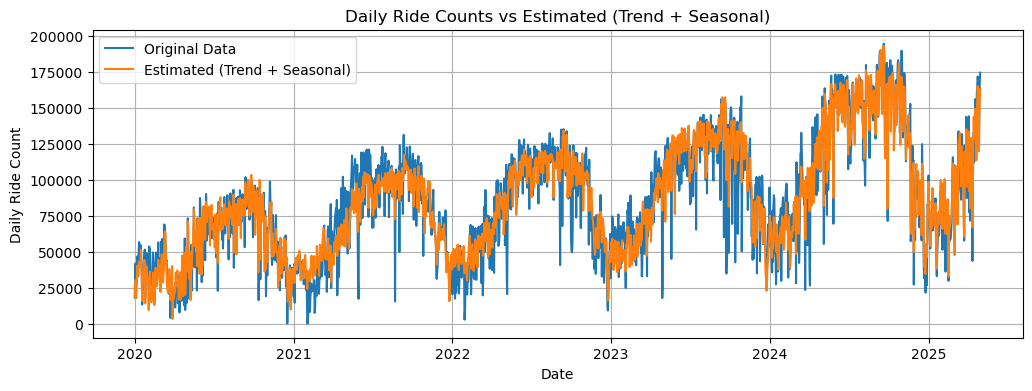

In [21]:
trend = result.trend
seasonal = result.seasonal
estimated = trend + seasonal
residual = result.resid
plt.figure(figsize=(12, 4))
plt.plot(daily_ride_counts, label='Original Data')
plt.plot(estimated, label='Estimated (Trend + Seasonal)')
plt.legend()
plt.title("Daily Ride Counts vs Estimated (Trend + Seasonal)")
plt.xlabel("Date")
plt.ylabel("Daily Ride Count")
plt.grid(True)
plt.show()

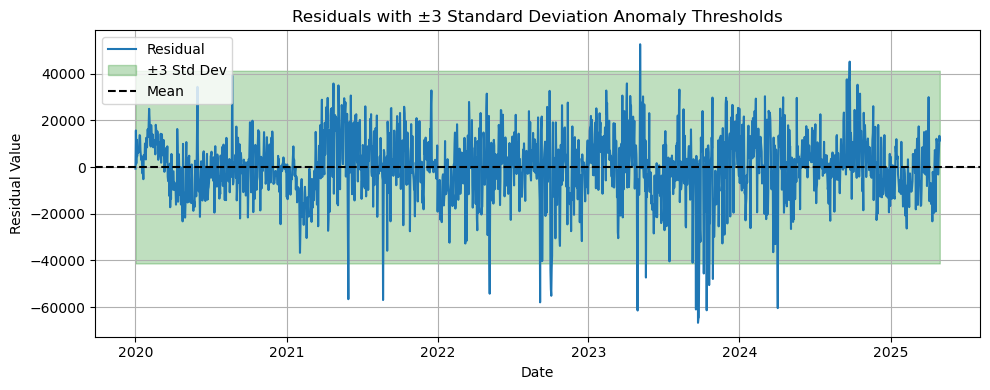

In [22]:
residual = result.resid
residual_mean = residual.mean()
residual_std = residual.std()

lower = residual_mean - 3*residual_std
upper = residual_mean + 3*residual_std

plt.figure(figsize=(10,4))
plt.plot(residual.index, residual, label='Residual')

plt.fill_between(residual.index, lower, upper, color='green', alpha=0.25, label='±3 Std Dev')
plt.axhline(residual_mean, color='black', linestyle='--', label='Mean')

plt.title("Residuals with ±3 Standard Deviation Anomaly Thresholds")
plt.xlabel("Date")
plt.ylabel("Residual Value")
plt.legend(loc="upper left")
plt.grid()
plt.tight_layout()
plt.show()

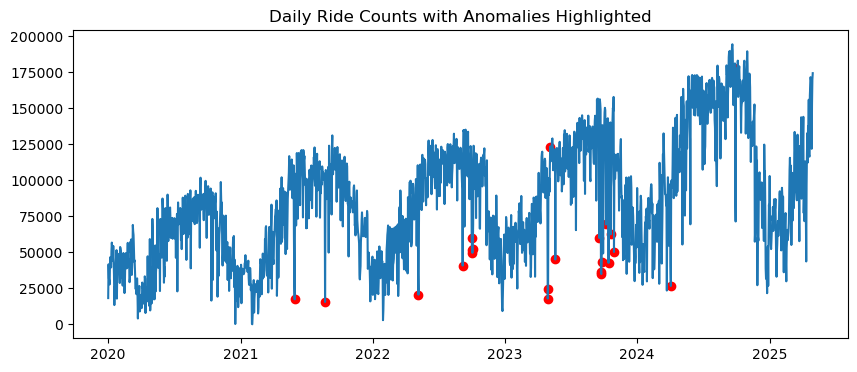

In [23]:
anomalies = daily_ride_counts[(residual < lower) | (residual > upper)]

plt.figure(figsize=(10,4))
plt.plot(daily_ride_counts, label='Daily Ride Counts')

plt.scatter(anomalies.index, anomalies, color='red')
plt.title("Daily Ride Counts with Anomalies Highlighted")
plt.show()

In [24]:
display(anomalies) 

time
2021-05-30     17290
2021-08-22     15466
2022-05-07     20557
2022-09-06     40735
2022-10-01     59778
2022-10-02     51635
2022-10-03     49566
2022-10-04     51994
2023-04-29     17757
2023-04-30     24723
2023-05-06    123342
2023-05-20     44962
2023-09-18     59963
2023-09-23     36069
2023-09-24     34864
2023-09-25     43306
2023-10-07     69256
2023-10-14     42586
2023-10-20     62424
2023-10-29     50161
2024-04-03     26555
2024-09-24    178192
Name: ride_count, dtype: int64

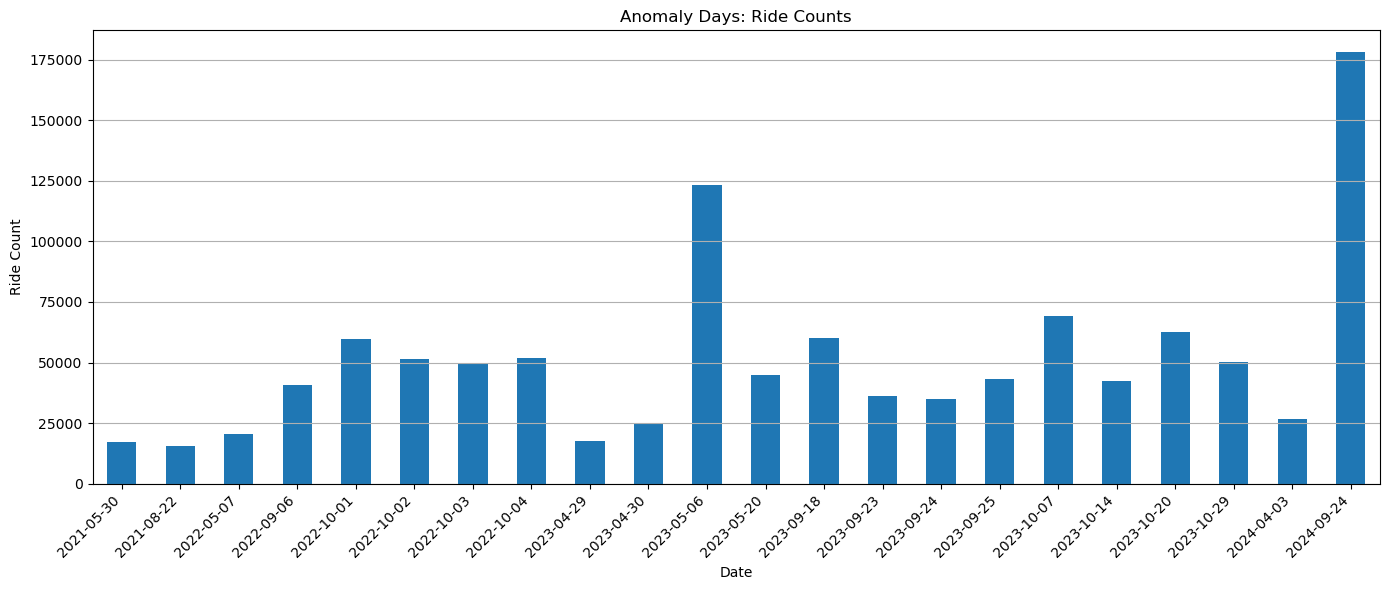

In [25]:
anomaly_counts = pd.Series({
    '2021-05-30': 17290,
    '2021-08-22': 15466,
    '2022-05-07': 20557,
    '2022-09-06': 40735,
    '2022-10-01': 59778,
    '2022-10-02': 51635,
    '2022-10-03': 49566,
    '2022-10-04': 51994,
    '2023-04-29': 17757,
    '2023-04-30': 24723,
    '2023-05-06': 123342,
    '2023-05-20': 44962,
    '2023-09-18': 59963,
    '2023-09-23': 36069,
    '2023-09-24': 34864,
    '2023-09-25': 43306,
    '2023-10-07': 69256,
    '2023-10-14': 42586,
    '2023-10-20': 62424,
    '2023-10-29': 50161,
    '2024-04-03': 26555,
    '2024-09-24': 178192
})

plt.figure(figsize=(14, 6))
anomaly_counts.sort_index().plot(kind='bar')
plt.title("Anomaly Days: Ride Counts")
plt.xlabel("Date")
plt.ylabel("Ride Count")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Observations

STL Decomposition
- The STL decomposition broke apart the original data into its trend, seasonality, and residuals where each component tells a different story
- Trend
    - The extracted trend shows a steady increase over the year increasing from about 50,000 to 130,000. This successfully proves the inference that was said in section 5 that demand was increased from 2020 to 2025
- Seasonality
    - The seasonality component also confirms the infference made before that the demand dips during the winter and increasing during the summer
- Residuals
    - From a visual perspective, the residuals seems to show no specifc specific pattern while fluctuating around zero, suggesting that the decomposition was able to capture all trend and seasonality from the original data
 
Trend + Seasonality Reconstruction
- Comparing the orignal time plot to the reconstructed time plot (trend + seasonality) shows that the decomposition was able to capture the main structure of the data quite well
- The occasional deviance from the reconstructed time plot suggests that there are anomalies, which are occurences that could not be explained by just the trend and seasonality.
- This prompted me to explore those anomalies more specifically and gage an understanding of what might possibly causing these anomalies

Anomaly Detection
- From applying a ±3 standard deviation threshold to the residual plot, several insights were gathered
    - 22 anomalies were detected, most likely corresponding to unexpected spikes or dips
    - These anomalies visualized against the original time plot shows that more often than not, unexpected real world events caused significantly more dips than spikes.
    - For example, for the anomaly on 22 August 2021, where demand seems to be significantly low, tropical storm Henri hit New York City which proves why demand was low (future work for the final version should include more info about anomalies)

Having isolated trend and seasonal components and identifying anomalies, the question of whether outside variables have any impact or correlation to the bike rental data. Therefore, the next step involves using weather data to analyze if there is similarities so that it can possibly be used for model building

# 7. Weather Data Time Plots

Understanding how weather conditions evolve over time is important because weather is a key external factor that can significantly influence bike rental demand.

To explore the weather trends during the same time period as the bike rental data, I plotted 9 different weather variables against the bike rental data (time plots)
Variables Introduced
1. Temperature (°C)
2. Humidity (%)
3. Wind Speed (m/s)
4. Precipitation (mm)
5. Cloud Cover (%)
6. Rainfall (mm)
7. Snowfall (mm)
8. Snow Depth(mm)
9. Wind Direction (°)

As trends and seasonality has already been uncovered through STL decomposition, by creating time plots for each of these weather variables, we can identify seasonal fluctuations, possible extreme weather, and long term changes that could be correlated to bike rental data through visualizing their time plots. 

Moreover, this specific exploratory analysis can help decide which features to apply to the forecasting models which can allow them to understand weather context in relation to the bike rental data

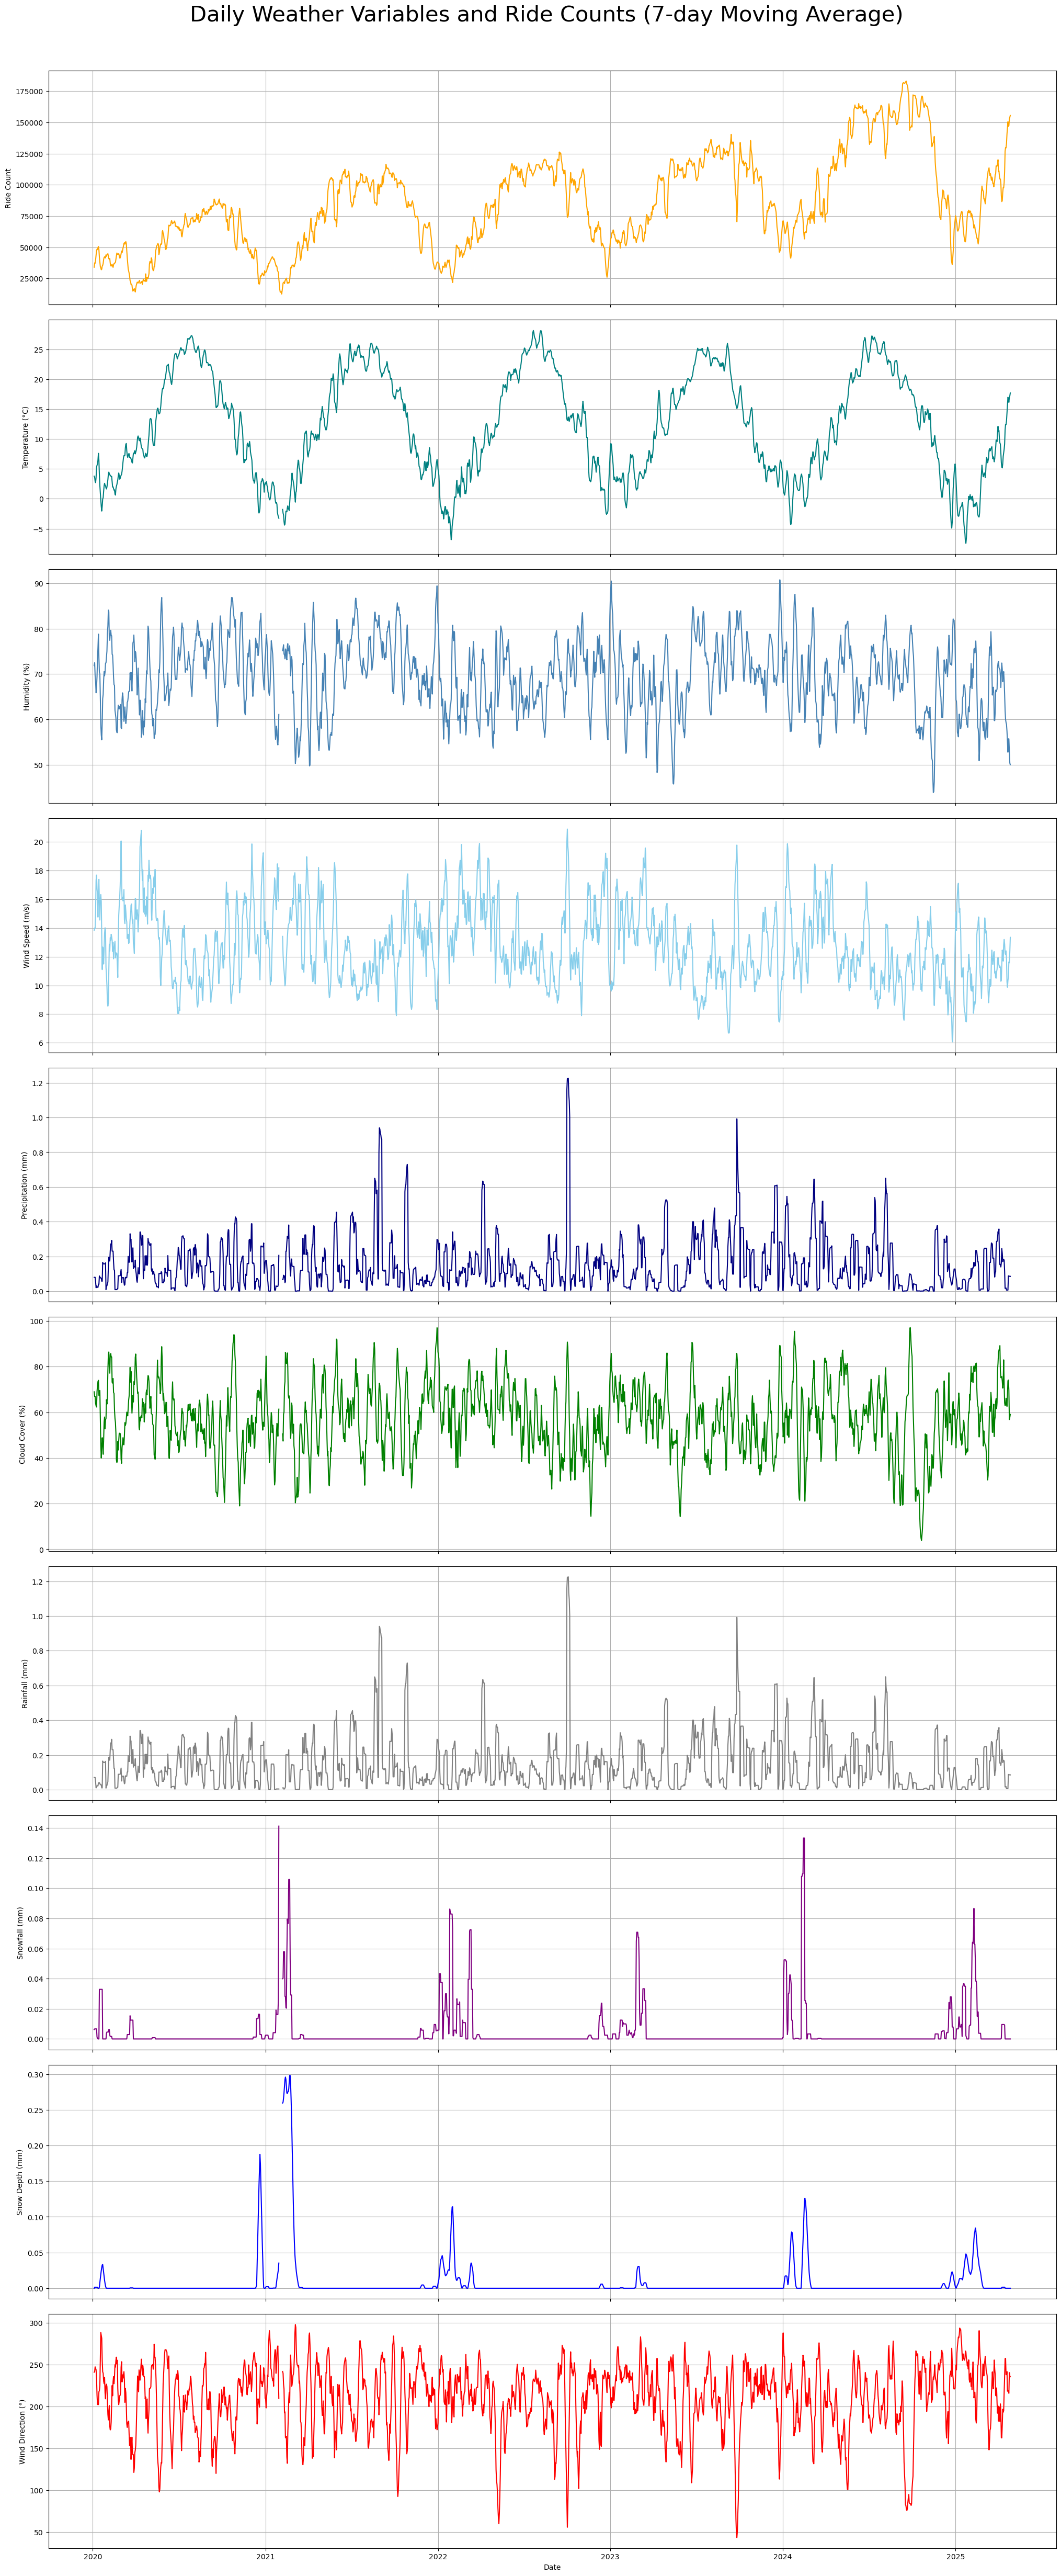

In [26]:
daily_ride_count = citibike_df['ride_count'].resample('D').sum()
daily_temp = citibike_df['temperature_2m'].resample('D').mean()
daily_humid = citibike_df['relative_humidity_2m'].resample('D').mean()
daily_wind_speed = citibike_df['windspeed_10m'].resample('D').mean()
daily_precip = citibike_df['precipitation'].resample('D').mean()
daily_cloud_cover = citibike_df['cloudcover'].resample('D').mean()
daily_rain = citibike_df['rain'].resample('D').mean()
daily_snow = citibike_df['snowfall'].resample('D').mean()
daily_snow_depth = citibike_df['snow_depth'].resample('D').mean()
daily_wind_direction = citibike_df['winddirection_10m'].resample('D').mean()

# (Optional) Smoothing — 7-day moving average
daily_ride_count_smooth = daily_ride_count.rolling(window=7, center=True).mean()
daily_temp_smooth = daily_temp.rolling(window=7, center=True).mean()
daily_humid_smooth = daily_humid.rolling(window=7, center=True).mean()
daily_wind_speed_smooth = daily_wind_speed.rolling(window=7, center=True).mean()
daily_precip_smooth = daily_precip.rolling(window=7, center=True).mean()
daily_cloud_cover_smooth = daily_cloud_cover.rolling(window=7, center=True).mean()
daily_rain_smooth = daily_rain.rolling(window=7, center=True).mean()
daily_snow_smooth = daily_snow.rolling(window=7, center=True).mean()
daily_snow_depth_smooth = daily_snow_depth.rolling(window=7, center=True).mean()
daily_wind_direction_smooth = daily_wind_direction.rolling(window=7, center=True).mean()

# Plot
fig, axs = plt.subplots(10, sharex=True, figsize=(20, 50))
fig.suptitle('Daily Weather Variables and Ride Counts (7-day Moving Average)', fontsize=30)
fig.tight_layout(rect=[0, 0, 1, 0.97])

ax = axs[0]
ax.plot(daily_ride_count_smooth, color='orange')
ax.set(ylabel='Ride Count')
ax.grid()

ax = axs[1]
ax.plot(daily_temp_smooth, color='teal')
ax.set(ylabel='Temperature (°C)')
ax.grid()

ax = axs[2]
ax.plot(daily_humid_smooth, color='steelblue')
ax.set(ylabel='Humidity (%)')
ax.grid()

ax = axs[3]
ax.plot(daily_wind_speed_smooth, color='skyblue')
ax.set(ylabel='Wind Speed (m/s)')
ax.grid()

ax = axs[4]
ax.plot(daily_precip_smooth, color='navy')
ax.set(ylabel='Precipitation (mm)')
ax.grid()

ax = axs[5]
ax.plot(daily_cloud_cover_smooth, color='green')
ax.set(ylabel='Cloud Cover (%)')
ax.grid()

ax = axs[6]
ax.plot(daily_rain_smooth, color='gray')
ax.set(ylabel='Rainfall (mm)')
ax.grid()

ax = axs[7]
ax.plot(daily_snow_smooth, color='purple')
ax.set(ylabel='Snowfall (mm)')
ax.grid()

ax = axs[8]
ax.plot(daily_snow_depth_smooth, color='blue')
ax.set(ylabel='Snow Depth (mm)')
ax.grid()

ax = axs[9]
ax.plot(daily_wind_direction_smooth, color='red')
ax.set(ylabel='Wind Direction (°)')
ax.grid()

plt.xlabel('Date')
plt.show()


### Observations

Although it is ideal to use statistical methods to numerically prove that there is correlation between bike rental data and the weather variables, it can also be beneficial to analyze them visually as trends and seasonalities can be compared

Once again all data points used 7 day rolling mean to ensure readability but there were several insights that were gained
- In terms of seasonality, bike rental data and temperature were very similar suggesting that during the colder seasons (end and beginning of years), commutes by bike were significantly lowered due to the harsher weather conditions and peoples preference.
- Similarly, snowfall also had similar behaviors. Although not in terms of seasonality, snowfall data had spikes during the dips in bike rental data which again can be infered to be related to people not prefering to bike in colder conditions.
- As for the rest of the variables, most of them were noisy and by visual analysis does not seem like there are any seasonal similarities between them and the bike rental data

Overall, some key insights were gained but visually analyzing the time plots do not tell the whole story. Covered in the next section, correlation plot and values can help us understand relationships between bike rental data and weather variables in a much more reliable manner.



# 8. Weather Data vs Bike Demand Scatter Plot & Correlation 

To better understand how weather conditions affect bike rental demand, I conducted a correlation analysis between the two datasets. By creating scatter plots, we can visually examine the relationships between each weather varibale and bike rentals.

In addition to visual analysis, I also calculated the correlation coefficients to numerically test the strength direction of these linear relationships. 

These insights not only provide depper understanding of how weather impacts bike usage but also helps in selecting important weather features than can be included an variables in multivariate and machine learning forecasting models

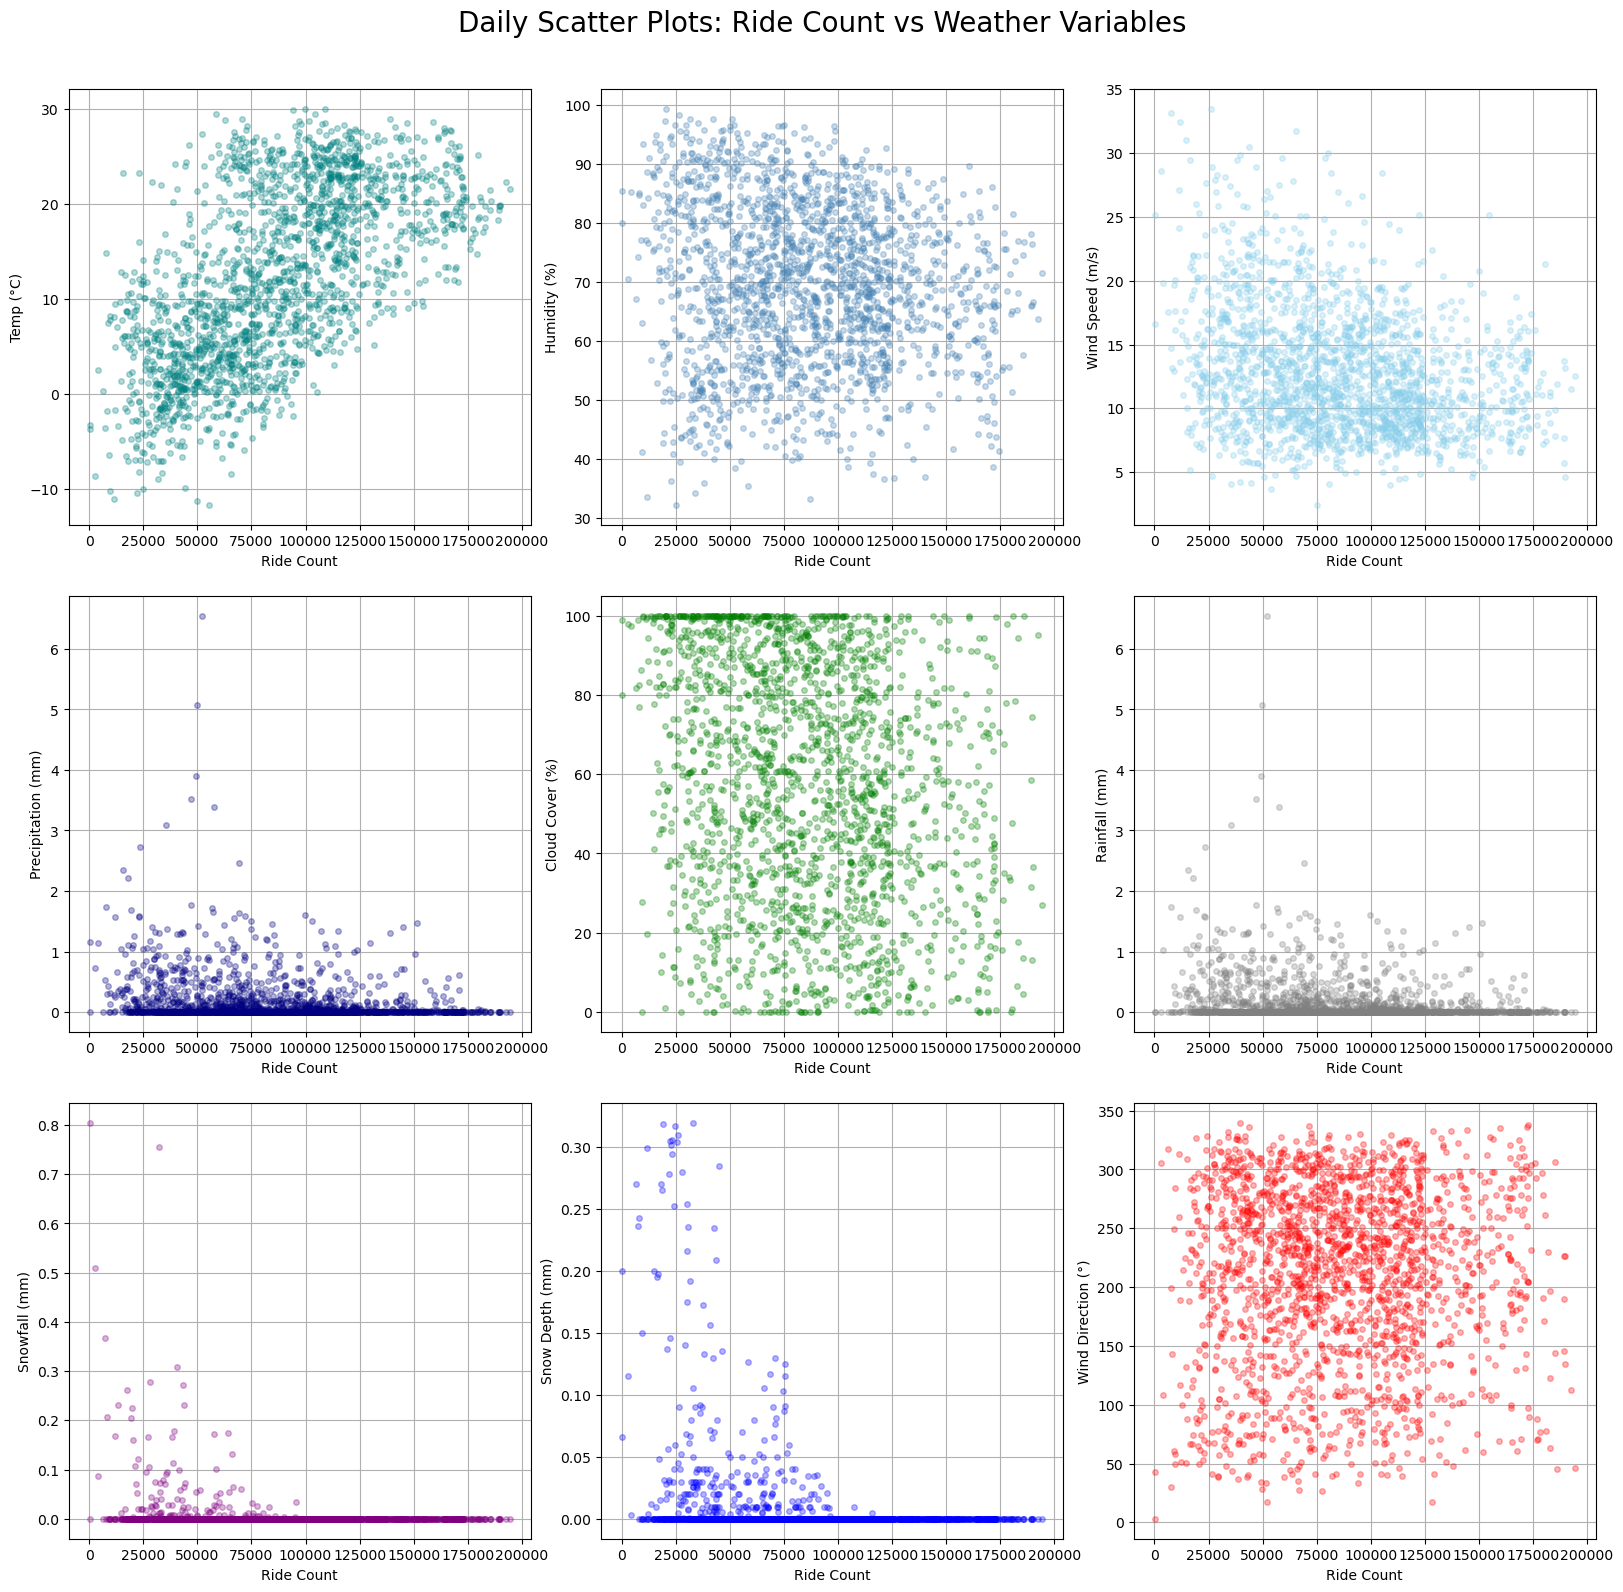

In [27]:
fig, ax = plt.subplots(3, 3, figsize=(16, 16)) 
fig.suptitle('Daily Scatter Plots: Ride Count vs Weather Variables', fontsize=20)
fig.tight_layout(rect=[0, 0, 1, 0.97], h_pad=3, w_pad=2)

ax[0,0].plot(daily_ride_count, daily_temp, '.', alpha=0.3, ms=8, color='teal')
ax[0,0].set(xlabel='Ride Count', ylabel='Temp (°C)')
ax[0,0].grid()

ax[0,1].plot(daily_ride_count, daily_humid, '.', alpha=0.3, ms=8, color='steelblue')
ax[0,1].set(xlabel='Ride Count', ylabel='Humidity (%)')
ax[0,1].grid()

ax[0,2].plot(daily_ride_count, daily_wind_speed, '.', alpha=0.3, ms=8, color='skyblue')
ax[0,2].set(xlabel='Ride Count', ylabel='Wind Speed (m/s)')
ax[0,2].grid()

ax[1,0].plot(daily_ride_count, daily_precip, '.', alpha=0.3, ms=8, color='navy')
ax[1,0].set(xlabel='Ride Count', ylabel='Precipitation (mm)')
ax[1,0].grid()

ax[1,1].plot(daily_ride_count, daily_cloud_cover, '.', alpha=0.3, ms=8, color='green')
ax[1,1].set(xlabel='Ride Count', ylabel='Cloud Cover (%)')
ax[1,1].grid()

ax[1,2].plot(daily_ride_count, daily_rain, '.', alpha=0.3, ms=8, color='gray')
ax[1,2].set(xlabel='Ride Count', ylabel='Rainfall (mm)')
ax[1,2].grid()

ax[2,0].plot(daily_ride_count, daily_snow, '.', alpha=0.3, ms=8, color='purple')
ax[2,0].set(xlabel='Ride Count', ylabel='Snowfall (mm)')
ax[2,0].grid()

ax[2,1].plot(daily_ride_count, daily_snow_depth, '.', alpha=0.3, ms=8, color='blue')
ax[2,1].set(xlabel='Ride Count', ylabel='Snow Depth (mm)')
ax[2,1].grid()

ax[2,2].plot(daily_ride_count, daily_wind_direction, '.', alpha=0.3, ms=8, color='red')
ax[2,2].set(xlabel='Ride Count', ylabel='Wind Direction (°)')
ax[2,2].grid()

plt.show()

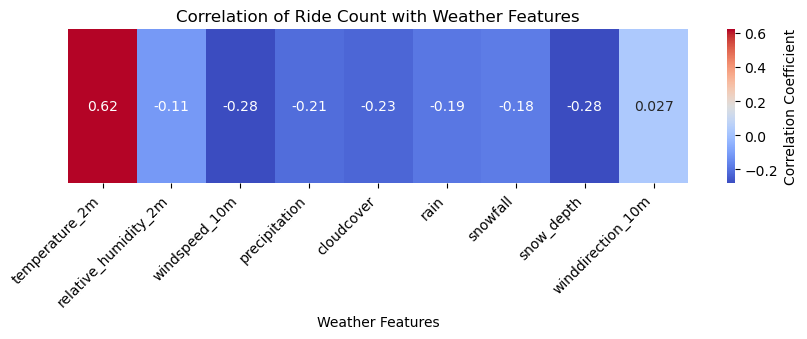

In [28]:
import seaborn as sns

# Resample your data
y = citibike_df['ride_count'].resample('D').sum()
X = citibike_df[['temperature_2m', 'relative_humidity_2m', 'windspeed_10m', 
                 'precipitation', 'cloudcover', 'rain', 'snowfall', 
                 'snow_depth', 'winddirection_10m']].resample('D').mean()

# Merge into one dataframe
ride_weather_df = pd.concat([y, X], axis=1)

# Compute correlation
ride_corr = ride_weather_df.corr()['ride_count'].drop('ride_count')  # Correlation with ride_count only

# Plot horizontal heatmap
plt.figure(figsize=(10, 2))
sns.heatmap(ride_corr.to_frame().T, annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation of Ride Count with Weather Features')
plt.yticks([])
plt.xlabel('Weather Features')
plt.xticks(rotation=45, ha='right')
plt.show()


### Observations

From the resulting scatter plots and correlation coefficients, some insights gathered from the previous section were supported while some were contradicted
- The visual analysis of the time plots between ride counts and temperature by the scatter plots. Specifically, there is a clear positive trend, showing that as temperature increases, ride counts also increase. This is supported by a correlation coefficienct of 0.62
- Scatter plots for variables like windspeed and snow depth did not show as strong a visual relationship as temperature, but the general shape suggested the possibility of non-linear relationships. This was shown through the correlation coefficients, with slight positive correlations around 0.28, which may still be worth exploring
- For the rest of the scatter plots, there was little visible indication of any relationship. Howeverm the correlation coefficient suggested that precipitation and cloud cover have slight correlations with ride counts at 0.21 and 0.23 respectively

Overall, the insights into the correlation between weather variables and ride counts were valuable. However, it is important to understand that correlation coefficients mainly capture linear relationships, and there may be underlying non-linear patterns that could be found through machine learning models. Due to this, I decided to keep track of variables with a correlation coefficient higher than 0.2 for use during the modeling section.




# 9. AFC and PAFC Plots

Before building forecasting models, it is important to understand the structure and dependecies within the bike rental data. To be able to capture these aspects, I plotted the Autocorrelation Function (AFC) and Partial Authocorrelation Function (PAFC) of the daily ride count data between three different aggregations: hourly, daily, weekly.
- Hourly aggregation: capturing short-term dependencies and between-day . Lags were set at 24 to be able to analyze lags for one full day (24 hours)
- Daily aggregation: to examine broader day to day trends and weekly seasonality. Lags were set to 30 to cover around one month
- Weekly Aggregation: to observe long terms autocorrelation and trends across weeks. Lags were set at 52 to span one whole year.

As the AFC shows how current values relate to its past values and PACF focuses on direct relationships, analyzing these two plots at different aggregations levels allows for a comprehensive understanding of the data's short term and long term dependencies and helps choose the correct number of lags for forecasting models

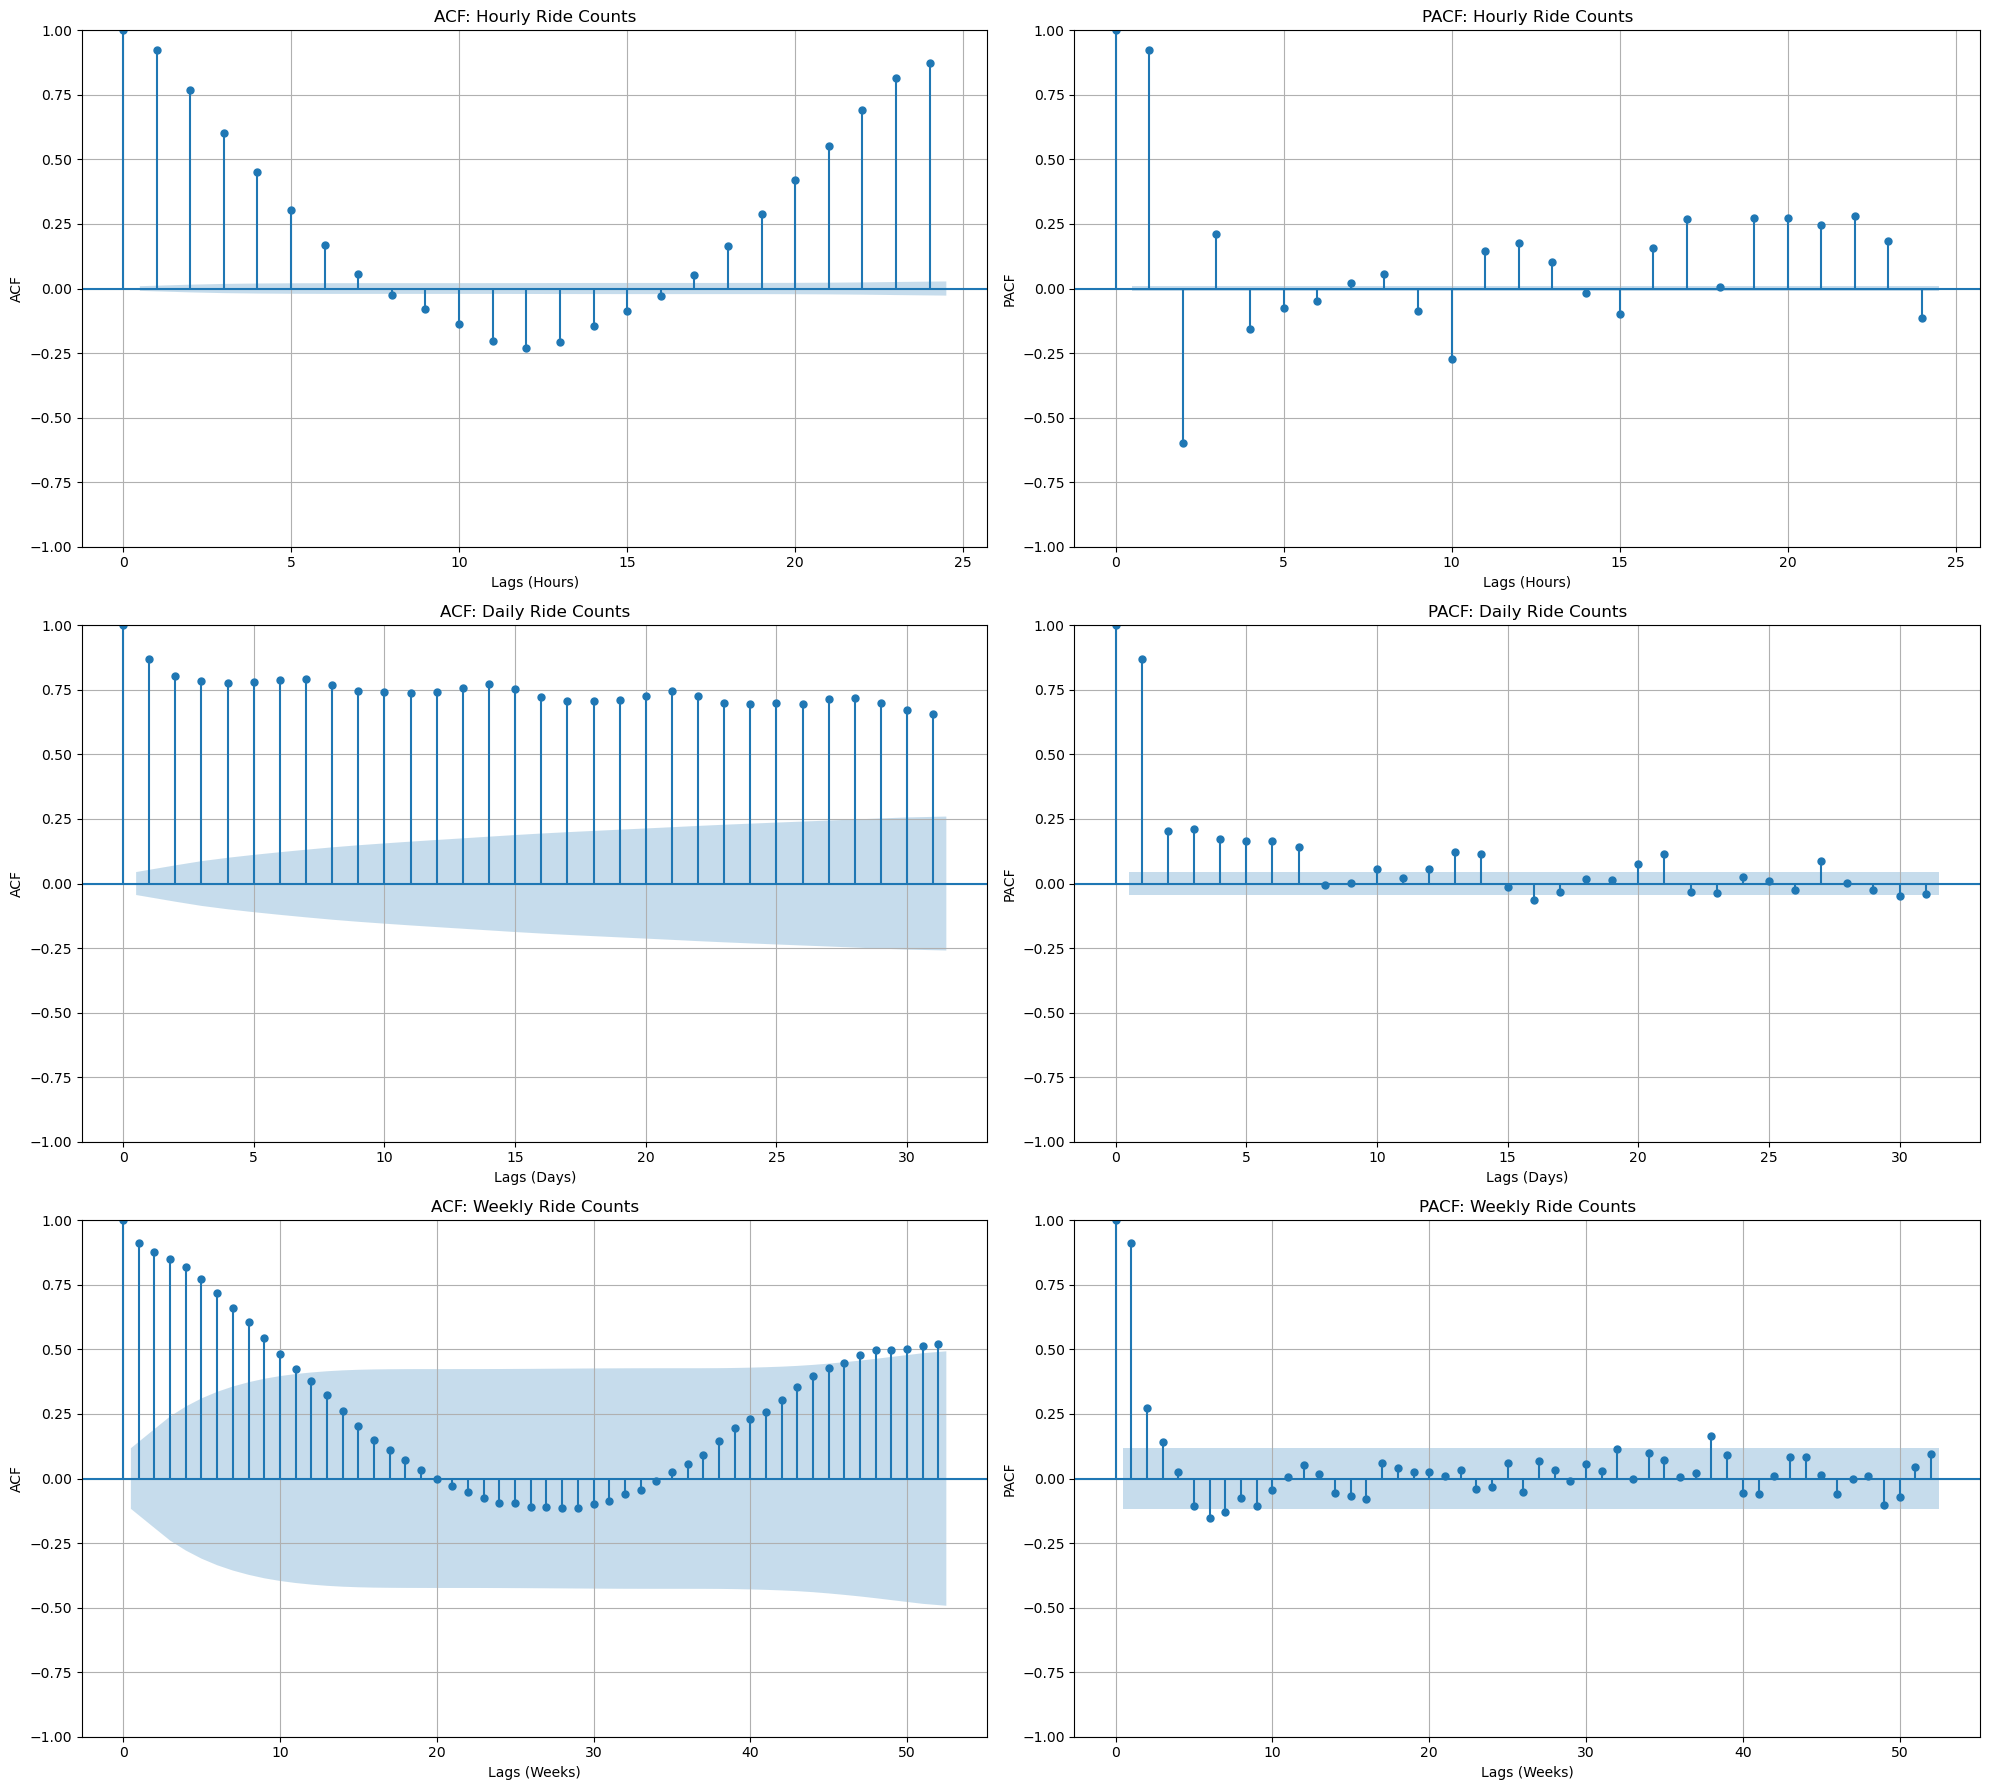

In [29]:
fig, ax = plt.subplots(3, 2, figsize=(20, 18))

# HOURLY
hourly_acf = citibike_df['ride_count']
sm.graphics.tsa.plot_acf(hourly_acf, ax=ax[0,0], lags=24)
ax[0,0].set_title("ACF: Hourly Ride Counts")
ax[0,0].set_xlabel("Lags (Hours)")
ax[0,0].set_ylabel("ACF")
ax[0,0].grid()

sm.graphics.tsa.plot_pacf(hourly_acf, ax=ax[0,1], lags=24, method='ywm')
ax[0,1].set_title("PACF: Hourly Ride Counts")
ax[0,1].set_xlabel("Lags (Hours)")
ax[0,1].set_ylabel("PACF")
ax[0,1].grid()

# DAILY
daily_acf = citibike_df['ride_count'].resample('D').sum()
sm.graphics.tsa.plot_acf(daily_acf, ax=ax[1,0], lags=31)
ax[1,0].set_title("ACF: Daily Ride Counts")
ax[1,0].set_xlabel("Lags (Days)")
ax[1,0].set_ylabel("ACF")
ax[1,0].grid()

sm.graphics.tsa.plot_pacf(daily_acf, ax=ax[1,1], lags=31, method='ywm')
ax[1,1].set_title("PACF: Daily Ride Counts")
ax[1,1].set_xlabel("Lags (Days)")
ax[1,1].set_ylabel("PACF")
ax[1,1].grid()

# WEEKLY
weekly_acf = citibike_df['ride_count'].resample('W').sum()
sm.graphics.tsa.plot_acf(weekly_acf, ax=ax[2,0], lags=52)
ax[2,0].set_title("ACF: Weekly Ride Counts")
ax[2,0].set_xlabel("Lags (Weeks)")
ax[2,0].set_ylabel("ACF")
ax[2,0].grid()

sm.graphics.tsa.plot_pacf(weekly_acf, ax=ax[2,1], lags=52, method='ywm')
ax[2,1].set_title("PACF: Weekly Ride Counts")
ax[2,1].set_xlabel("Lags (Weeks)")
ax[2,1].set_ylabel("PACF")
ax[2,1].grid()

plt.tight_layout()
plt.show()


### Observations

Hourly Aggregation
- The AFC plot shows a strong positive autocorrelation that gradually decreasing over the first couple lags (hours) and becomes negative as it reaches 12 lags. Interestingly, there is a visible cycle pattern with peaks and troughs, showing that there is significant daily seasonality across 24 hours
- The PAFC plots shows a significant spike at lag 1 which is followed by a moderate but smaller spikes at latter lags. This also shows noticable patterns until lag 24, further proving that there ceratinly is daily seasonality.

Daily Aggregation
- The AFC plot shows very high autocorrelation values across all the lags up until 30 days with very minimal decay. This shows that the there is a possibility of a strong trend and weekly seasonality
- The PAFC plot shows a strong spike at lat 1 and much smaller but significant spikes at lags of multiples of 7. This highly suggests that there is a weekly pattern where bike rental counts are influenced by prior weeks.

Weekly Aggregation
- The AFC plot for weekly data also shows strong positive autocorrelation with moderate decay but still showing periodicity. This indicated that there is a long term trend across weeks
- The PAFC plot shows a significant spike at lag one, with lower and stable correlations further on. This suggests that immidiate weeks have the strongest influence.

Overall, the analysis of ACF and PACF plots across the different aggregation provide important insights into the structure of the bike rental demand. The patterns that were found will guide the selection of appopriate lags for the forecasting model. By using these lags that alight with seasonality, the models would be prepared to capture the patterns in the data, providing a model than can better predict bike demand.

# 10. Mean Forecasting

To create a simple baseline for comparison before diving in the more complex forecasting models, I implemented a mean forecast model. This model predicts the average of the the training data as the forecast for every point in the test set. While it cannot understand structure such as seasonality and trend, it gives a reference point to measure improvement going from simple models to advanced models

- Purpose
    - Serving as a benchmark model to evaluate performance of all other models
    - Useful for measuring how much better other forecasting models are compared to simply calculating the mean of historical data
    - Highlights the importance incorporating models that capture trend, seasonality, and outside variables
- Feature Selection
    - ride_count was aggregated to daily frequencies using the resample function
    - As this is a simple mean forecasting model, no outside variables were brought in
- Model Training
    - 80% of the dataset was for training while 20% was for testing (approximately the last 400 days)
- Forecasting and Plotting (SAME ACROSS THE ENTIRE PROJECT)
    - Although mean was calculated based on the original daily aggregated data, a 7 day rolling mean was used for better readability
    - The plot specifically shows the predicted data on the test set versus the entire dataset
- Performance Metrics
    - Root Mean Square Error (RMSE) was used to check the amount of error in the predicted vs and actual ride counts
    - Mean Absolute Error (MAE) was used to numerically visualize the range of models predictions in comparison to its error
    - R^2 score was used to explain what percentage (R^2 times 100) of the variance the model was able to predict (basically percentage of how well the model predicted)

Mean Forecast:
RMSE: 62882.56, MAE: 53502.80, R²: -125.48%


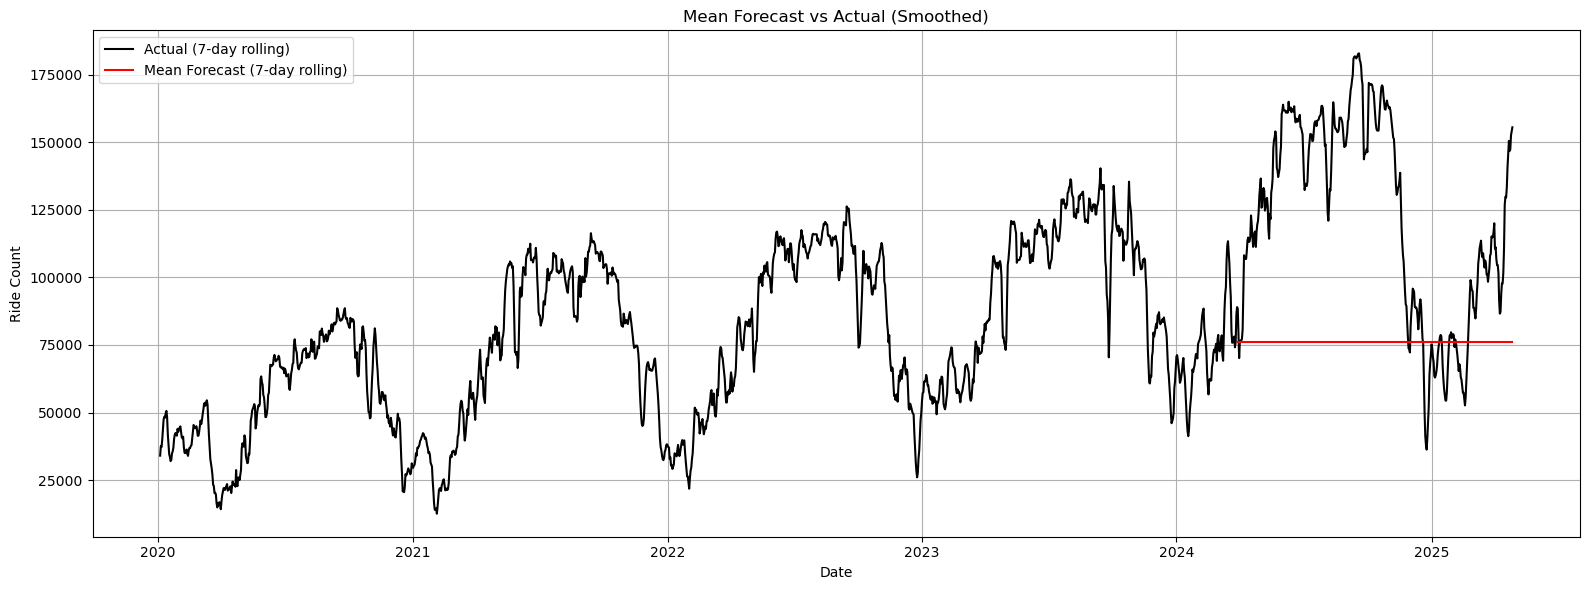

In [27]:
# Use the same daily data
y = citibike_df['ride_count'].resample('D').sum().ffill()
train = y[:-400]
test = y[-400:]

mean_forecast = pd.Series(train.mean(), index=test.index)

rmse = np.sqrt(mean_squared_error(test, mean_forecast))
mae = mean_absolute_error(test, mean_forecast)
r2 = r2_score(test, mean_forecast)

print("Mean Forecast:")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2 * 100:.2f}%")

plt.figure(figsize=(16, 6))
plt.plot(y.rolling(7, center=True).mean(), label='Actual (7-day rolling)', color='black')
plt.plot(mean_forecast.rolling(7, center=True).mean(), label='Mean Forecast (7-day rolling)', color='red')
plt.title("Mean Forecast vs Actual (Smoothed)")
plt.xlabel("Date")
plt.ylabel("Ride Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### Observations

- Visual Analysis
    - The red line indicating the predictions for the last 400 days showed constant forecasting, in line with what the model acheives
    - The obvious lack of prediction accuracy realates to the models ability to ONLY use the mean of past data to predict the future and does not interact with trend, seasonality, and weather variables
- Model Metrics
    - RMSE: 62,882.56
        - With this extremely high RMSE, it indicates that on average, predicted values are far from the actual ride counts
    - MAE: 52,502.80
        - MAE, a stricter error calculator that RMSE also confirms that the model haevily deviates from the actual data by over 50,000 rides per day
    - R^2: -125.48%
        - This value tells us that the performance of the model is worse than predicting the mean of data itself
     
Interpretation of Results
- While it is simple to implement, the mean forecast gives us the understanding that learning structures such as trend and seasonality of data (if shown) is very important. As it fails to model those aspects, this lets us known that the usage of models that incorporate patterns is needed to get meaningful prediction results

# 11. Naive Forecasting

For visualization purposes and further baseline understanding, the naive forecasting model was implemented. This forecast method assumes that the ride counts on each day of the test dataset will be the same as the last observed value from the training set. Although quite simple, it can be used to get a basic understanding of how this model forecasts data given historical values. 

- Purpose
    - Stronger baseline than the mean forecasting due to its ability to preserve recent patterns minimally
- Feature Selection
    - Once again, daily aggregated ride counts was the only variable used as this simple model uses no outside variables
- Model Training
    -  80% of the dataset was for training while 20% was for testing (approximately the last 400 days)

Naive Forecast:
RMSE: 46891.97, MAE: 40517.42, R²: -25.39%


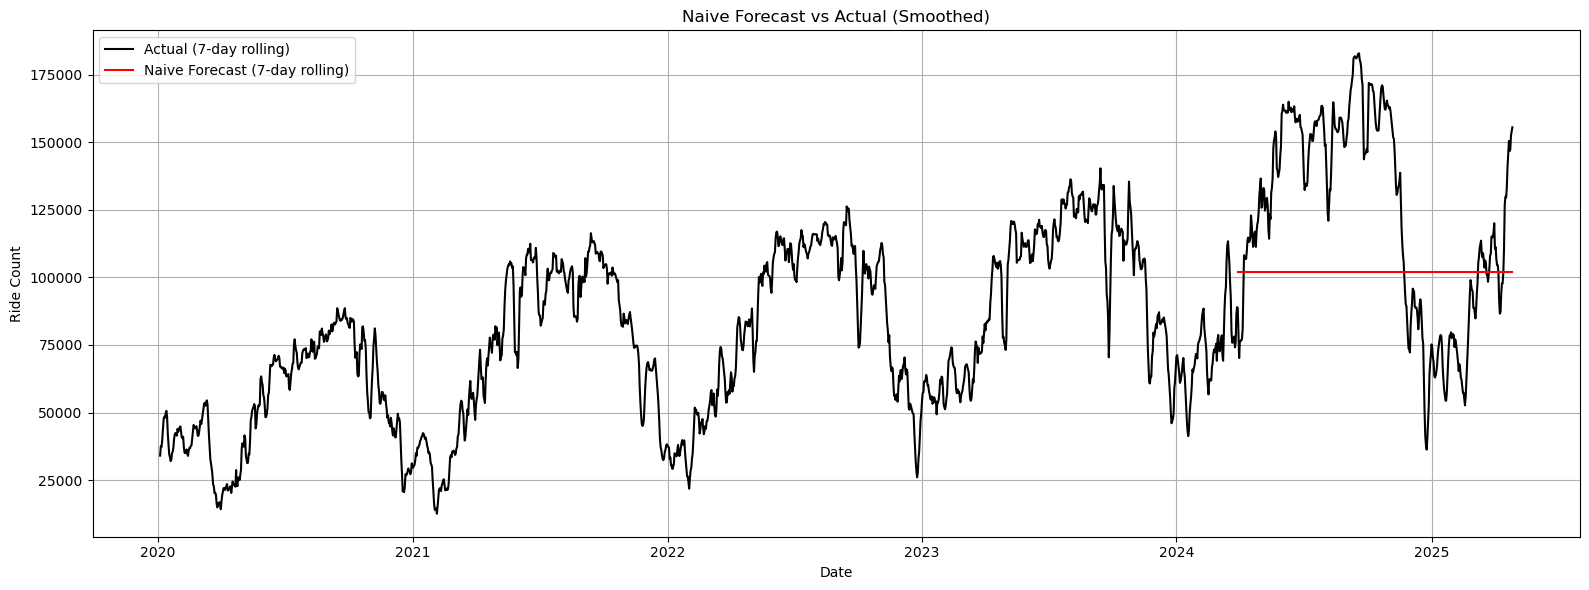

In [28]:
y = citibike_df['ride_count'].resample('D').sum().ffill()
train = y[:-400]
test = y[-400:]

naive_forecast = pd.Series(train.iloc[-1], index=test.index)

rmse = np.sqrt(mean_squared_error(test, naive_forecast))
mae = mean_absolute_error(test, naive_forecast)
r2 = r2_score(test, naive_forecast)

print("Naive Forecast:")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2 * 100:.2f}%")

# Plot
plt.figure(figsize=(16, 6))
plt.plot(y.rolling(7, center=True).mean(), label='Actual (7-day rolling)', color='black')
plt.plot(naive_forecast.rolling(7, center=True).mean(), label='Naive Forecast (7-day rolling)', color='red')
plt.title("Naive Forecast vs Actual (Smoothed)")
plt.xlabel("Date")
plt.ylabel("Ride Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Observations

- Visual Analysis
    - The red forcast line captures the most recent level of the bike demand
    - While it obviously fails to model patterns, it stays closer to actual values compared to what the mean forecasted due to its ability to remember the level of recent values
- Model Metrics
    - RMSE: 46,891.97
        - Significantly better than the mean forecast, showing that recent demand (values) capture more information than the long-term average
    - MAE: 40,517.42
        - Also showing lower than the means MAE, showing further improvement
    - R^2: -25.39%
        - Still quite poor as its worse than guessing the mean but significantly better than the means -125.48%, showing that its capturing some of the patterns

Interpretation of Results

Compared to the mean forecast, the naive model performs better because it uses the most recent data point as its prediction. in datasets with momentum, trend, seasonality, and other patterns, the last value often provides a more relavent short-term estimate compared to a mean of the entire dataset. Still, the model fails to capture the strong patterns, making it an obvious poor choice for forecasting. 

# 12. Drift Forecasting

To capture simple trend in the data, I implemented a drift forecast model. this method assumes that the future values will continue the average rate of change captured between the first and last values in the training dataset. Unlike the naive model, it allows for a linear increase of decrease, making it a stronger baseline when the data has trend. 

- Purpose
    - Introduce a basic model that captures direction (trend in either direction)
    - Improve the naive model by modeling momentum
- Feature Selection
    - Once again, daily aggregated ride counts was the only variable used as this simple model uses no outside variables
- Model Training
    - 80% of the dataset was for training while 20% was for testing (approximately the last 400 days)

Drift Forecast:
RMSE: 45820.44, MAE: 40204.20, R²: -19.72%


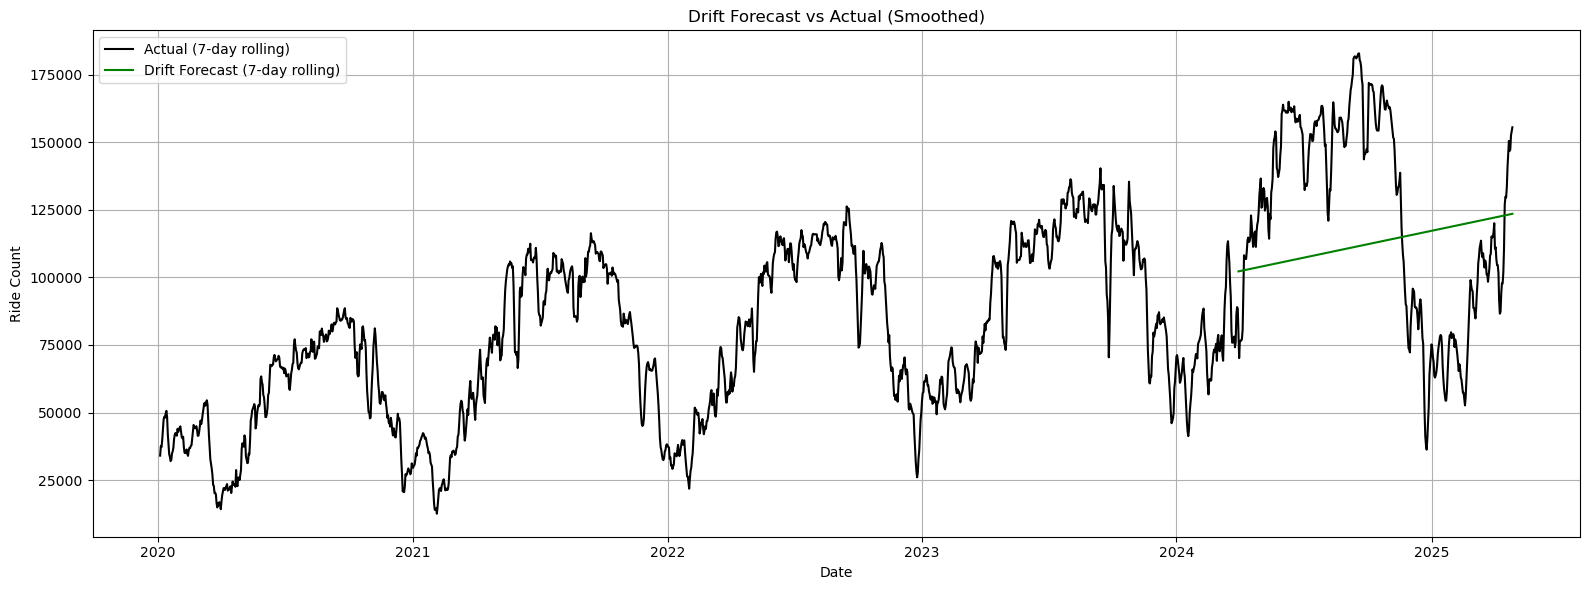

In [29]:
y = citibike_df['ride_count'].resample('D').sum().ffill()
train = y[:-400]
test = y[-400:]

slope = (train.iloc[-1] - train.iloc[0]) / (len(train) - 1)
drift_forecast = pd.Series([train.iloc[-1] + slope * (i + 1) for i in range(len(test))], index=test.index)

rmse = np.sqrt(mean_squared_error(test, drift_forecast))
mae = mean_absolute_error(test, drift_forecast)
r2 = r2_score(test, drift_forecast)

print("Drift Forecast:")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2 * 100:.2f}%")

plt.figure(figsize=(16, 6))
plt.plot(y.rolling(7, center=True).mean(), label='Actual (7-day rolling)', color='black')
plt.plot(drift_forecast.rolling(7, center=True).mean(), label='Drift Forecast (7-day rolling)', color='green')
plt.title("Drift Forecast vs Actual (Smoothed)")
plt.xlabel("Date")
plt.ylabel("Ride Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Observations

- Visual Analysis
    - The green line of the drift forecast matches well with the overall direction of the test dataset, following the upward trend
    - It still misses the seasonality and short term spikes but trend itself already tells a better story about the data than the naive model
- Model Metrics
    - RMSE: 45,820.44
        - Slightly better than naive, showing that the model is capturing linear differences
    - MAE: 40,204.20
        - Slightly better than the naive, indicating that this model it better, but given MAE's strict error calculation, this model numerically is not much better
    - R^2: -19.72%
        - Still below zero but closer to 0% meaning that this model explain more variance in the test data than the previous models
     
Interpretation of Results

The drift model improves upon the mean and naive models by capturing direction in the dataset. While its still too simple of a model to capture seasonality and outside factors, its ability to capture trend helps it stay closer to the actual values. This shows that even simple trend understanding can improve models acuuracy compared to simpler ones. 

# 13. Simple Exponential Smoothing

To explore a basic statistical model with smoothing capabilities, I implemented a Simple Exponential Smoothing model. SES forecasts future values based on an exponentially weighted average of past observations, allowing it to prioritize recent data over older data without actually modeling trend of seasonality

- Purpose
    - Provide a simple yet dynamic alternative to the previous models by giving more weight to recent values
    - Servers as the next step towards advanced SES models
    - Understand how well a memory based models can forecasting bike demand
- Feature Selection
    -  Once again, daily aggregated ride counts was the only variable used as this simple model uses no outside variables as SES itself performs smoothing and weighting by itself
- Model Training
    -  80% of the dataset was for training while 20% was for testing (approximately the last 400 days)
    -  SimpleExpSmoothing from statsmodels was used to fit the data as it can automatically select an optimal smoothing level (alpha)

/Users/satvikkonda/anaconda3/envs/Info1/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


RMSE: 57395.72
MAE: 48762.61
R²: -87.849%


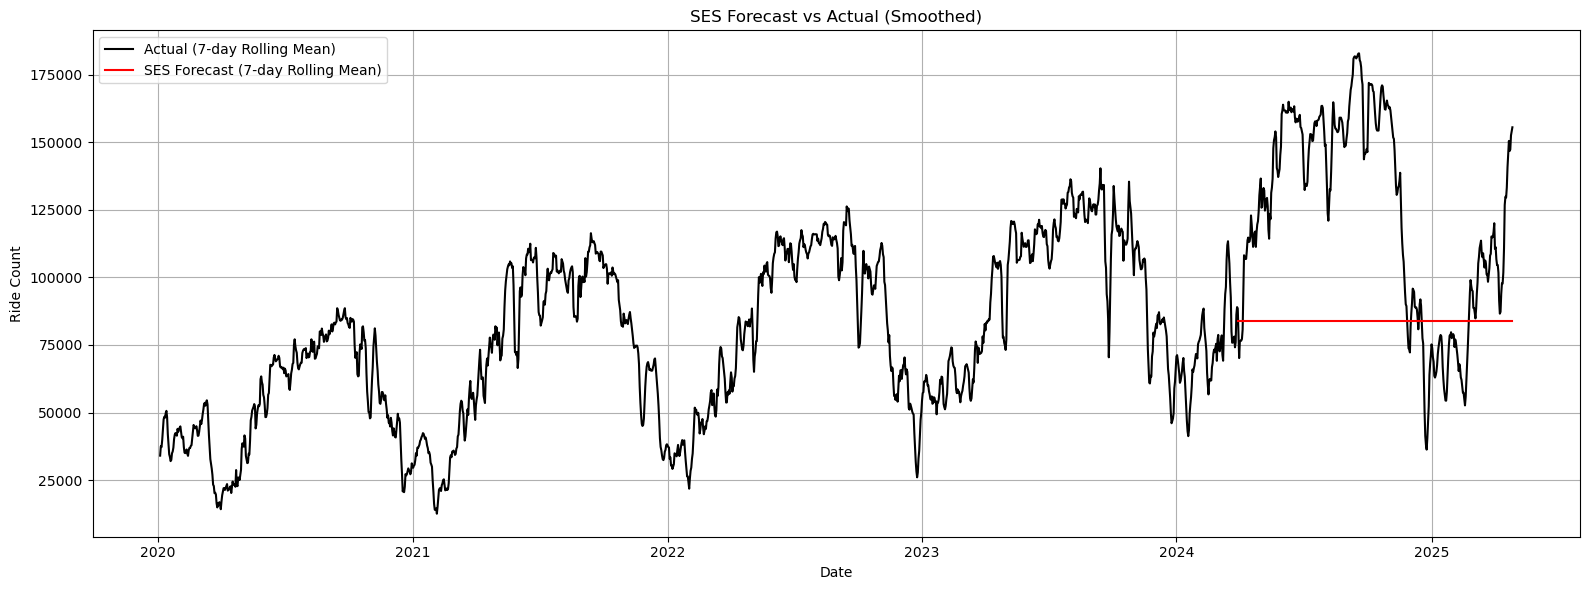

In [30]:
daily_df = citibike_df.resample('D').sum()

y = daily_df['ride_count']

train = y[:-400]
test = y[-400:]

ses_model = SimpleExpSmoothing(train).fit()
ses_forecast = ses_model.forecast(len(test))

rmse_SES = np.sqrt(mean_squared_error(test, ses_forecast))
mae_SES = mean_absolute_error(test, ses_forecast)
r2_SES = r2_score(test, ses_forecast)

print(f"RMSE: {rmse_SES:.2f}")
print(f"MAE: {mae_SES:.2f}")
print(f"R²: {r2_SES * 100:.3f}%")

y_smooth = y.rolling(window=7, center=True).mean()
ses_pred_series = pd.Series(ses_forecast, index=test.index)
y_pred_smooth = ses_pred_series.rolling(window=7, center=True).mean()

plt.figure(figsize=(16, 6))
plt.plot(y_smooth, label='Actual (7-day Rolling Mean)', color='black')
plt.plot(y_pred_smooth, label='SES Forecast (7-day Rolling Mean)', color='red')
plt.title('SES Forecast vs Actual (Smoothed)')
plt.xlabel('Date')
plt.ylabel('Ride Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Observations

- Visual Analysis
    - Despite being designed to give more weight to recent data, the SES forecast flattented and failed to follow the patterns of the test dataset
    - Its output is similar to the naive forecast, but with slight shift in level which was most likely caused by its smoothing
- Model Metrics
    - RMSE: 57,395.72
        - Better than mean but worse than naive and drift, indicating poor accuracy
    - MAE: 48,762.61
        - Confirms the large deviation from actual values
    - R^2: -87.85%
        - Shows that the SES model explained almost none of the variance and did worse a simple constant prediction
     
Interpretations of Results

While SES introduces smoothing based on recency, it was too simple for this dataset. Without pattern recognition, the model essentially increased its trend upward slightly to a flat line. Its poor performance shows that models must be able to capture patterns and not just recent memory to capture meaningful forecasts

# 14. Holt's Linear Trend Method

To imporve upon the memory limited SES, I then implemented Holt's Linear Trend model. this method allows for both level and trend components to be captures, allowing for the model to find upward and downward momentum in the data.

- Purpose
    - Model linear trends in the data more clearly than SES
    - Provides a step towards more complex pattern understanding
    - To check if evaluating global trend can improve forecast accuracy
- Feature Selection
    - Once again, daily aggregated ride counts was the only variable used as this simple model uses no outside variables as this model internally estimates level and trend
- Model Training
    - 80% of the dataset was for training while 20% was for testing (approximately the last 400 days)
    - the model was fit using the .fit() function to automatically initialize the state and continue from there

Holt's Linear Trend:
RMSE: 55192.30
MAE: 47081.00
R²: -73.702%


/Users/satvikkonda/anaconda3/envs/Info1/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


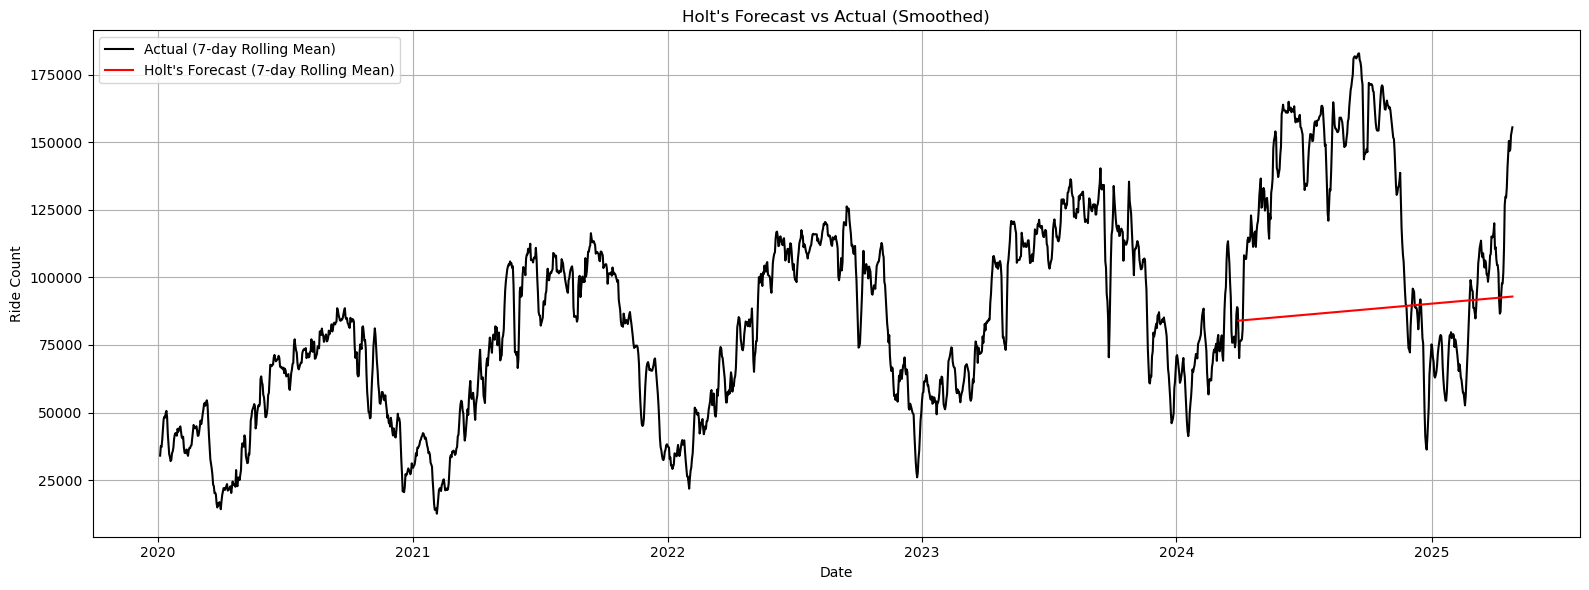

In [31]:
# Resample to daily and clean
daily_df = citibike_df.resample('D').sum()
y = daily_df['ride_count']

# Train-test split (last 30 days)
train = y[:-400]
test = y[-400:]

# Fit Holt’s model
holt_model = Holt(train, initialization_method="estimated").fit()
holt_forecast = holt_model.forecast(len(test))
holt_forecast = pd.Series(holt_forecast, index=test.index)

# Evaluation
rmse_holt_lin = np.sqrt(mean_squared_error(test, holt_forecast))
mae_holt_lin = mean_absolute_error(test, holt_forecast)
r2_holt_lin = r2_score(test, holt_forecast)

print("Holt's Linear Trend:")
print(f"RMSE: {rmse_holt_lin:.2f}")
print(f"MAE: {mae_holt_lin:.2f}")
print(f"R²: {r2_holt_lin * 100:.3f}%")

# Smoothed plot
y_smooth = y.rolling(window=7, center=True).mean()
y_pred_smooth = holt_forecast.rolling(window=7, center=True).mean()

plt.figure(figsize=(16, 6))
plt.plot(y_smooth, label='Actual (7-day Rolling Mean)', color='black')
plt.plot(y_pred_smooth, label="Holt's Forecast (7-day Rolling Mean)", color='red')
plt.title("Holt's Forecast vs Actual (Smoothed)")
plt.xlabel("Date")
plt.ylabel("Ride Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Observations

- Visual Analysis
    - Holt's forecast starting at the end of training data increased slightly, showing that slight trend was captured
    - Although it is more dynamic than SES, the trend still failed to match the steep patterns in the dataset
    - There is slight visual improvement over SES but it still cannot capture the aggresive seasonality
- Model Metrics
    - RMSE: 55,192.30
        - Slightly better than SES but worse than Drift, showing that trend is important but capturing recent trend is crucial as well
    - MAE: 47,081.00
        - Indicates the model gave less consistent errors than SES
    - R^2: -73.70%
        - Highly negative, showing that Holt's ability to capture linear trends it not enough on its own

Interpretation of Results

This model shows that trend alone is not enough in data with strong seasonality and trend combined. While it did imporve very slights from SES by including slope, it did worse than drift and naive showing that level also needs to be considered. Once again these results show that using a model that can capture seasonality is crucial for accuracy. 

# 15. Holt Winters Seasonal Smoothing

To capture both long term trends and repeating seasonal patterns, the Holt-Winters seasonal exponential smoothing model was used. This method extends Holt's linear model by including a seasonal component, which is very useful for datasets such as this that show strong yearly cycles.

- Purpose
    - Model trend and seasonality at the same time to better reflect patterns
    - Extend beyond the limitations of Holt's Linear model which ingnored seasonality
-  Feature Selection
    -   Daily aggregated ride counts and a seasonal period or 1 year was used to reflect the dataset
- Model Training
    -  80% of the dataset was for training while 20% was for testing (approximately the last 400 days)
    -  this model was configured using:
        - trend = "add" for additive linear growth
        - seasonal = "add" to model repeating cycles
        - seasonal_periods = 365 to define yearly seasonality

Holt-Winters Seasonal Smoothing:
RMSE: 35648.16
MAE: 29800.05
R²: 27.536%


/Users/satvikkonda/anaconda3/envs/Info1/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


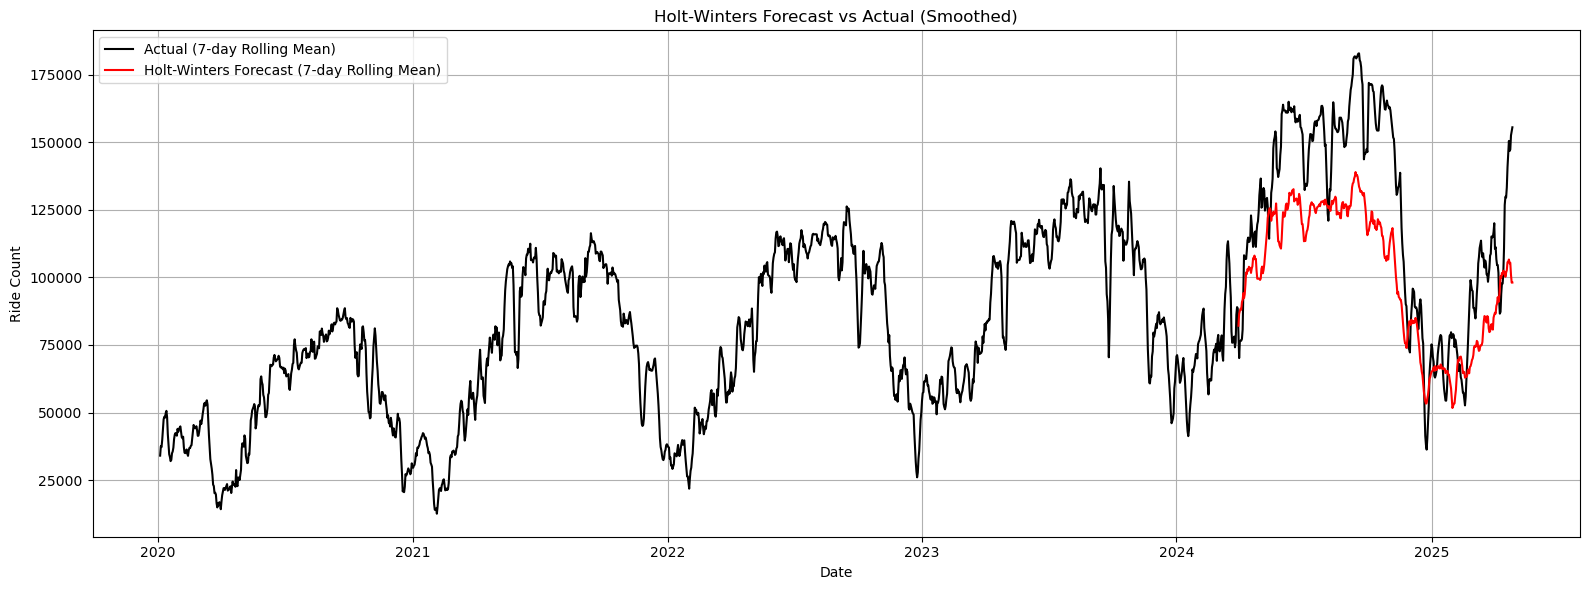

In [32]:
# Daily resample and clean
daily_df = citibike_df.resample('D').sum()
y = daily_df['ride_count']

# Train-test split (last 30 days)
train = y[:-400]
test = y[-400:]

# Holt-Winters seasonal model (additive trend & seasonality)
hw_model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=365,
    initialization_method="estimated"
).fit()

hw_forecast = hw_model.forecast(len(test))
hw_forecast = pd.Series(hw_forecast, index=test.index)

# Metrics
rmse = np.sqrt(mean_squared_error(test, hw_forecast))
mae = mean_absolute_error(test, hw_forecast)
r2 = r2_score(test, hw_forecast)

print("Holt-Winters Seasonal Smoothing:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2 * 100:.3f}%")

# Plot (7-day rolling mean)
y_smooth = y.rolling(7, center=True).mean()
y_pred_smooth = hw_forecast.rolling(7, center=True).mean()

plt.figure(figsize=(16, 6))
plt.plot(y_smooth, label='Actual (7-day Rolling Mean)', color='black')
plt.plot(y_pred_smooth, label="Holt-Winters Forecast (7-day Rolling Mean)", color='red')
plt.title("Holt-Winters Forecast vs Actual (Smoothed)")
plt.xlabel("Date")
plt.ylabel("Ride Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Observations

- Visual Analysis
    - This forecast visibly captures the rise and fall of seasonal patterns although it still underestimates the sharp short term changes, but still performs much better than any baseline or simple smoothing methods
- Model Metrics
    - RMSE: 35,648.16
        - Improvement over all of the other models but an average error of bike rides of around 35,000 is still significant when compared to lower bike demand days
    - MAE: 29,800.05
        - Similarly, lower average errors than other models suggesting that even harsher penalties did cause the model to have as large of a error as the previous models
    - R^2: 27.24%
        - Shows that the model was succesfully able to explain 1/4 of the variation. Although low, it is a significant improvement as it is the only model with a non-zero score

Interpretation of Results

This model demonstrates the importance of clearly modeling seasonality. While it is still limited in linear trends, its ability to capture seasonal rise and fall results in a much stronger performance than any other other baseline and smoothing approach. It still struggles with non-linear spikes and possible external factors which suggests for more robust and flexible models to be implemented

# 16. Autoregressive (AR) Model

For further foundational analysis, the Autoregressive (AR) model wwas used. This model predicts future values as a linear combination of past observations. After testing with several lag values and tuning it according to the performance metrics, AR(31) was used which means that the model sues previous 31 days of ride counts to predict the next. 

- Purpose
    - Establish a statistical benchmarch to show how models that rely on only lags work
    - Determine how well daily ride counts can be forecasted based on past values
    - Understanding the limitations of AR when used without trend, seasonality, and differencing
- Feature Selection
    - Daily aggregated ride counts
    - Lag order set to 31, reflecting a full month of past values for prediction. This value was selected based on the AFC and PAFC plots done previously which reflected strong relationships as lag value 7, 31, and 365
- Model Training
    - 80% of the dataset was for training while 20% was for testing (approximately the last 400 days)
    - an ARIMA model with order (31,0,0) was used to reflect AR with a lag value of 31
    - Alternate lag values of 3 and 7 were used but did not show meaningful impact.
    - a lag value of 365 would have been ideal but was not feasible due to computational constraints

Autoregressive Model (AR(31)):
RMSE: 59183.69
MAE: 50138.41
R²: -98.427%


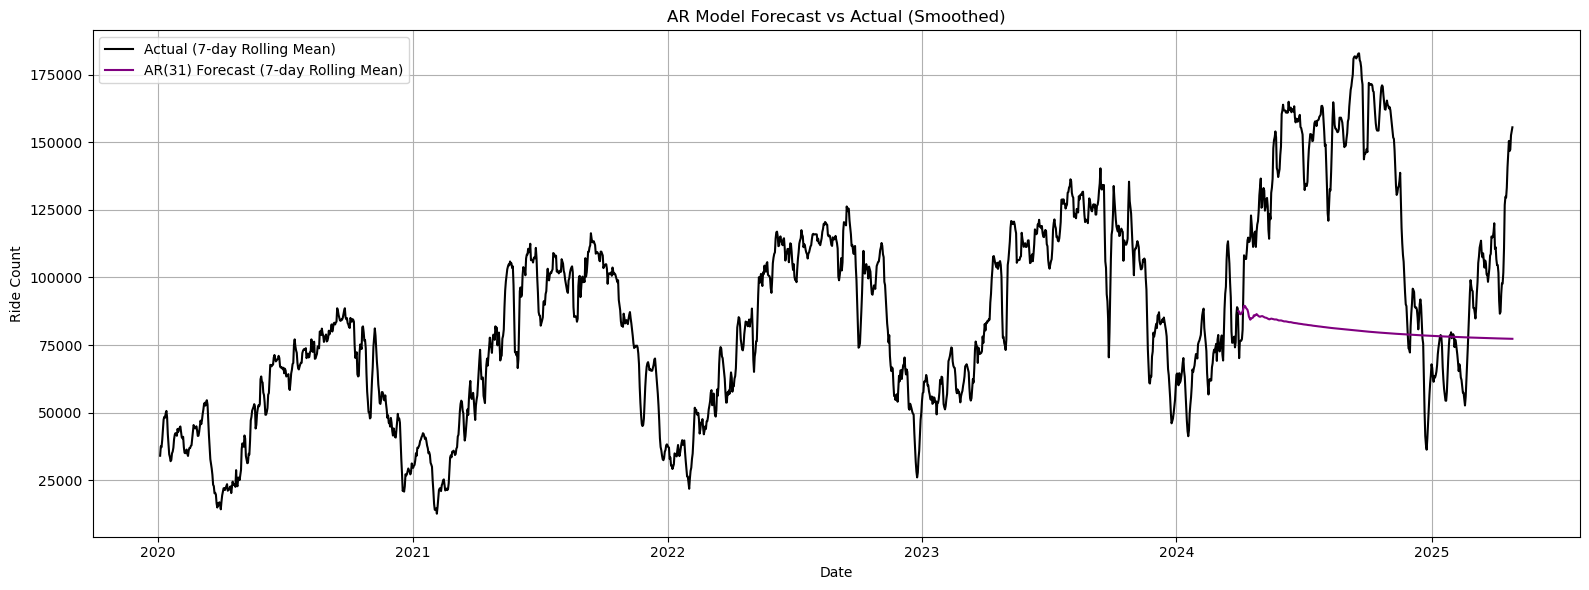

In [91]:
# Resample to daily if not already done
daily_df = citibike_df.resample('D').sum()
y = daily_df['ride_count']

# Train-test split (last 30 days)
train = y[:-400]
test = y[-400:]

# shown is 31 but tested with 3 and 7, little to no improvement
ar_model = ARIMA(train, order=(31, 0, 0)).fit()
ar_forecast = ar_model.forecast(steps=len(test))
ar_forecast = pd.Series(ar_forecast, index=test.index)

# Evaluation
rmse = np.sqrt(mean_squared_error(test, ar_forecast))
mae = mean_absolute_error(test, ar_forecast)
r2 = r2_score(test, ar_forecast)

print("Autoregressive Model (AR(31)):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2 * 100:.3f}%")

# Plot (7-day rolling)
y_smooth = y.rolling(7, center=True).mean()
y_pred_smooth = ar_forecast.rolling(7, center=True).mean()

plt.figure(figsize=(16, 6))
plt.plot(y_smooth, label='Actual (7-day Rolling Mean)', color='black')
plt.plot(y_pred_smooth, label="AR(31) Forecast (7-day Rolling Mean)", color='purple')
plt.title("AR Model Forecast vs Actual (Smoothed)")
plt.xlabel("Date")
plt.ylabel("Ride Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Observations

- Visual Analysis
    - The forecast line barely changes with a slight downward trend as time increases, indicating tat the model failed to detect trend or seasonality
    - Despite using 31 days of past data, the model ouputs a smooth, low variance curve that does not follow the original data
- Model Metrics
    - RMSE: 59,183.69
        - Worse than most previous models
    - MAE: 50,138.41
        - Confirms the RMSE in terms of the models inability to even be directionally correct, resulting in a high average error
    - R^2: -98.43%
        -  Shows that the model once again is worse than guessing the mean, making it the worst model after the baseline mean model

Interpretation of Results

The AR(31) model shows the limits of only using autoregression when applied to a complex, highly seasonal dataset. Without differencing or external feautures, the model fails to capture any structure. This further proves the standpoint that to have an accurate model, seasonality, trend, and possibibly external variables need to be introduced.

# 17. Moving Average (MA) Model

To explore how the use of errors can influence model forecasting, a Moving Average (MA) model was implemented next. Unlike AR models where they reply on past values, MA models use past forecast errors to improve predictions. In this case, I used MA(31), which incorporates the past 31 error terms to predict the current value.

- Purpose
    - To check if past forecast errors understood by the model gives more prediction power to the model
    - Compare MA to AR to see if errors or past values boost the models accuracy
    - To check if errors based models have any postiive performance even for non-staitonary data.
- Feature Selection
    - ride counts aggregated to daily
    - lag order set to 31 which means past 31 error days will will be used to predict today
    - other configurations of 7 and 3 were also used but had no significant change in performance
- Model Training
    - 80% of the dataset was for training while 20% was for testing (approximately the last 400 days)
    - an ARIMA model with order (0,0,31) was used to reflect MA with a lag value of 31

MA
RMSE: 62974.27
MAE: 53621.82
R²: -124.659%


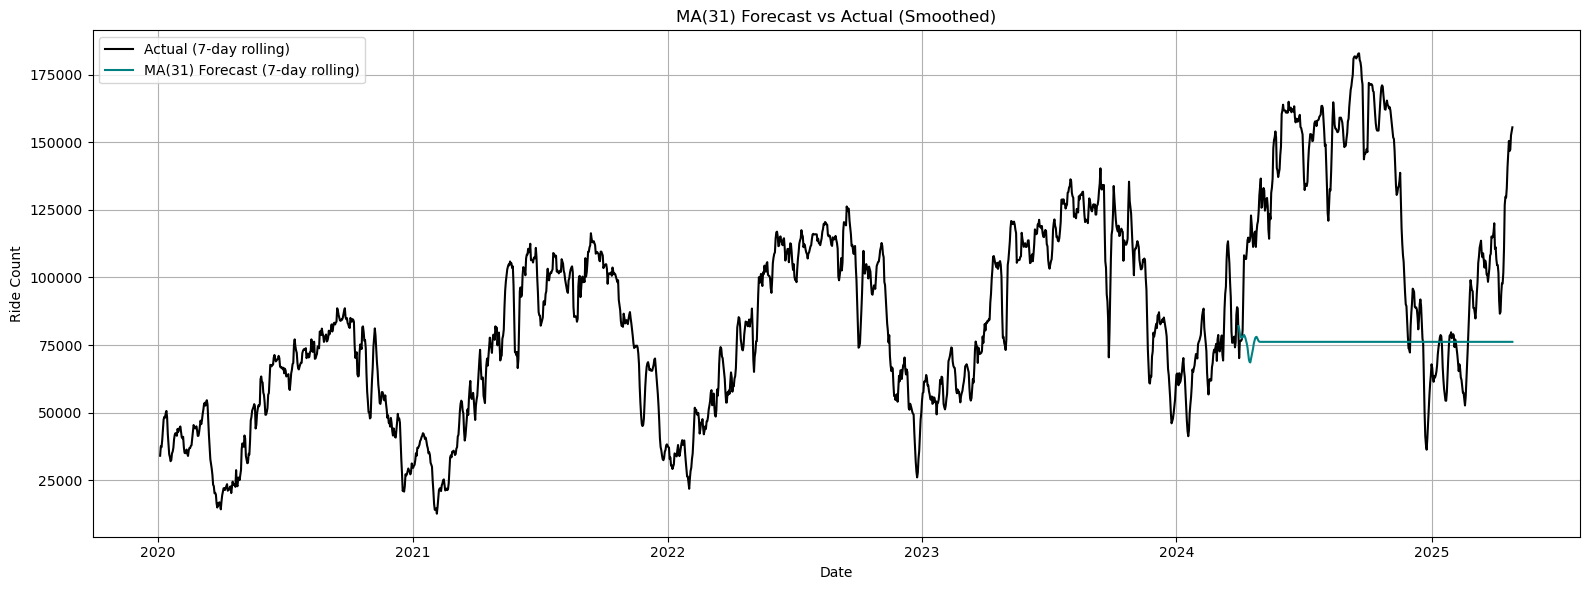

In [92]:
# Daily ride count
daily_df = citibike_df.resample('D').sum()
y = daily_df['ride_count']
train = y[:-400]
test = y[-400:]

# tried with 7 and 3, little to no change in error
ma_model = ARIMA(train, order=(0, 0, 31)).fit()
ma_forecast = ma_model.forecast(steps=len(test))
ma_forecast = pd.Series(ma_forecast, index=test.index)

# Evaluation
rmse = np.sqrt(mean_squared_error(test, ma_forecast))
mae = mean_absolute_error(test, ma_forecast)
r2 = r2_score(test, ma_forecast)

print("MA")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2 * 100:.3f}%")

# Plot (7-day rolling)
y_smooth = y.rolling(7, center=True).mean()
y_pred_smooth = ma_forecast.rolling(7, center=True).mean()

plt.figure(figsize=(16,6))
plt.plot(y_smooth, label="Actual (7-day rolling)", color='black')
plt.plot(y_pred_smooth, label="MA(31) Forecast (7-day rolling)", color='teal')
plt.title("MA(31) Forecast vs Actual (Smoothed)")
plt.xlabel("Date")
plt.ylabel("Ride Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Observations

- Visual Analysis
    - The MA(31) forecast fails to react to changes in the test data and stays almost flat
    - It is not able to capture seasonality and trend with the predicted line showing little to no alightment with the actual ride counts
- Model Metrics
    - RMSE: 62,974.27
        - On par with the worst preforming model (mean forecast)
    - MAE: 53,621.82
        - Follows the same trend as RMSE, with higher error penalties also showing high level of average difference between predicted and actual
    - R^2: -124.66%
        - Similar to some of the other models, with a negative R^2 score, the model prediction abilility was worse than guessing the mean

Interpretation of Results

Despite theoretically, MA sounds like a plausible model to use, it preformed poorly in the context of this dataset. With the data having strong seasonality and trend, it makes it unsuitable for models that only use past error terms. The models inability to learn from actual observed values means that it could not handle the strucutre of this data. Once again, this provides further proof that the MA on its own, much like other models, it not enough to capture the full story of this data. 

# 18. ARMA

As a combination of AR and MA, the ARMA model was also implemented to check wether both components (past values & past errors) combined can provide better performance in forecasting. A lag of 31 was selected for both AR and MA components to incorporate a full months worth of history and its errors

- Purpose
    - Explore the combined effects of AR and MA on forecasting performance
    - To explain more specifically, to investigate whether using both past values and residuals give better predictions than using either one alone
    - To use the results of the model as a bridge towards more complex models
- Feature Selection
    - ride counts aggregated to daily
    - model order set at (31,0,31) indicating 31 AR lags and 31 MA lags
    - shorter lags of 7 and 3 were also tested but had minimal and worse performance effects on the data
- Model Training
    - 80% of the dataset was for training while 20% was for testing (approximately the last 400 days)
    - an ARIMA model with order (31,0,31) was used to reflect ARMA with a lag value of 31 for both

/Users/satvikkonda/anaconda3/envs/Info1/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/satvikkonda/anaconda3/envs/Info1/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/satvikkonda/anaconda3/envs/Info1/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 54532.73
MAE: 46407.41
R²: -68.466%


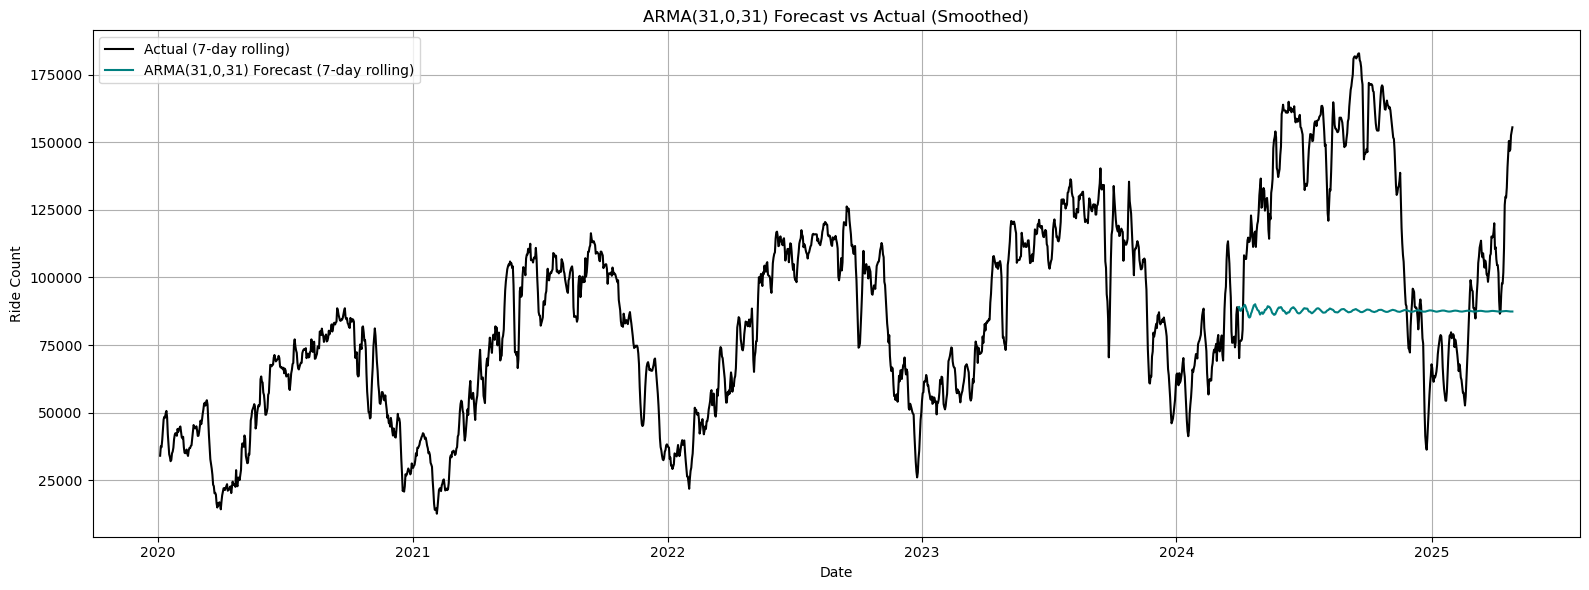

In [93]:
# Daily ride count
daily_df = citibike_df.resample('D').sum()
y = daily_df['ride_count']
train = y[:-400]
test = y[-400:]

# tried with 7 and 3, little to no change in error
ma_model = ARIMA(train, order=(31, 0, 31)).fit()
ma_forecast = ma_model.forecast(steps=len(test))
ma_forecast = pd.Series(ma_forecast, index=test.index)

# Evaluation
rmse = np.sqrt(mean_squared_error(test, ma_forecast))
mae = mean_absolute_error(test, ma_forecast)
r2 = r2_score(test, ma_forecast)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2 * 100:.3f}%")

# Plot (7-day rolling)
y_smooth = y.rolling(7, center=True).mean()
y_pred_smooth = ma_forecast.rolling(7, center=True).mean()

plt.figure(figsize=(16,6))
plt.plot(y_smooth, label="Actual (7-day rolling)", color='black')
plt.plot(y_pred_smooth, label="ARMA(31,0,31) Forecast (7-day rolling)", color='teal')
plt.title("ARMA(31,0,31) Forecast vs Actual (Smoothed)")
plt.xlabel("Date")
plt.ylabel("Ride Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Observations

- Visual Analysis
    - The forecast line showed a low amplitude, wave-like pattern that vanishes and stays mostly disconnected from the actual ride count behavior
    - Though more complex than the standard AR or MA, the added complexity failed to capture the trend and seasonality of the data in its predictions
- Model Metrics
    - RMSE: 54,532.73
        - Slight imporvement can be seen based on the RMSE compared to AR and MA but still significantly off against Holt-Winters
    - MAE: 46,407.41
        - Again, slight improvement but incomparable with models that use seasonality
    - R^2: -68.47%
        - Indicates severe underperformance with it being negative which means the model explain less than 0% of the variance (worse than guessing the mean)

Interpretation of Results

Despite combining AR and MA, the ARMA model still underperforms heavily. As mentioned many times before, the dataset had significant seasonal/trend patterns as well as non-linear short term patterns which ARMA fundamentally cannot model. The wave-like pattern may suggest overfitting due to the lag values bur regardless, this once again proves that seasonal components have to added to the model to get meaningful forecasts

# 19. ARIMA

As the bike rental data is non-stationary and most previous models deal with only stationary data, ARIMA was implemented to convert the non-stationary data into stationary, which AR and MA can deal with. This model is builds on the ARMA model by intrducing differencing (d=1) to remove trend and balance the mean, which is essential for AR and MA to work. 

- Purpose
    - Improve upon the ARMA model by introducing differencing to handle and remove the upward trend
    - To check if the combination of trend removal, past values, and past errors can increase the models prediction accuracy
    - To use the results of this model to bridge into more complex models such as SARIMA
- Feature Selection
    - ride counts aggregated to daily
    - ARIMA parameters:
        - p=31: include past 31 days of observation
        - d=1: difference the data once to remove trend
        - q=31: include past 31 days of forecasting errors
    - Alternate values of p and q (3 and 7) were tested but had little to no improvement over 31
    - differencing was kept at 1 as the assumption was that the trend was simple enough that doing it once was sufficient
- Model Training
    -  80% of the dataset was for training while 20% was for testing (approximately the last 400 days)
    - finally, the full version of ARIMA was used with order (31,1,31)

/Users/satvikkonda/anaconda3/envs/Info1/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/satvikkonda/anaconda3/envs/Info1/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/satvikkonda/anaconda3/envs/Info1/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 47907.10
MAE: 41364.97
R²: -30.016%


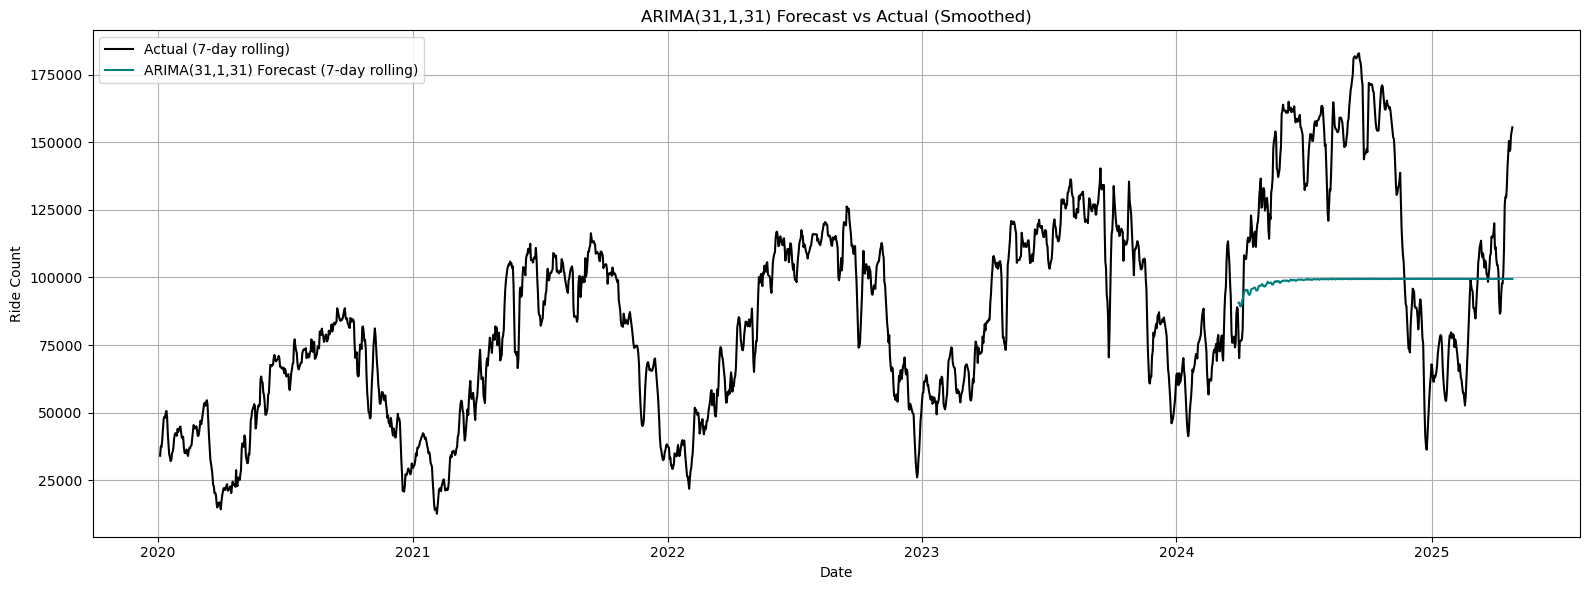

In [94]:
# Daily ride count
daily_df = citibike_df.resample('D').sum()
y = daily_df['ride_count']
train = y[:-400]
test = y[-400:]

# tried with 7 and 3, little to no change in error
ma_model = ARIMA(train, order=(31, 1, 31)).fit()
ma_forecast = ma_model.forecast(steps=len(test))
ma_forecast = pd.Series(ma_forecast, index=test.index)

# Evaluation
rmse = np.sqrt(mean_squared_error(test, ma_forecast))
mae = mean_absolute_error(test, ma_forecast)
r2 = r2_score(test, ma_forecast)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2 * 100:.3f}%")

# Plot (7-day rolling)
y_smooth = y.rolling(7, center=True).mean()
y_pred_smooth = ma_forecast.rolling(7, center=True).mean()

plt.figure(figsize=(16,6))
plt.plot(y_smooth, label="Actual (7-day rolling)", color='black')
plt.plot(y_pred_smooth, label="ARIMA(31,1,31) Forecast (7-day rolling)", color='teal')
plt.title("ARIMA(31,1,31) Forecast vs Actual (Smoothed)")
plt.xlabel("Date")
plt.ylabel("Ride Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Observations

- Visual Analysis
    - The forecast line shows a flattened response with very minimal trend changes in the early stages of forecasting
    - While it was slightly more dynamic than ARMA, this model still remains unable to react to the seasonality of the data
- Model Metrics
    - RMSE: 47,907.10
        - Slight improvement over ARMA and even models such as naive and mean, suggesting that even slight trend capturing does help model performance
    - MAE: 41,364.97
        - the MAE value is significantly closer to the RMSE compared to other models showing that the predictions were consistent without big mistakes (even if prediction is wrong)
    - R^2: -30.02%
        - Still, similar to most models before this one, it performs worse than guessing the mean

Interpretation of Results

ARIMA(31,1,31) gives us the crucial insight that differencing alone (alongside AR and MA) is not enough when there is strong seasonal patterns in the data. While the model did benefit slightly from trend removal, it remains incapable of adapting to seasonal changes and short-term spikes in the data. This again shows the need for incorporating seasonality in the model for better accuracy

# 20. SARIMA

To better capture the observed patterns of seasonality in the data, a SARIMA model was implemented next which extends the ARIMA model by including seasonality, which is significant given the bike rental data.

- Purpose
    - Build on top of ARIMA by bringing in seasonal differencing to take care of reapeating patterns in the data
    - To check whther using both trend and seasonality improves performance compared to using only trend, past values, or past errors
    - A benchmark test before moving into more complex models
- Feature Selection
    - Ride counts aggregated to daily
    - SARIMA Parameters:
        - order(p,d,q): (3,1,3)
        - seasonal order (P,D,Q,s): (1,1,1,31) for monthly seasonality
        - differencing (d=1, D=1) to remove both seasonal and trend components from the data
        - Ideally 365 (yearly seasonality) would have been the perfect seasnolaity lag value to choose but due to SARIMA's computational contraints, the smaller value of 31 (monthly seasonlity) was chosen based on the analysis of AFC and PACF plots previously done
- Model Training
    -  80% of the dataset was for training while 20% was for testing (approximately the last 400 days)
    - SARIMA(3,1,3)(1,1,1,31) fit against the SARIMAX model using statsmodels

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08550D+01    |proj g|=  8.97506D-02

At iterate    5    f=  1.08041D+01    |proj g|=  9.69492D-02

At iterate   10    f=  1.07930D+01    |proj g|=  8.28956D-03

At iterate   15    f=  1.07928D+01    |proj g|=  1.20322D-03

At iterate   20    f=  1.07927D+01    |proj g|=  1.49682D-02

At iterate   25    f=  1.07920D+01    |proj g|=  1.80297D-02

At iterate   30    f=  1.07920D+01    |proj g|=  4.79768D-04

At iterate   35    f=  1.07919D+01    |proj g|=  4.62729D-03

At iterate   40    f=  1.07892D+01    |proj g|=  6.92470D-02

At iterate   45    f=  1.07885D+01    |proj g|=  1.63432D-02


/Users/satvikkonda/anaconda3/envs/Info1/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.07884D+01    |proj g|=  1.88393D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     84      1     0     0   1.884D-02   1.079D+01
  F =   10.788388522933834     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
SARIMA(3,1,3)(1,1,1,7):
RMSE: 50495.04
MAE: 44263.50
R²: -45.394%


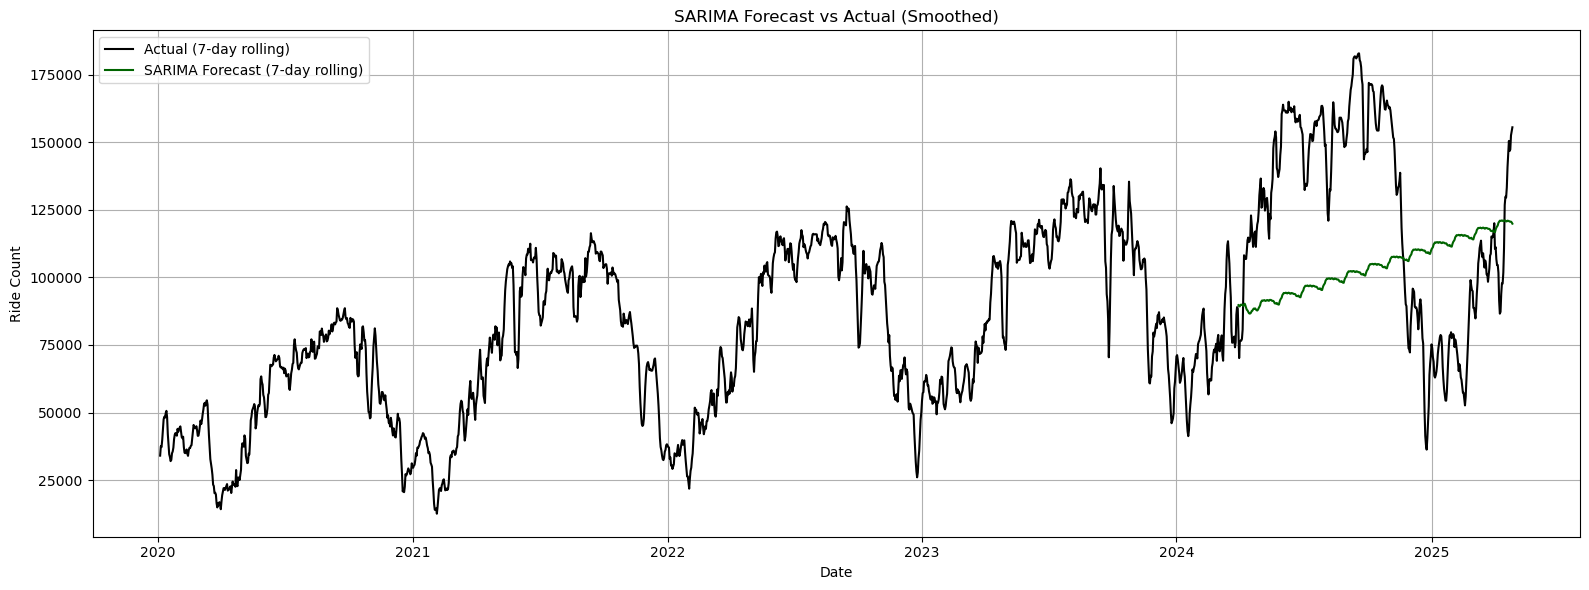

In [66]:
# Daily ride count
daily_df = citibike_df.resample('D').sum()
y = daily_df['ride_count']
train = y[:-400]
test = y[-400:]

# Fit SARIMA(3,1,3)(1,1,1,365)
sarima_model = SARIMAX(
    train,
    order=(3, 1, 3),
    seasonal_order=(1, 1, 1, 31),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

# Forecast
sarima_forecast = sarima_model.forecast(steps=len(test))
sarima_forecast = pd.Series(sarima_forecast, index=test.index)

# Evaluation
rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
mae = mean_absolute_error(test, sarima_forecast)
r2 = r2_score(test, sarima_forecast)

print("SARIMA(3,1,3)(1,1,1,7):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2 * 100:.3f}%")

# Plot (7-day rolling)
y_smooth = y.rolling(7, center=True).mean()
forecast_smooth = sarima_forecast.rolling(7, center=True).mean()

plt.figure(figsize=(16,6))
plt.plot(y_smooth, label="Actual (7-day rolling)", color='black')
plt.plot(forecast_smooth, label="SARIMA Forecast (7-day rolling)", color='darkgreen')
plt.title("SARIMA Forecast vs Actual (Smoothed)")
plt.xlabel("Date")
plt.ylabel("Ride Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Observations

- Visual Analysis
    - The forecast captures the general upwards trend better than previous models but does not align closely with the sharp short-term in the actual data
    - Compared to ARIMA, SARIMA shows periodic fluctuations which shows that its trying to capture seasonality was was unable or underestiamted the actual data's fluctuations (seasonality)
- Model Metrics
    - RMSE: 50,495, MAE: 44,263.50
        - Both values are slightly higher than ARIMA, showing lower prediction accuracy despite including the seasonal components
    - R^2: -45.394%
        - the negative R^2 value, similar to the rest, shows that the model performs worse than simply predicting the mean
     
Interpretation of Results

SARIMA(3,1,3)(1,1,1,31) confirms that capturing seasonality alone is not enough possibly due to the high fluctuations of the data. Although surprising, some reasons why this model performed bad may be due to the tuning methodology of all the parameters as Holt-Winters showed that seasonality does play a big part in the models accuracy. This does not mean that seasonality is still the only thing that is enough but to capture further patterns and get higher accuracy values, it may be that introducing outside variables might help the model be accurate even further

# 21. ARIMAX

Unlike ARIMA and SARIMA which operate solely on historical data ride counts, ARIMAX introduces external (exogenous) variables to the model. In this case, weather related features which was previously analyzed, was included to explain both the trend/seasonality as well as the short-term spikes. More specifically temperature, wind speed, snow depth, precipitation, and cloud cover are variables that were included given the correlation analysis done. This makes ARIMAX suitable for scenarios where environmental factors can influence the data

- Purpose
    - Extend ARIMA to incorporate exogenous weather variables
    - Check how well weather related variables explain and predict ride count patterns
    - Compare preformance against ARIMA and SARIMA
- Feature Selection
    - Ride counts aggregated to daily
    - Exogenous Variables:
        - Temperature, Windspeed, Snow depth, precipitation, cloud cover
    - ARIMAX parameters:
        - order = (2,1,2)
- Model Training
    - 80% of the dataset was for training while 20% was for testing (approximately the last 400 days)
    - Model trained using SARIMAX but with seasonal order turned off with the trend order being (2,1,2)

ARIMAX(2,1,2):
RMSE: 32609.96
MAE: 27096.56
R²: 39.361%


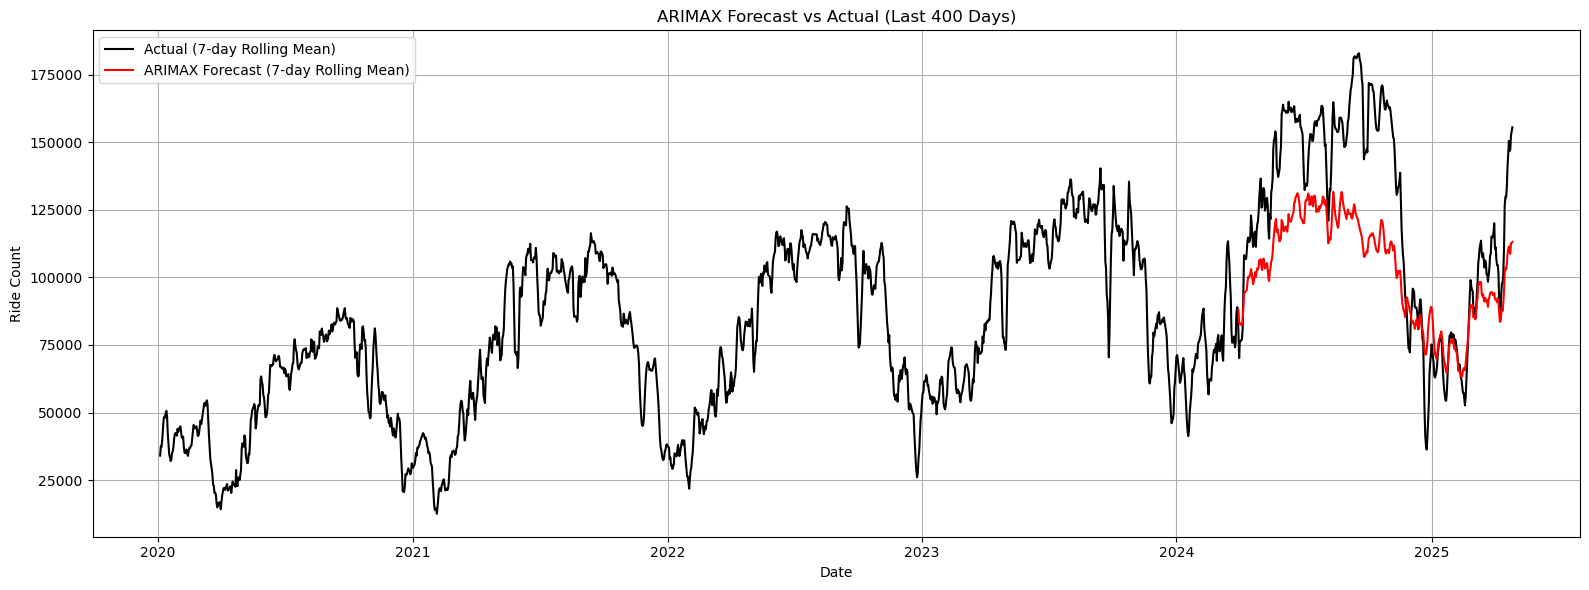

In [68]:
# Resample data daily
y = citibike_df['ride_count'].resample('D').sum()
X = citibike_df[['temperature_2m', 'windspeed_10m', 'snow_depth', 'precipitation', 'cloudcover']].resample('D').mean()

# Train-test split (keep last 400 days as test)
y_train, y_test = y[:-400], y[-400:]
X_train, X_test = X[:-400], X[-400:]

# Fill any missing values
X_train = X_train.ffill().bfill()
X_test = X_test.ffill().bfill()

# Fit ARIMAX model (no seasonality)
model = SARIMAX(
    y_train,
    exog=X_train,
    order=(2, 1, 2),             # You can change (p,d,q)
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)

# Forecast
y_pred = results.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

# Rolling means for plotting
y_actual_smooth = y.rolling(window=7, center=True).mean()
y_pred_smooth = y_pred.rolling(window=7, center=True).mean()


# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("ARIMAX(2,1,2):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2 * 100:.3f}%")

# Plot
plt.figure(figsize=(16, 6))
plt.plot(y_actual_smooth, label='Actual (7-day Rolling Mean)', color='black')
plt.plot(y_pred_smooth, label='ARIMAX Forecast (7-day Rolling Mean)', color='red')
plt.title('ARIMAX Forecast vs Actual (Last 400 Days)')
plt.xlabel('Date')
plt.ylabel('Ride Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Observations

- Visual Analysis
    - The forecast closely tracks the overall shape of the test data, with moderate similarity with the short-term spikes
    - Compared to SARIMA, the ARIMAX significantly models the data better with both seasonality and external disruptions which may have captured by the exogenous variables
    - Does not seem to accurately capture the overall trend of the overall data, possibly due to the model capturing seasonality of the weather varibales but not the data itself
- Model Metrics
    - RMSE: 32,609.96, MAE: 27,096.56
        - the values are significantly less than ARIMA and SARIMA, suggesting that the exogenous variables caused the model to make better predictions
    - R^2: 39.361%
        - Although not up to standard, the score is relatively high compared to the previous models, showing significant improvement over models that have not used exogenous variables
     
Interpretation of Results

ARIMAX(2,1,2) clearly benefits from the inclusion of weather feautres, which seem to carry meaningful information about the ride counts. Unlike previous models, it gave us a useful forecast where we can confidently say that this data does not depend on previous values but rather external variables. These insights now shows that the weather variables are crucial for any further modeling that may be done for improving performance. 

# 22. SARIMAX

To build a forecasting model that captures both aspects of bike rental demand and the influence of outside variables (weather), I implemented a SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) model.

- Purpose
    - SARIMAX extends the ARIMA model where SARIMAX has the ability to handle seasonality, which is important given the weekly and yearly patterns identified through this entire notebook
    - By allowing the model in intake exogenous variables (weather variables), it can improve the models forecasting performance by acounting for external influences
- Feature Selection
    -  Target variable: ride_count aggregated to daily
    -  Weather features: temperature_2m, windspeed_10m, snow_depth, precipitation, cloudcover (aggregated to daily and filled to handle missing values)
- Model Training
    - The data was split into 80% training set and 20% test set
    - Order was set at (1,1,1)
        - p = 1: model uses lag 1 to predict current value
        - q = data differenced one to make it stationary
        - r = model uses 1 lag for the error term into the prediction
    - Seasonal order was set at (1,1,1,7)
        - P, Q, and R values same as the order but S set to 7 to capture weekly seasonality
- Forecasting and Plotting
    - Predictions were made on the test set, using weather data as exogenous inputs
    - Although the prediction and training was done on the original noisy data, a 7 day rolling mean was used after for visualization purposes.
    - The plot then displays the original data, and the predicted data
- Performance Metrics
    - Same as previous model

In [69]:
# Resample data daily
y = citibike_df['ride_count'].resample('D').sum()
X = citibike_df[['temperature_2m', 'windspeed_10m','snow_depth','precipitation','cloudcover']].resample('D').mean()

# Train-test split 
train_size = int(len(y) * 0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]

X_train = X_train.ffill().bfill()
X_test = X_test.ffill().bfill()

# Fit SARIMAX model
model = SARIMAX(y_train, exog=X_train, order=(3,1,3), seasonal_order=(1,1,1,31))  # You can tune order
results = model.fit(disp=False)

/Users/satvikkonda/anaconda3/envs/Info1/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [70]:
model = SARIMAX(y_train, exog=X_train, order=(3,1,3), seasonal_order=(1,1,1,31))
results = model.fit(disp=False)

y_pred = results.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

/Users/satvikkonda/anaconda3/envs/Info1/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


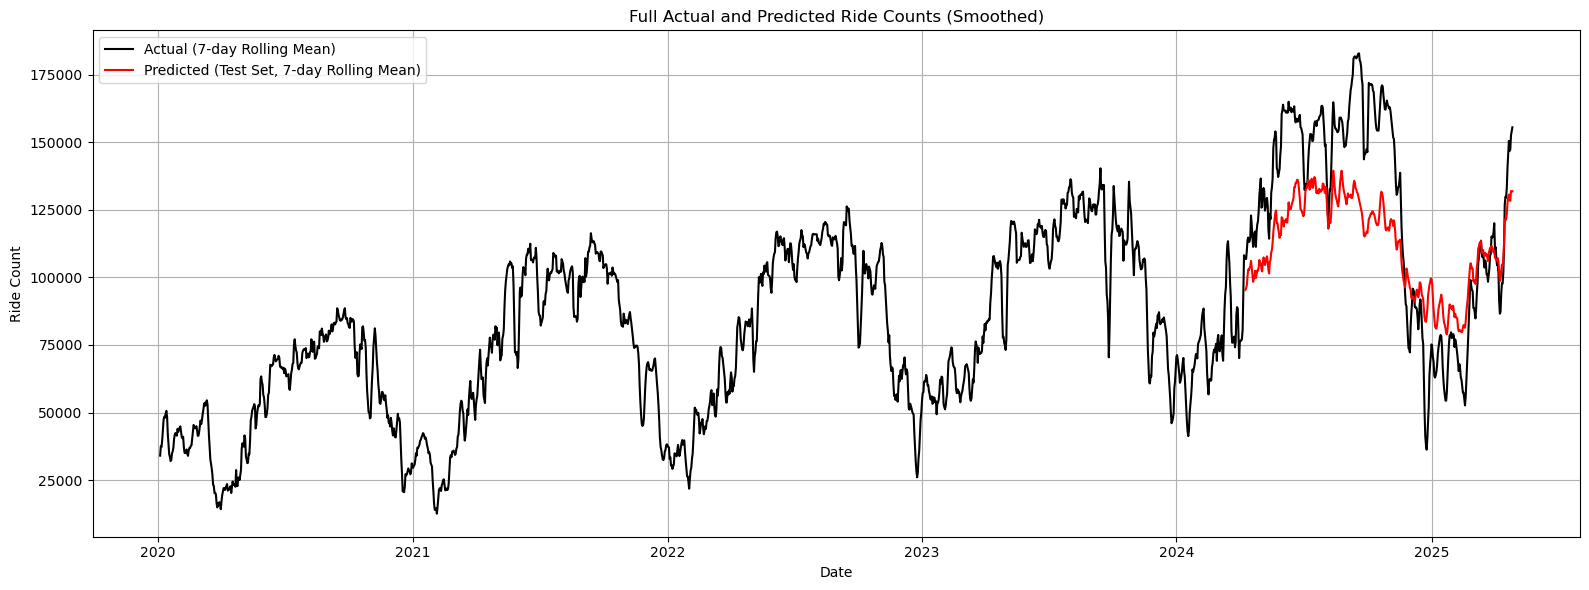

In [71]:
y_smooth = y.rolling(window=7, center=True).mean()
y_pred_smooth = y_pred.rolling(window=7, center=True).mean()

plt.figure(figsize=(16, 6))
plt.plot(y_smooth, label='Actual (7-day Rolling Mean)', color='black')
plt.plot(y_pred_smooth, label='Predicted (Test Set, 7-day Rolling Mean)', color='red')
plt.title('Full Actual and Predicted Ride Counts (Smoothed)')
plt.xlabel('Date')
plt.ylabel('Ride Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [324]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R²: {r2 * 100:.3f}%")

Test RMSE: 32988.26
Test MAE: 27577.78
Test R²: 37.042%


### Observations

Visual Analysis
- From the plot, the predicted ride counts shown in red captured the general seasonal trends observed by the actual data (black line). The model also was able to follow the upward and downward trend from the test set. However, the predictions ended up underestimating the peaks and instead smoothed out sharp changes in the actual ride counts.

Model Metrics
- RMSE: 32899.26
    - This value shows that there is a high average of error magnitudes suggesting that while the model was able to capture trend and seasonality, it struggles with precise data points
- MAE: 27577.78
    - On average, the model predicted values that deaviated from the actual ride counts by around 27,000 rides per day
- R^2: 37.042%
    - The model was able to explain 37% of the test data. This does show some strength in how the model was able to predict the test data but it leave a lot of room for improvement
 
Interpretation of Results
- While SARIMAX was able to model the general seasonality and trend, it still struggled to capture complex short term components. This could be due to the limitations of this linear model such as non-linear relationships and anomalies that are outside of the trend and seasonality.

To better model the complex, non-linear and weak linear relationships that is in the data and the weather features, I will next explore different types of MLP models

# 23. Univariate MLP

To move beyond statistical models be able to capture non-linear patterns in the data, a feedforwards neural network (MLP) was implemented. The univariate version of MLP uses only its own past values to predict the next day's values, without using any external variables. This design focuses only on the structure of the data itself. 

- Purpose
    - exploring deep learning approaches for forecasting without relying on weather variables
    - To check whether non-linear modeling of lagged ride counts can outperform traditional models that do use weather variables
    - Baseline model for more complex nueral network architectures used later
- Feature Selection
    - Ride counts aggregated to daily
    - Lag features: past 30 days used as input features (from 1 to 30, simulating a month)
- Model Training
    -  The data was split into 80% training set and 20% test set (last 400 days used for testing)
    -  Neural Network structure
        - Input: 30 nodes correlating to 30 days of bike rental data
        - Hidden Layers: 64 -> 32 with ReLU
        - Output: 1 node
    - Optimizer: Adam with learning rate of 0.001
    - Trained over 560 epochs. This number was chosen after testing many differeny values between 50 and 1500 

In [140]:
citibike_uvmlp_df = citibike_df.sort_index()
citibike_uvmlp_df = citibike_uvmlp_df[~citibike_uvmlp_df.index.duplicated(keep='first')]
citibike_uvmlp_df = citibike_uvmlp_df.asfreq("h").ffill().bfill()

ride_count_daily_uvmlp = citibike_uvmlp_df['ride_count'].resample('D').sum().ffill()

# Step 2: Create lag features
def create_lagged_dataset_uvmlp(series, lag=30):
    X, y = [], []
    for i in range(lag, len(series)):
        X.append(series[i-lag:i])
        y.append(series[i])
    return np.array(X), np.array(y)

X_uvmlp_all, y_uvmlp_all = create_lagged_dataset_uvmlp(ride_count_daily_uvmlp.values, lag=30)

In [141]:
X_uvmlp_train, X_uvmlp_test = X_uvmlp_all[:-400], X_uvmlp_all[-400:]
y_uvmlp_train_raw, y_uvmlp_test_raw = y_uvmlp_all[:-400], y_uvmlp_all[-400:]

scaler_uvmlp_X = MinMaxScaler()
scaler_uvmlp_y = MinMaxScaler()

X_uvmlp_train_scaled = scaler_uvmlp_X.fit_transform(X_uvmlp_train)
X_uvmlp_test_scaled = scaler_uvmlp_X.transform(X_uvmlp_test)

y_uvmlp_train = scaler_uvmlp_y.fit_transform(y_uvmlp_train_raw.reshape(-1, 1))
y_uvmlp_test = scaler_uvmlp_y.transform(y_uvmlp_test_raw.reshape(-1, 1))

In [142]:
X_uvmlp_train_tensor = torch.tensor(X_uvmlp_train_scaled, dtype=torch.float32)
y_uvmlp_train_tensor = torch.tensor(y_uvmlp_train, dtype=torch.float32).view(-1, 1)
X_uvmlp_test_tensor = torch.tensor(X_uvmlp_test_scaled, dtype=torch.float32)
y_uvmlp_test_tensor = torch.tensor(y_uvmlp_test, dtype=torch.float32).view(-1, 1)

uvmlp_train_dataset = TensorDataset(X_uvmlp_train_tensor, y_uvmlp_train_tensor)
uvmlp_train_loader = DataLoader(uvmlp_train_dataset, batch_size=32, shuffle=True)

In [143]:
class UnivariateMLP(nn.Module):
    def __init__(self, input_size):
        super(UnivariateMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

uvmlp_model = UnivariateMLP(input_size=30)
uvmlp_criterion = nn.MSELoss()
uvmlp_optimizer = optim.Adam(uvmlp_model.parameters(), lr=0.001)

In [144]:
uvmlp_train_losses = []
uvmlp_val_losses = []

for epoch in range(560):
    uvmlp_model.train()
    epoch_loss = 0
    for batch_X, batch_y in uvmlp_train_loader:
        uvmlp_optimizer.zero_grad()
        output = uvmlp_model(batch_X)
        loss = uvmlp_criterion(output, batch_y)
        loss.backward()
        uvmlp_optimizer.step()
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(uvmlp_train_loader)
    uvmlp_train_losses.append(avg_train_loss)
    
    uvmlp_model.eval()
    with torch.no_grad():
        val_output = uvmlp_model(X_uvmlp_test_tensor)
        val_loss = uvmlp_criterion(val_output, y_uvmlp_test_tensor).item()
        uvmlp_val_losses.append(val_loss)
    
    if (epoch+1) % 10 == 0:
        print(f"[UVMLP] Epoch {epoch+1}/560 - Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss:.4f}")

[UVMLP] Epoch 10/560 - Train Loss: 0.0117 - Val Loss: 0.0215
[UVMLP] Epoch 20/560 - Train Loss: 0.0113 - Val Loss: 0.0187
[UVMLP] Epoch 30/560 - Train Loss: 0.0108 - Val Loss: 0.0189
[UVMLP] Epoch 40/560 - Train Loss: 0.0105 - Val Loss: 0.0177
[UVMLP] Epoch 50/560 - Train Loss: 0.0106 - Val Loss: 0.0182
[UVMLP] Epoch 60/560 - Train Loss: 0.0100 - Val Loss: 0.0178
[UVMLP] Epoch 70/560 - Train Loss: 0.0100 - Val Loss: 0.0207
[UVMLP] Epoch 80/560 - Train Loss: 0.0099 - Val Loss: 0.0183
[UVMLP] Epoch 90/560 - Train Loss: 0.0093 - Val Loss: 0.0182
[UVMLP] Epoch 100/560 - Train Loss: 0.0092 - Val Loss: 0.0189
[UVMLP] Epoch 110/560 - Train Loss: 0.0088 - Val Loss: 0.0189
[UVMLP] Epoch 120/560 - Train Loss: 0.0087 - Val Loss: 0.0195
[UVMLP] Epoch 130/560 - Train Loss: 0.0085 - Val Loss: 0.0200
[UVMLP] Epoch 140/560 - Train Loss: 0.0081 - Val Loss: 0.0205
[UVMLP] Epoch 150/560 - Train Loss: 0.0082 - Val Loss: 0.0219
[UVMLP] Epoch 160/560 - Train Loss: 0.0077 - Val Loss: 0.0197
[UVMLP] Epoch 170

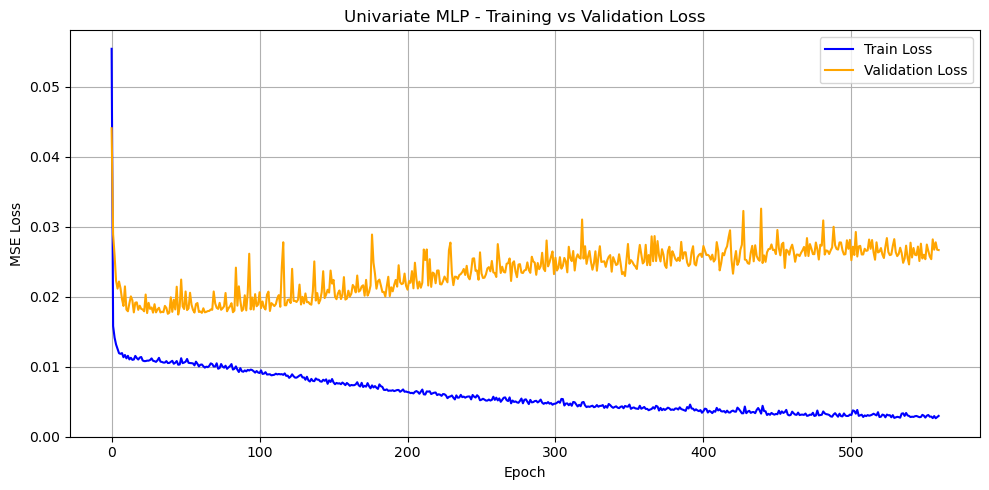

In [145]:
plt.figure(figsize=(10, 5))
plt.plot(uvmlp_train_losses, label='Train Loss', color='blue')
plt.plot(uvmlp_val_losses, label='Validation Loss', color='orange')
plt.title("Univariate MLP - Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [146]:
uvmlp_model.eval()
with torch.no_grad():
    y_uvmlp_pred_tensor = uvmlp_model(X_uvmlp_test_tensor)
y_uvmlp_pred = y_uvmlp_pred_tensor.numpy().flatten()

y_uvmlp_pred_rescaled = scaler_uvmlp_y.inverse_transform(y_uvmlp_pred.reshape(-1, 1)).flatten()
y_uvmlp_test_rescaled = scaler_uvmlp_y.inverse_transform(y_uvmlp_test).flatten()

In [147]:
uvmlp_rmse = np.sqrt(mean_squared_error(y_uvmlp_test_rescaled, y_uvmlp_pred_rescaled))
uvmlp_mae = mean_absolute_error(y_uvmlp_test_rescaled, y_uvmlp_pred_rescaled)
uvmlp_r2 = r2_score(y_uvmlp_test_rescaled, y_uvmlp_pred_rescaled)

print("\n[Univariate MLP Evaluation]")
print(f"RMSE: {uvmlp_rmse:.2f}")
print(f"MAE: {uvmlp_mae:.2f}")
print(f"R²: {uvmlp_r2 * 100:.2f}%")


[Univariate MLP Evaluation]
RMSE: 25738.35
MAE: 18450.95
R²: 62.47%


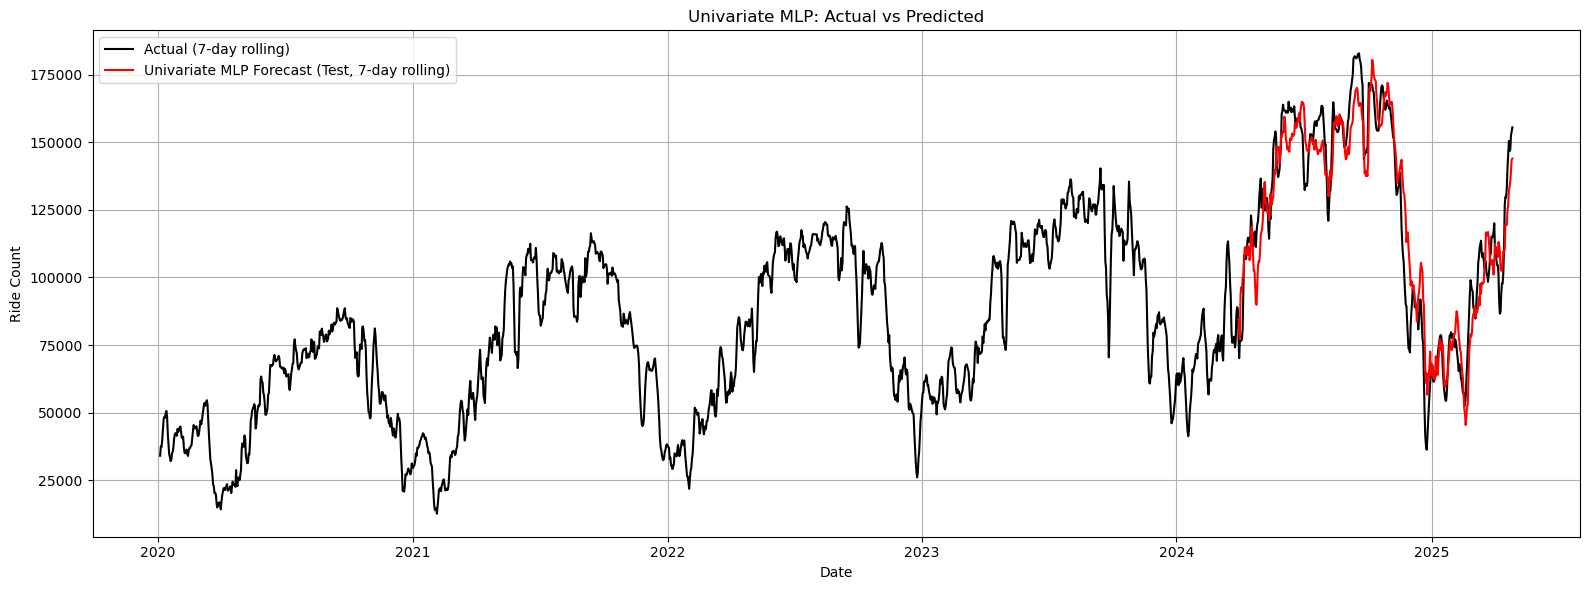

In [148]:
full_actual_smooth_uvmlp = ride_count_daily_uvmlp.rolling(7, center=True).mean()
index_test_uvmlp = ride_count_daily_uvmlp.index[-400:]
pred_smooth_uvmlp = pd.Series(y_uvmlp_pred_rescaled, index=index_test_uvmlp).rolling(7, center=True).mean()

plt.figure(figsize=(16, 6))
plt.plot(full_actual_smooth_uvmlp, label='Actual (7-day rolling)', color='black')
plt.plot(pred_smooth_uvmlp, label='Univariate MLP Forecast (Test, 7-day rolling)', color='red')
plt.title("Univariate MLP: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Ride Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Observations

- Visual Analysis
    - Forecast does follow the shape and amplitude of the actual values very well
    - Unlike previous models, the MLP adapts well to the short-term spikes, especially during the seasonal surges
    - In terms of the training and test loss plot, the model doesn't converge fully but stays somewhat stagnant meaning that further training would have overfitted the model
- Model Metrics
    - RMSE: 25,738.35, MAE: 18,450.95
        - Out of all the models so far, this one has the lowest RMSE and MAE values, indicating accurate predictions
    - R^2: 62.47%
        - this score, which is significantly higher than any before, shows substantial prediction power compared to the linear and statistical models
     
Interpretation of Results

The univariate MLP shows that deep learning models, even when trained in a single variable, can significantly outpreform linear and traditional statistical models as it can capture non-linear patterns. Its success without external inputs suggests that there are strong underlying patterns that are not fully visible through visual anaylsis alone. On the other hand, this may also mean that models such as ARIMAX and SARIMAX where external variables were used did worse than this one due to the weather variables not being relavent. Therefore, this validates further modeling into understanding how non-linear models perform given external variables

# 24. Multivariate MLP

After establishing that a simple linear model such as SARIMAX can do predictions to a certain level, using a more complex model can improve results. Therefore, we transition into a Multivariate MLP model to capture non-linear relationships between bike rental demand, weather variables, and calendar attributes

- Purpose
    - MLPs are flexible neural networks which can model complex non-linear interactions that traditional time series models like SARIMAX may not capture. Because there are complex interations between bike rental demand and other variables (weather), MLP is the next step to improve performance in prediction
- Feature Engineering
    - Unlike SARIMAX where receiving good prediction results requires giving it linearly correlated input features and not confuse it, a comprehesive set of input features were used for MLP
    - Weather features: temperature_2m, windspeed_10m, snow_depth, precipitation, cloudcover
    - Calendar features: day of the week, month, year, week of the year, weekend indicator (chosen based on seasonal analysis and AFC/PAFC plots)
    - Lag features: lag_1 and lag_7 created to incorporate short term and weekly seasonality based on the bike rental counts
- Model Training
    - A simple MLP design was used where:
        - Input layer matching the number of features, two hidden layers with ReLU activations, and a single output neuron for predicting daily ride counts
    - The model was trained on 560 epochs. This number was chosen after testing a wide variety of epochs randing from 100 to 1000.
    - For the loss function, Adam optimizer and MSE was used
    - And finally, to monitor training progress, train and test losses were recorded across epochs. This was done so that I can visually see if the model was overfitting and accordingly adjust the number of epochs

In [30]:
# Resample and clean
y_mlp = citibike_df['ride_count'].resample('D').sum()
X_weather_mlp = citibike_df[['temperature_2m', 'windspeed_10m','snow_depth','precipitation','cloudcover']].resample('D').mean()
X_weather_mlp = X_weather_mlp.ffill().bfill()

# Create calendar features
calendar_df_mlp = pd.DataFrame(index=y_mlp.index)
calendar_df_mlp['dayofweek'] = y_mlp.index.dayofweek
calendar_df_mlp['month'] = y_mlp.index.month
calendar_df_mlp['year'] = y_mlp.index.year
calendar_df_mlp['weekofyear'] = y_mlp.index.isocalendar().week
calendar_df_mlp['is_weekend'] = (y_mlp.index.dayofweek >= 5).astype(int)  # 5=Saturday, 6=Sunday

# Create lag features
lag_1_mlp = y_mlp.shift(1)
lag_7_mlp = y_mlp.shift(7)

# Combine 
X_full_mlp = pd.concat([X_weather_mlp, calendar_df_mlp, lag_1_mlp.rename('lag_1'), lag_7_mlp.rename('lag_7')], axis=1)

# Drop rows with NaNs 
X_full_mlp = X_full_mlp.dropna()
y_mlp = y_mlp[X_full_mlp.index]  # Align y

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # if using GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Train-test split
train_size_mlp = int(len(y_mlp) * 0.8)
X_train_mlp = X_full_mlp.iloc[:train_size_mlp]
X_test_mlp = X_full_mlp.iloc[train_size_mlp:]
y_train_mlp = y_mlp.iloc[:train_size_mlp]
y_test_mlp = y_mlp.iloc[train_size_mlp:]

scaler_X_mlp = StandardScaler()
X_train_scaled_mlp = scaler_X_mlp.fit_transform(X_train_mlp)
X_test_scaled_mlp = scaler_X_mlp.transform(X_test_mlp)

# Scale targets
scaler_y_mlp = StandardScaler()
y_train_scaled_mlp = scaler_y_mlp.fit_transform(y_train_mlp.values.reshape(-1, 1))
y_test_scaled_mlp = scaler_y_mlp.transform(y_test_mlp.values.reshape(-1, 1))

X_train_tensor_mlp = torch.tensor(X_train_scaled_mlp, dtype=torch.float32)
X_test_tensor_mlp = torch.tensor(X_test_scaled_mlp, dtype=torch.float32)
y_train_tensor_mlp = torch.tensor(y_train_scaled_mlp, dtype=torch.float32)
y_test_tensor_mlp = torch.tensor(y_test_scaled_mlp, dtype=torch.float32)

In [31]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

model_mlp = MLP(input_dim=X_train_tensor_mlp.shape[1])

criterion_mlp = nn.MSELoss()
optimizer_mlp = torch.optim.Adam(model_mlp.parameters(), lr=0.001)


In [32]:
epochs_mlp = 560
train_losses_mlp = []
test_losses_mlp = []

for epoch in range(epochs_mlp):
    model_mlp.train()
    optimizer_mlp.zero_grad()
    outputs = model_mlp(X_train_tensor_mlp)
    loss = criterion_mlp(outputs, y_train_tensor_mlp)
    loss.backward()
    optimizer_mlp.step()
    
    # Record train loss
    train_losses_mlp.append(loss.item())

    # Evaluate on test set
    model_mlp.eval()
    with torch.no_grad():
        test_outputs = model_mlp(X_test_tensor_mlp)
        test_loss = criterion_mlp(test_outputs, y_test_tensor_mlp)
        test_losses_mlp.append(test_loss.item())

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs_mlp}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")


Epoch 10/560, Train Loss: 0.8575, Test Loss: 2.6558
Epoch 20/560, Train Loss: 0.5984, Test Loss: 2.0855
Epoch 30/560, Train Loss: 0.3372, Test Loss: 1.2417
Epoch 40/560, Train Loss: 0.1932, Test Loss: 0.5383
Epoch 50/560, Train Loss: 0.1695, Test Loss: 0.3025
Epoch 60/560, Train Loss: 0.1495, Test Loss: 0.3108
Epoch 70/560, Train Loss: 0.1408, Test Loss: 0.3462
Epoch 80/560, Train Loss: 0.1328, Test Loss: 0.3224
Epoch 90/560, Train Loss: 0.1277, Test Loss: 0.3032
Epoch 100/560, Train Loss: 0.1229, Test Loss: 0.2956
Epoch 110/560, Train Loss: 0.1189, Test Loss: 0.2857
Epoch 120/560, Train Loss: 0.1152, Test Loss: 0.2780
Epoch 130/560, Train Loss: 0.1116, Test Loss: 0.2764
Epoch 140/560, Train Loss: 0.1082, Test Loss: 0.2729
Epoch 150/560, Train Loss: 0.1049, Test Loss: 0.2705
Epoch 160/560, Train Loss: 0.1017, Test Loss: 0.2691
Epoch 170/560, Train Loss: 0.0986, Test Loss: 0.2670
Epoch 180/560, Train Loss: 0.0956, Test Loss: 0.2651
Epoch 190/560, Train Loss: 0.0928, Test Loss: 0.2637
Ep

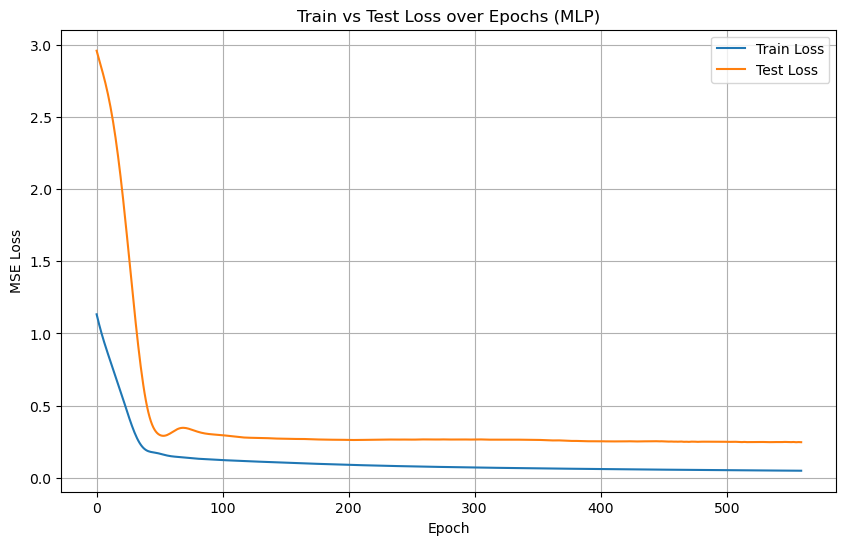

In [33]:
plt.figure(figsize=(10,6))
plt.plot(train_losses_mlp, label='Train Loss')
plt.plot(test_losses_mlp, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Train vs Test Loss over Epochs (MLP)')
plt.legend()
plt.grid()
plt.show()


In [34]:
model_mlp.eval()
with torch.no_grad():
    y_pred_scaled_mlp = model_mlp(X_test_tensor_mlp).numpy()

y_pred_mlp = scaler_y_mlp.inverse_transform(y_pred_scaled_mlp)
y_test_original_mlp = scaler_y_mlp.inverse_transform(y_test_scaled_mlp)


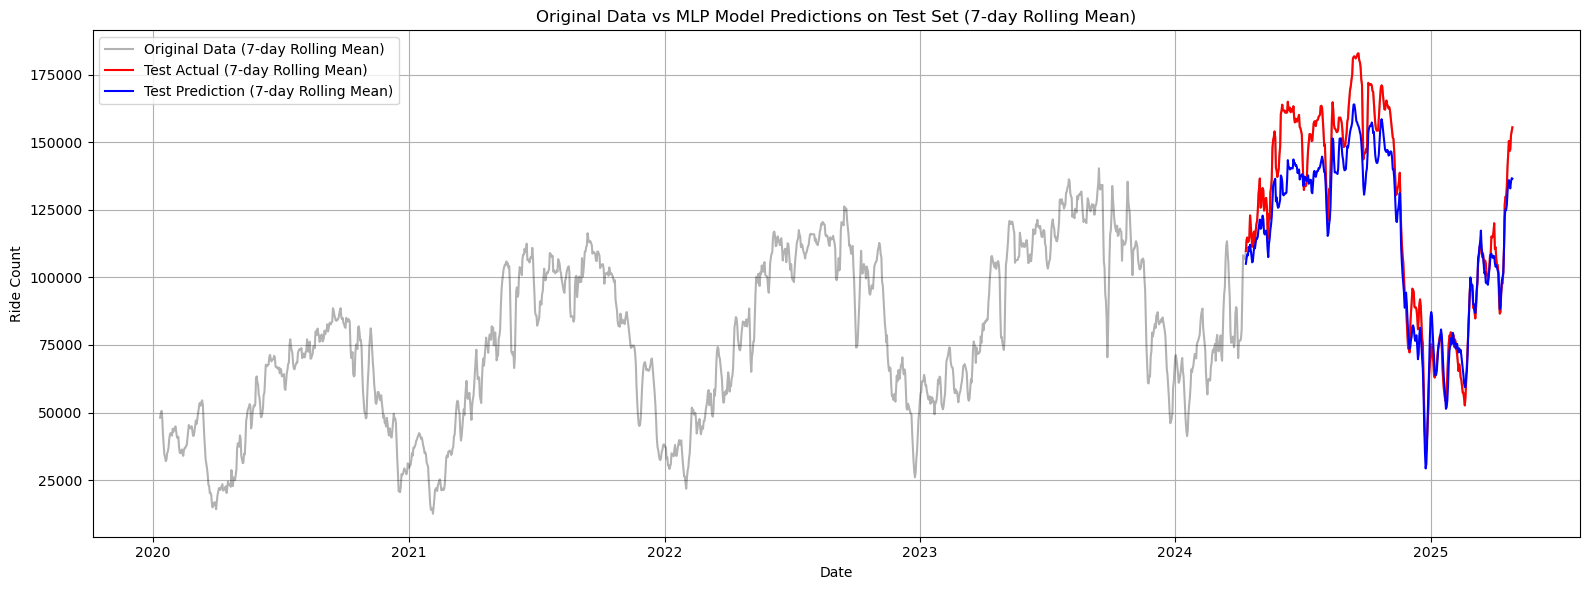

In [35]:
y_full_actual_smooth_mlp = pd.Series(y_mlp.values, index=y_mlp.index).rolling(window=7, center=True).mean()

y_test_actual_smooth_mlp = y_test_mlp.rolling(window=7, center=True).mean()
y_test_pred_smooth_mlp = pd.Series(y_pred_mlp.flatten(), index=y_test_mlp.index).rolling(window=7, center=True).mean()

# Plot
plt.figure(figsize=(16,6))
plt.plot(y_mlp.index, y_full_actual_smooth_mlp, label='Original Data (7-day Rolling Mean)', color='black', alpha=0.3)
plt.plot(y_test_mlp.index, y_test_actual_smooth_mlp, label='Test Actual (7-day Rolling Mean)', color='red')
plt.plot(y_test_mlp.index, y_test_pred_smooth_mlp, label='Test Prediction (7-day Rolling Mean)', color='blue')
plt.xlabel('Date')
plt.ylabel('Ride Count')
plt.title('Original Data vs MLP Model Predictions on Test Set (7-day Rolling Mean)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [36]:
rmse_mlp = np.sqrt(mean_squared_error(y_test_original_mlp, y_pred_mlp))
mae_mlp = mean_absolute_error(y_test_original_mlp, y_pred_mlp)
r2_mlp = r2_score(y_test_original_mlp, y_pred_mlp)

print(f"Test RMSE (MLP): {rmse_mlp:.2f}")
print(f"Test MAE (MLP): {mae_mlp:.2f}")
print(f"Test R² (MLP): {r2_mlp*100:.3f}")

Test RMSE (MLP): 16618.77
Test MAE (MLP): 13339.06
Test R² (MLP): 84.063


### Observations

The MLP model was able to perform significantly better than the SARIMAX model

- Train vs Test Loss Curves
    - The training and testing loss curves indicated good learning behavior
        - Initially epochs was set at 100 and learning rate was set at 0.01 but through trial and error was decided to be at 560 and 0.001 respectively
        - The loss sharply drops early and then plateus, suggesting the model was able to grasp everything it could
        - There is a small gap between the two losses, which may suggest slight overfitting but did well overall.
- Forecasting Results
    - When comparing the smoothed 7 day rolling mean of the actual vs predicted ride counts, the MLP was able to closely follow the seasonality and trend
    - Even during months with intricate peaks and dips, the model was able to predict those resonably well as well.
- Evaluation Metrics
    - RMSE: 16,618.77, MAE: 13,339.06, R^2: 84.063%
        - This is a significant imporvement from the evaluation metrics of the SARIMAX MODEL
        - with a R^2 score of 84.063%, it shows that over 84% of the varince in bike rental demand was able to be explained by the model, showing that the MLP was high effective in modeling the relationship between calendar variables, weather variables, lag features, and demand
 
Overall, the usage of extra weather features, calendar effects, lags helped the model understand both short terms and long term seasonality and trend and this mainly is due to the fact that MLP has the ability to capture non-linear relationships which led to more accurate forecasts.

Given the hypothesis previously that the external variables may not be as important as the data itself, but this model proves that with the combination of both, and the non-linear perspective of the model, it can boost performance even further

# 25. Multi-Headed MLP

Building on the success of the Univariate and Multivariate MLP, a Multi-headed MLP architecture was implemented to take advantage of both historical ride counts and external weather data stemmed from two different inputs. The design uses two separate inputs branches: one for lagged ride counts values and one for the weather variables, which are combined later to predict the next days demand. This structures goal is to integrate both pattern memory and contextual understanding in one deep learning model.

- Purpose
    - Combine the advantages of univariate lags and multivariate data in a deep learning model
    - Allow separate proccessing through dedicated heads
    - Improve overall forecasting accuracy and adapt on both seasonal patterns and external variables
- Feature Selection
    - ride count aggregated to daily
    - Lag Features: 30 day history of ride counts
    - Exogenous Variables: 30 day sequences of weather data (temperature, windspeed, snow depth, precipitation, cloud cover.
    - Combined into two input heads: lag inputs and exogenous inputs
- Model Training
    - Split into 80% training and 20% testing data (last 400 days for testing)
    - Neural Network Architecture
        - Lag Head: 30 -> 64 -> 32
        - Exogenous Head: 150 -> 64 -> 32
        - Combined Output: 64 -> 32 -> 1
    - Optimizer: Adam
    - Trained over 560 with the same reasoning as before  

In [106]:
citibike_mh_df = citibike_df.sort_index()
citibike_mh_df = citibike_mh_df[~citibike_mh_df.index.duplicated(keep='first')]
citibike_mh_df = citibike_mh_df.asfreq("h").ffill().bfill()

# Daily resampling
mh_daily_df = citibike_mh_df.resample('D').agg({
    'ride_count': 'sum',
    'temperature_2m': 'mean',
    'windspeed_10m': 'mean',
    'snow_depth': 'mean',
    'precipitation': 'mean',
    'cloudcover': 'mean'
}).ffill()

In [107]:
def create_lagged_mh(y_series, X_matrix, lag=30):
    X_lag, X_exog, y_out = [], [], []
    for i in range(lag, len(y_series)):
        X_lag.append(y_series[i-lag:i])
        X_exog.append(X_matrix[i-lag:i].flatten())
        y_out.append(y_series[i])
    return np.array(X_lag), np.array(X_exog), np.array(y_out)

# Create input/output arrays
y_mh = mh_daily_df['ride_count'].values
X_exog_mh = mh_daily_df[['temperature_2m', 'windspeed_10m', 'snow_depth', 'precipitation', 'cloudcover']].values

X_lag_mh, X_exog_seq_mh, y_all_mh = create_lagged_mh(y_mh, X_exog_mh, lag=30)

# Train/test split
X_lag_train_mh, X_lag_test_mh = X_lag_mh[:-400], X_lag_mh[-400:]
X_exog_train_mh, X_exog_test_mh = X_exog_seq_mh[:-400], X_exog_seq_mh[-400:]
y_train_raw_mh, y_test_raw_mh = y_all_mh[:-400], y_all_mh[-400:]

# Scale
scaler_X_lag_mh = MinMaxScaler()
scaler_X_exog_mh = MinMaxScaler()
scaler_y_mh = MinMaxScaler()

X_lag_train_mh = scaler_X_lag_mh.fit_transform(X_lag_train_mh)
X_lag_test_mh = scaler_X_lag_mh.transform(X_lag_test_mh)

X_exog_train_mh = scaler_X_exog_mh.fit_transform(X_exog_train_mh)
X_exog_test_mh = scaler_X_exog_mh.transform(X_exog_test_mh)

y_train_mh = scaler_y_mh.fit_transform(y_train_raw_mh.reshape(-1, 1))
y_test_mh = scaler_y_mh.transform(y_test_raw_mh.reshape(-1, 1))

In [108]:
X_lag_train_t_mh = torch.tensor(X_lag_train_mh, dtype=torch.float32)
X_exog_train_t_mh = torch.tensor(X_exog_train_mh, dtype=torch.float32)
y_train_t_mh = torch.tensor(y_train_mh, dtype=torch.float32)

X_lag_test_t_mh = torch.tensor(X_lag_test_mh, dtype=torch.float32)
X_exog_test_t_mh = torch.tensor(X_exog_test_mh, dtype=torch.float32)
y_test_t_mh = torch.tensor(y_test_mh, dtype=torch.float32)

mh_train_dataset = TensorDataset(X_lag_train_t_mh, X_exog_train_t_mh, y_train_t_mh)

In [109]:

# Model
class MultiHeadMLP(nn.Module):
    def __init__(self, lag_input_size, exog_input_size):
        super(MultiHeadMLP, self).__init__()
        
        self.lag_head = nn.Sequential(
            nn.Linear(lag_input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        self.exog_head = nn.Sequential(
            nn.Linear(exog_input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        self.combined = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x_lag, x_exog):
        h1 = self.lag_head(x_lag)
        h2 = self.exog_head(x_exog)
        combined = torch.cat((h1, h2), dim=1)
        return self.combined(combined)

In [110]:
model_mh = MultiHeadMLP(lag_input_size=30, exog_input_size=X_exog_train_mh.shape[1])
criterion_mh = nn.MSELoss()
optimizer_mh = torch.optim.Adam(model_mh.parameters(), lr=0.001)

# Dataloader
mh_train_loader = DataLoader(mh_train_dataset, batch_size=32, shuffle=True)

# Training loop
epochs_mh = 560
train_losses_mh = []
val_losses_mh = []

for epoch in range(epochs_mh):
    model_mh.train()
    total_loss = 0
    for x_lag_b, x_exog_b, y_b in mh_train_loader:
        optimizer_mh.zero_grad()
        output = model_mh(x_lag_b, x_exog_b)
        loss = criterion_mh(output, y_b)
        loss.backward()
        optimizer_mh.step()
        total_loss += loss.item()
    
    train_losses_mh.append(total_loss / len(mh_train_loader))

    # Validation
    model_mh.eval()
    with torch.no_grad():
        val_pred_mh = model_mh(X_lag_test_t_mh, X_exog_test_t_mh)
        val_loss_mh = criterion_mh(val_pred_mh, y_test_t_mh).item()
        val_losses_mh.append(val_loss_mh)

    if (epoch + 1) % 10 == 0:
        print(f"[Epoch {epoch+1}] Train Loss: {train_losses_mh[-1]:.6f} | Val Loss: {val_loss_mh:.4f}")


[Epoch 10] Train Loss: 0.011104 | Val Loss: 0.0195
[Epoch 20] Train Loss: 0.010138 | Val Loss: 0.0190
[Epoch 30] Train Loss: 0.008618 | Val Loss: 0.0219
[Epoch 40] Train Loss: 0.007327 | Val Loss: 0.0201
[Epoch 50] Train Loss: 0.006158 | Val Loss: 0.0191
[Epoch 60] Train Loss: 0.004435 | Val Loss: 0.0208
[Epoch 70] Train Loss: 0.003199 | Val Loss: 0.0225
[Epoch 80] Train Loss: 0.002282 | Val Loss: 0.0231
[Epoch 90] Train Loss: 0.001619 | Val Loss: 0.0226
[Epoch 100] Train Loss: 0.001365 | Val Loss: 0.0232
[Epoch 110] Train Loss: 0.001443 | Val Loss: 0.0234
[Epoch 120] Train Loss: 0.000768 | Val Loss: 0.0225
[Epoch 130] Train Loss: 0.000506 | Val Loss: 0.0237
[Epoch 140] Train Loss: 0.000578 | Val Loss: 0.0225
[Epoch 150] Train Loss: 0.000427 | Val Loss: 0.0239
[Epoch 160] Train Loss: 0.000555 | Val Loss: 0.0244
[Epoch 170] Train Loss: 0.000257 | Val Loss: 0.0237
[Epoch 180] Train Loss: 0.000371 | Val Loss: 0.0238
[Epoch 190] Train Loss: 0.000317 | Val Loss: 0.0241
[Epoch 200] Train Los

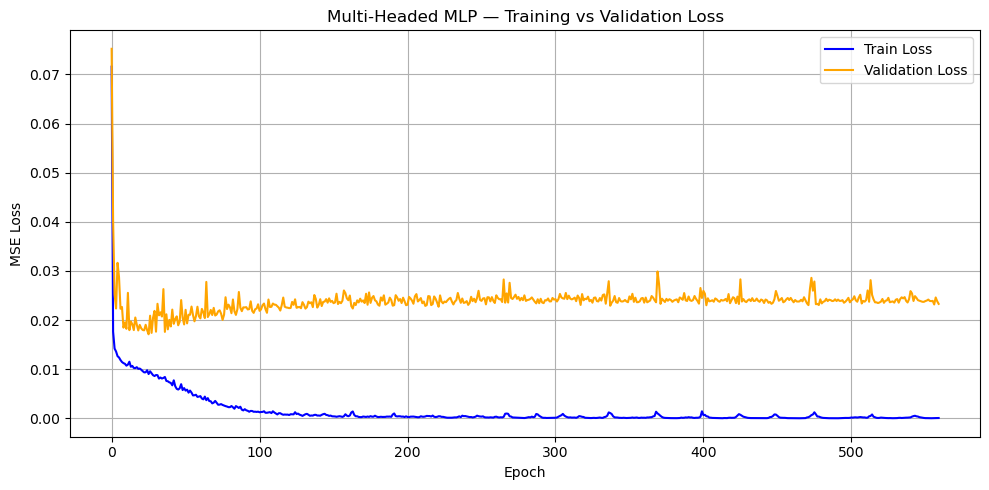

In [111]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_mh, label='Train Loss', color='blue')
plt.plot(val_losses_mh, label='Validation Loss', color='orange')
plt.title("Multi-Headed MLP — Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [112]:
model_mh.eval()
with torch.no_grad():
    y_pred_scaled_mh = model_mh(X_lag_test_t_mh, X_exog_test_t_mh).numpy()

y_pred_mh = scaler_y_mh.inverse_transform(y_pred_scaled_mh).flatten()
y_test_orig_mh = scaler_y_mh.inverse_transform(y_test_mh).flatten()

In [113]:
rmse_mh = np.sqrt(mean_squared_error(y_test_orig_mh, y_pred_mh))
mae_mh = mean_absolute_error(y_test_orig_mh, y_pred_mh)
r2_mh = r2_score(y_test_orig_mh, y_pred_mh)

print("\n[Multi-Headed MLP Evaluation]")
print(f"RMSE: {rmse_mh:.2f}")
print(f"MAE: {mae_mh:.2f}")
print(f"R²: {r2_mh * 100:.2f}%")


[Multi-Headed MLP Evaluation]
RMSE: 24066.54
MAE: 18482.95
R²: 67.19%


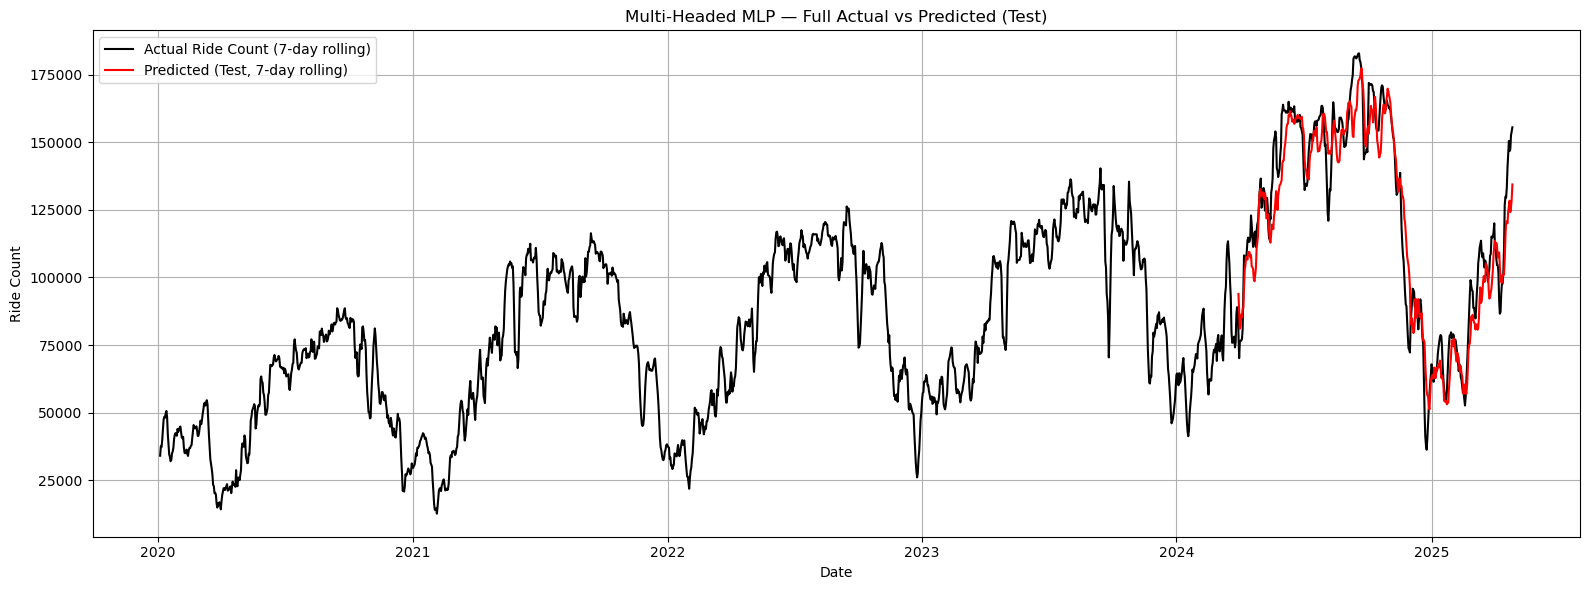

In [114]:
# Get full actual series (smoothed)
ride_count_full_mh = mh_daily_df['ride_count']
ride_count_smooth_mh = ride_count_full_mh.rolling(7, center=True).mean()

# Predicted series (smoothed)
index_test_mh = mh_daily_df.index[-400:]
pred_series_mh = pd.Series(y_pred_mh, index=index_test_mh)
pred_smooth_mh = pred_series_mh.rolling(7, center=True).mean()

# Plot actual full vs predicted test range
plt.figure(figsize=(16, 6))
plt.plot(ride_count_smooth_mh, label='Actual Ride Count (7-day rolling)', color='black')
plt.plot(pred_smooth_mh, label='Predicted (Test, 7-day rolling)', color='red')
plt.title("Multi-Headed MLP — Full Actual vs Predicted (Test)")
plt.xlabel("Date")
plt.ylabel("Ride Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Observations

- Visual Analysis
    - This model forecast aligns closely with actual ride count trends, especially during high demand periods
    - Shows the models ability to track seasonal trends and short-term spies, outperforming the univariate MLP but no multivariate MLP
    - In terms of the train/test loss plot, both losses seem to stagnate after around 100 epochs and does not improve/converge further, showing that the model has most likely reached it maximum in terms of performance
- Model Metrics
    - RMSE: 24,065.54, MAE: 18,482.95, R^2: 67.19%
        - Once again further improves the univariate version but not the multivariate, suggesting that the mode of which the external variables was fed in the model is casuing the difference
     
Interpretation of Results

The Multi-headed MLP proves to be effective by integrating temporal lags with weather data in parallel processing branches. Its architecture allows it to learn patterns that may be difficult to capture when the data is passed through a single branch. Interestingly, it performs worse than the multivariate version which might suggest that the single branch used might have captured meaninful relationships between the two sets of data more that it has being on separate streams. As in the multivariate version processes all data together from the beginning rather than later (Multi-headed MLP), although this model may been better than most have been in the project, it can be said that there is a strong relationship between bike rental data and weather variables

# 26. Univariate CNN

To further explore and capture spatial and local patterns in the data, a 1D CNN was implemented. CNNs although used for images, can show promising performance when treating lagged sequences as the patterns for the filter kernel. This version of a univariate CNN only uses past ride counts without any weather input. Although we can established so far that the external variables have been highly helpful to increase model performance, this version is still conducted to understand what a CNN may lack if a univariate version is used

- Purpose
    - Leverage CNNs strength in capturing local patterns and trends in the time series
    - Evaluate whether spatial filtering over lagged input windows performs better than the fully connected MLP approaches
    - Allows for a baseline understanding for even more complex models
- Feature Selection
    - ride counts aggregated to daily
    - Lag Features: previous 30 days of ride counts used as input features
- Model Training
    - Data split into 80% training 20% testing (last 400 days used for testing)
    - Neural Network structure
        - Two 1D convolutional layers
            - Conv1D(1 -> 32, kernel size = 7)
            - Conv1D(32 -> 64, kernel size = 7)
    - Optimizer: Adam
    - Trained over 560 for the same reasons as before

In [66]:
# Preprocess daily series
citibike_df = citibike_df.sort_index().asfreq("h").ffill().bfill()
y_daily = citibike_df['ride_count'].resample('D').sum().ffill()

# Create lagged dataset
def create_lagged(series, lag=30):
    X, y = [], []
    for i in range(lag, len(series)):
        X.append(series[i-lag:i])
        y.append(series[i])
    return np.array(X), np.array(y)

X_all, y_all = create_lagged(y_daily.values, lag=30)

# Train/test split
X_train, X_test = X_all[:-400], X_all[-400:]
y_train_raw, y_test_raw = y_all[:-400], y_all[-400:]

# Scale
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train = y_scaler.fit_transform(y_train_raw.reshape(-1, 1))
y_test = y_scaler.transform(y_test_raw.reshape(-1, 1))

# Reshape for CNN: (samples, channels, sequence_length)
X_train_tensor = torch.tensor(X_train_scaled[:, np.newaxis, :], dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled[:, np.newaxis, :], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [67]:
class CNNUnivariate(nn.Module):
    def __init__(self):
        super(CNNUnivariate, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=7),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=7),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # Output: (batch_size, 64, 1)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

In [68]:
model = CNNUnivariate()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses = [], []
epochs = 560

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    train_losses.append(total_loss / len(train_loader))
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_tensor)
        val_loss = criterion(val_pred, y_test_tensor).item()
        val_losses.append(val_loss)
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_loss:.4f}")


Epoch 10/560 - Train Loss: 0.0152 - Val Loss: 0.0289
Epoch 20/560 - Train Loss: 0.0148 - Val Loss: 0.0281
Epoch 30/560 - Train Loss: 0.0152 - Val Loss: 0.0266
Epoch 40/560 - Train Loss: 0.0144 - Val Loss: 0.0264
Epoch 50/560 - Train Loss: 0.0141 - Val Loss: 0.0293
Epoch 60/560 - Train Loss: 0.0141 - Val Loss: 0.0273
Epoch 70/560 - Train Loss: 0.0145 - Val Loss: 0.0289
Epoch 80/560 - Train Loss: 0.0135 - Val Loss: 0.0260
Epoch 90/560 - Train Loss: 0.0133 - Val Loss: 0.0323
Epoch 100/560 - Train Loss: 0.0128 - Val Loss: 0.0238
Epoch 110/560 - Train Loss: 0.0132 - Val Loss: 0.0243
Epoch 120/560 - Train Loss: 0.0124 - Val Loss: 0.0237
Epoch 130/560 - Train Loss: 0.0126 - Val Loss: 0.0266
Epoch 140/560 - Train Loss: 0.0127 - Val Loss: 0.0237
Epoch 150/560 - Train Loss: 0.0120 - Val Loss: 0.0228
Epoch 160/560 - Train Loss: 0.0120 - Val Loss: 0.0228
Epoch 170/560 - Train Loss: 0.0116 - Val Loss: 0.0247
Epoch 180/560 - Train Loss: 0.0115 - Val Loss: 0.0287
Epoch 190/560 - Train Loss: 0.0114 - 

In [69]:
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).numpy()

# Inverse scale
y_pred = y_scaler.inverse_transform(y_pred_scaled).flatten()
y_test_orig = y_scaler.inverse_transform(y_test).flatten()


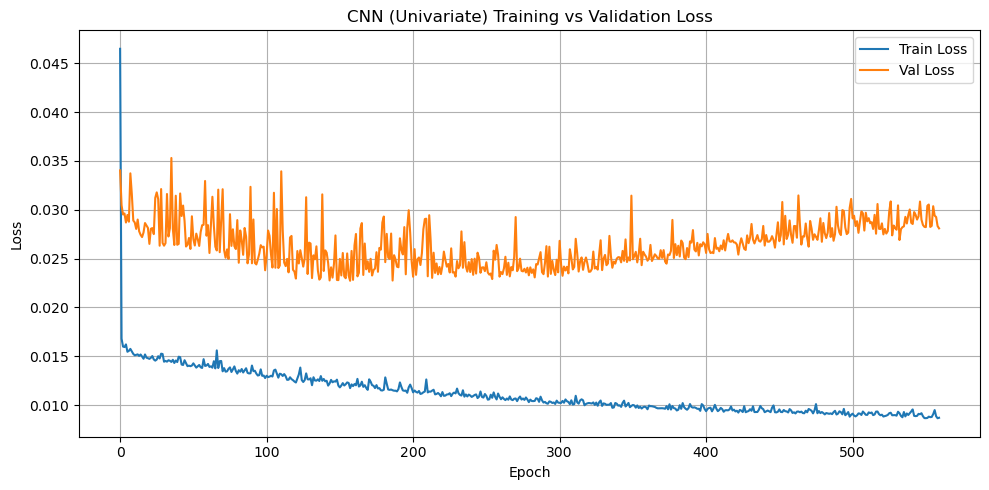

In [70]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("CNN (Univariate) Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
mae = mean_absolute_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2 * 100:.2f}%")


RMSE: 26425.88
MAE: 20421.86
R²: 60.44%


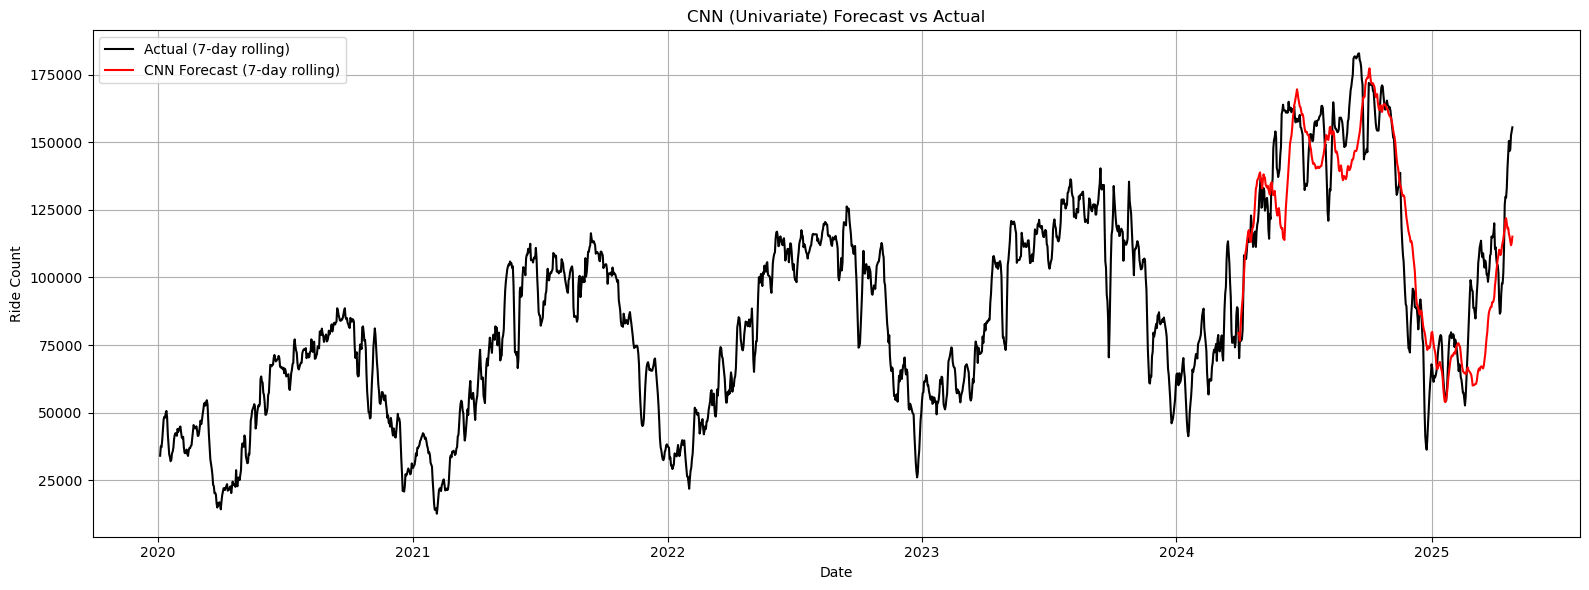

In [73]:
full_actual_smooth = y_daily.rolling(7, center=True).mean()
test_index = y_daily.index[-400:]
pred_smooth = pd.Series(y_pred, index=test_index).rolling(7, center=True).mean()

plt.figure(figsize=(16, 6))
plt.plot(full_actual_smooth, label='Actual (7-day rolling)', color='black')
plt.plot(pred_smooth, label='CNN Forecast (7-day rolling)', color='red')
plt.title("CNN (Univariate) Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Ride Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Observations

- Visual Analysis
    - The CNN forecast tracks the general seasonal shape of the test set decently well
    - It captures local oscillations and sharper peaks better than the traditional linear models, but fails to be as detailed as the MLP models
    - Considerable amount of under-prediction when large jumps occur
    - In terms of the train/test loss plot, the training loss keeps decreasing while the validation loss starts increasing after about 300 epochs. This suggests that the model started overfitting around that point
- Model Metrics
    - RMSE: 26,425.88, MAE: 20,421.86
        - Somewhat close values compared to the univariate MLP suggesting the CNN model is as good in terms of its ability to minimize loss
    - R^2: 60.44%
        - Although the RMSE and MAE were competitive with the univariate MLP, the R^2 score is slightly lower but much better than a SARIMAX or ARIMAX
     
Interpretation of Results

The CNNs ability to identify local patterns in lagged sequences proves that this model is useful for captuing seasonality and shifts in demand. While it does not outpreform the MLPs in this case, its performance supports the potential of convolutional architectures in forecasting. Possible reasons for lower performance could include that the filter kernel may have been too big to capture smaller shifts in the data. Knowing that previous multivariate versions have always been better than its univariate counterpart, the logical next step would be to implement a multivariate CNN

# 27. Multivariate CNN

Expanding on the univariate CNN model, this multivariate version incorporates multiple input channels including historal ride counts as well as the five weather variables that have been used before. In this model, the convolutional layers process the data across both patterns and feature dimensions, allowing the the model to extract complex patterns in ride demand driven by external factors

- Purpose
    - Capture both patterns and inter-variable relationships using the CNN architecture
    - Assess how well CNN can scale with multivariate inputs compared to its univariate counterpart
    - Benchmark the advanced version of CNN against the high performing MLP models
- Feature Selection
    - ride counts aggregated to daily
    - Input Channels: Ride count, Temperature, Windspeed, Snow depth, Precipitation, Cloud cover
    - Input Window: 30 day history of each variable (6x30 matrices per sample)
- Model Training
    - Data split in 80% train and 20% test (last 400 days for test)
    - CNN architecture
        - Conv1D(in=6 → 64, kernel=3) → ReLU → Dropout(0.3)
        - Conv1D(64 → 128, kernel=7) → ReLU
        - AdaptiveAvgPool1D + Flatten + Dense(128 → 1) -> Adaptively averages features across the time dimension, flattens the result, and then maps it to a final prediction using a dense layer
    - Optimizer: Adam
    - Trained across 560 epochs with the same reasons as before        

In [74]:
weather_vars = ['ride_count', 'temperature_2m', 'windspeed_10m', 'snow_depth', 'precipitation', 'cloudcover']

# Resample to daily
daily_df = citibike_df.sort_index().asfreq("h").ffill().bfill()
daily_df = daily_df[weather_vars].resample('D').agg({
    'ride_count': 'sum',
    'temperature_2m': 'mean',
    'windspeed_10m': 'mean',
    'snow_depth': 'mean',
    'precipitation': 'mean',
    'cloudcover': 'mean'
}).ffill()


In [75]:
def create_multivariate_lagged(df, lag=30):
    X, y = [], []
    data = df.values
    for i in range(lag, len(data)):
        X.append(data[i-lag:i].T)  # (features, lag)
        y.append(data[i][0])       # Predict ride_count
    return np.array(X), np.array(y)

X_all, y_all = create_multivariate_lagged(daily_df, lag=30)

# Train/test split
X_train, X_test = X_all[:-400], X_all[-400:]
y_train_raw, y_test_raw = y_all[:-400], y_all[-400:]

# Scale
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_reshaped = X_train.transpose(0, 2, 1).reshape(-1, X_all.shape[2])  # (samples * lag, features)
X_test_reshaped = X_test.transpose(0, 2, 1).reshape(-1, X_all.shape[2])

X_train_scaled = X_scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = X_scaler.transform(X_test_reshaped).reshape(X_test.shape)

y_train = y_scaler.fit_transform(y_train_raw.reshape(-1, 1))
y_test = y_scaler.transform(y_test_raw.reshape(-1, 1))

# Convert to PyTorch tensors
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)


In [76]:
import torch.nn as nn

class MultivariateCNN(nn.Module):
    def __init__(self, in_channels, seq_len):
        super(MultivariateCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Conv1d(64, 128, kernel_size=7),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)  # Output: (batch, 128, 1)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(self.conv(x))


In [77]:
model = MultivariateCNN(in_channels=X_train.shape[1], seq_len=X_train.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_losses, val_losses = [], []
epochs = 560

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_t)
        val_loss = criterion(val_pred, y_test_t).item()
        val_losses.append(val_loss)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_loss:.4f}")


Epoch 10/560 - Train Loss: 0.0150 - Val Loss: 0.0454
Epoch 20/560 - Train Loss: 0.0135 - Val Loss: 0.0272
Epoch 30/560 - Train Loss: 0.0128 - Val Loss: 0.0321
Epoch 40/560 - Train Loss: 0.0140 - Val Loss: 0.0382
Epoch 50/560 - Train Loss: 0.0120 - Val Loss: 0.0277
Epoch 60/560 - Train Loss: 0.0116 - Val Loss: 0.0315
Epoch 70/560 - Train Loss: 0.0111 - Val Loss: 0.0300
Epoch 80/560 - Train Loss: 0.0105 - Val Loss: 0.0360
Epoch 90/560 - Train Loss: 0.0098 - Val Loss: 0.0508
Epoch 100/560 - Train Loss: 0.0088 - Val Loss: 0.0400
Epoch 110/560 - Train Loss: 0.0086 - Val Loss: 0.0419
Epoch 120/560 - Train Loss: 0.0079 - Val Loss: 0.0355
Epoch 130/560 - Train Loss: 0.0080 - Val Loss: 0.0283
Epoch 140/560 - Train Loss: 0.0077 - Val Loss: 0.0508
Epoch 150/560 - Train Loss: 0.0067 - Val Loss: 0.0385
Epoch 160/560 - Train Loss: 0.0063 - Val Loss: 0.0351
Epoch 170/560 - Train Loss: 0.0064 - Val Loss: 0.0306
Epoch 180/560 - Train Loss: 0.0060 - Val Loss: 0.0403
Epoch 190/560 - Train Loss: 0.0058 - 

In [78]:
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_t).numpy()

y_pred = y_scaler.inverse_transform(y_pred_scaled).flatten()
y_test_orig = y_scaler.inverse_transform(y_test).flatten()


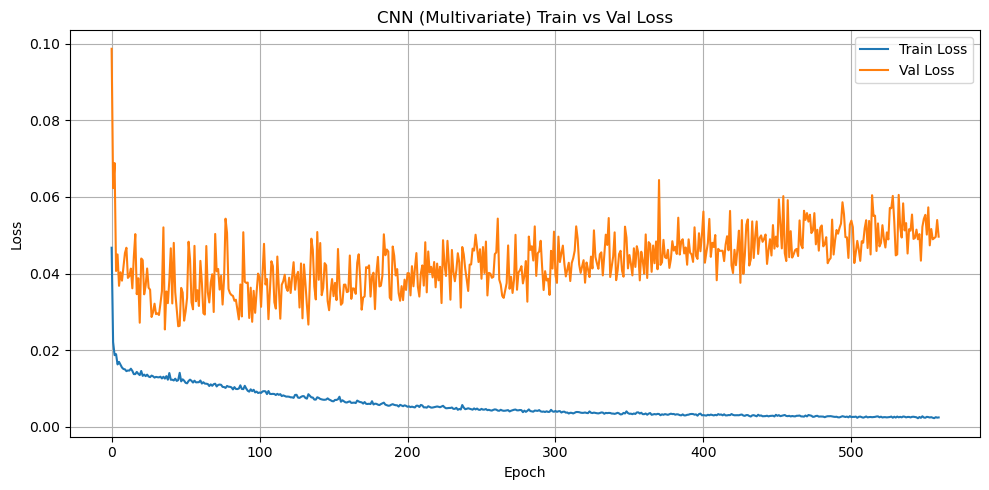

In [79]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("CNN (Multivariate) Train vs Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [80]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
mae = mean_absolute_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2 * 100:.2f}%")


RMSE: 35120.07
MAE: 29606.12
R²: 30.13%


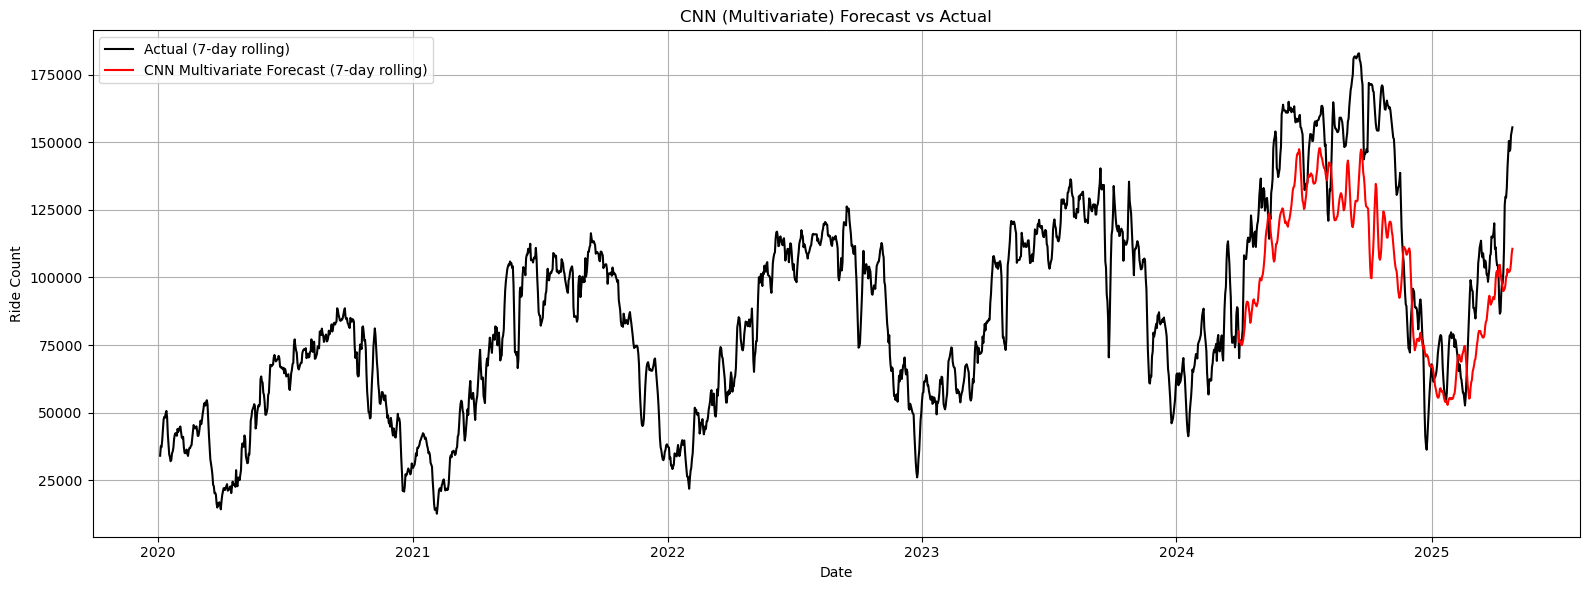

In [81]:
full_actual_smooth = daily_df['ride_count'].rolling(7, center=True).mean()
test_index = daily_df.index[-400:]
pred_smooth = pd.Series(y_pred, index=test_index).rolling(7, center=True).mean()

plt.figure(figsize=(16, 6))
plt.plot(full_actual_smooth, label='Actual (7-day rolling)', color='black')
plt.plot(pred_smooth, label='CNN Multivariate Forecast (7-day rolling)', color='red')
plt.title("CNN (Multivariate) Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Ride Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Observations

- Visual Analysis
    - The forecast showed a reasonable match in pattern but underestimates the magnitude of majority of the peaks
    - Seasonal patterns are mostly captured, but short-term spikes are smoothed out
    - In terms of the train/test loss plot, the validation loss starts increasing after about 200 epochs while the training stays low suggesting that the model was overfitting
-  Model Metrics
    - RMSE: 35,120.07, MAE: 29,606.12, R^2:30.13
        - Despite the complex feature list, the model underpreforms compared to the univariate CNN and the MLP models
        - the lower R^2 score suggests the model struggled to generalize under high dimentional inputs
 
Interpretation of Results

The multivariate CNN did not outpreform the other models, likely due to the struture of filters being less favorable to learning from the combined high-dimentional weather and patterns compared to dense architectures. This shows that while CNNs are powerful for captural spatial structure, they may be succeptible to overfitting or even being overly complicated when given many filters. In this case, fully connected models may be better to sequential external variables for forecasting. 

# 28. Univariate RNN

To better model pattern dependencies in sequential data, a RNN was implemented using only lagged ride count values. Unlike MLPs or CNNs, RNNs are designed to retain short-term memory, making them a natural fit for this forecasting project. The idea is that by retaining information about previous data points, the model would be able to understand the overall structure of the data better.

- Purpose
    - explore pattern modeling using recurent architecture
    - compare RNNs ability to capture dependencies against CNN and MLP models
    - Baseline model for more complex models such as LSTM
- Feature Selection
    - ride counts aggregated to daily
    - Input: past 30 days of ride counts, treated at time-ordered events. 30 chosen, like all models before this, from the analysis of the AFC and PAFC plots
- Model Training
    - Data split in 80% train and 20% test (last 400 days for test)
    - RNN Architecture
        - Input Size: 1 (Univariate)
        - Hidden Size: 64 units
        - 1 reccurent layer followed by a dense output layer
    - Optimizer: Adam
    - Training run over 560 epochs with the same reasons as before 

In [82]:
# Resample to daily
y_daily = citibike_df['ride_count'].resample('D').sum().ffill()

# Create lagged dataset
def create_lagged_dataset(series, lag=30):
    X, y = [], []
    for i in range(lag, len(series)):
        X.append(series[i-lag:i])
        y.append(series[i])
    return np.array(X), np.array(y)

X_all, y_all = create_lagged_dataset(y_daily.values, lag=30)

# Train/test split
X_train, X_test = X_all[:-400], X_all[-400:]
y_train_raw, y_test_raw = y_all[:-400], y_all[-400:]

# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1))
y_test = scaler_y.transform(y_test_raw.reshape(-1, 1))

# Reshape for RNN: (samples, seq_len, input_size)
X_train_t = torch.tensor(X_train_scaled.reshape(-1, 30, 1), dtype=torch.float32)
X_test_t = torch.tensor(X_test_scaled.reshape(-1, 30, 1), dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)


In [83]:
class RNNForecast(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(RNNForecast, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)               # out: (batch, seq_len, hidden)
        return self.fc(out[:, -1, :])      # use last time step


In [84]:
model = RNNForecast()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_losses, val_losses = [], []
epochs = 560

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_t)
        val_loss = criterion(val_pred, y_test_t).item()
        val_losses.append(val_loss)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_loss:.4f}")


Epoch 10/560 - Train Loss: 0.0129 - Val Loss: 0.0309
Epoch 20/560 - Train Loss: 0.0120 - Val Loss: 0.0280
Epoch 30/560 - Train Loss: 0.0116 - Val Loss: 0.0206
Epoch 40/560 - Train Loss: 0.0124 - Val Loss: 0.0219
Epoch 50/560 - Train Loss: 0.0116 - Val Loss: 0.0236
Epoch 60/560 - Train Loss: 0.0118 - Val Loss: 0.0226
Epoch 70/560 - Train Loss: 0.0115 - Val Loss: 0.0188
Epoch 80/560 - Train Loss: 0.0114 - Val Loss: 0.0210
Epoch 90/560 - Train Loss: 0.0116 - Val Loss: 0.0215
Epoch 100/560 - Train Loss: 0.0113 - Val Loss: 0.0263
Epoch 110/560 - Train Loss: 0.0112 - Val Loss: 0.0201
Epoch 120/560 - Train Loss: 0.0114 - Val Loss: 0.0260
Epoch 130/560 - Train Loss: 0.0112 - Val Loss: 0.0225
Epoch 140/560 - Train Loss: 0.0115 - Val Loss: 0.0248
Epoch 150/560 - Train Loss: 0.0114 - Val Loss: 0.0205
Epoch 160/560 - Train Loss: 0.0112 - Val Loss: 0.0231
Epoch 170/560 - Train Loss: 0.0113 - Val Loss: 0.0252
Epoch 180/560 - Train Loss: 0.0115 - Val Loss: 0.0289
Epoch 190/560 - Train Loss: 0.0115 - 

In [85]:
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_t).numpy()

y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
y_test_orig = scaler_y.inverse_transform(y_test).flatten()


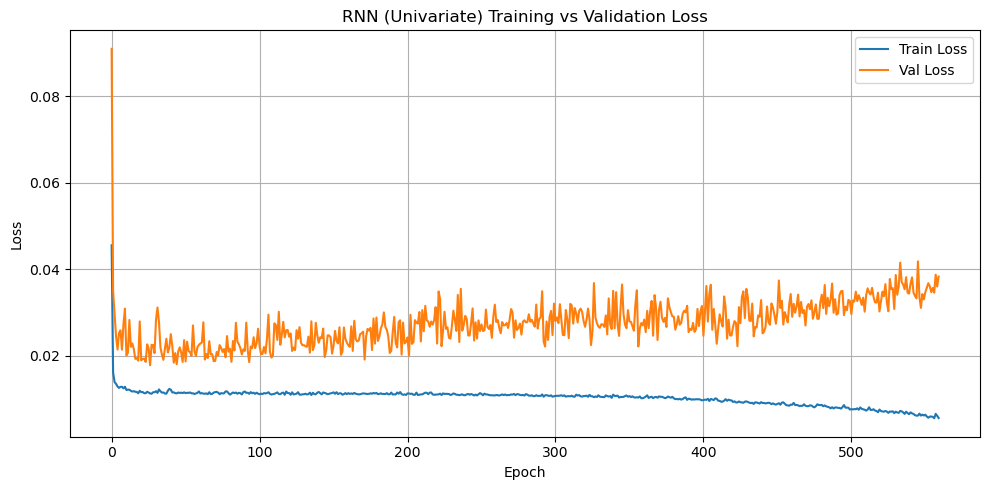

In [86]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("RNN (Univariate) Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [87]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
mae = mean_absolute_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2 * 100:.2f}%")
#Univariate RNN

RMSE: 30864.69
MAE: 24908.50
R²: 46.03%


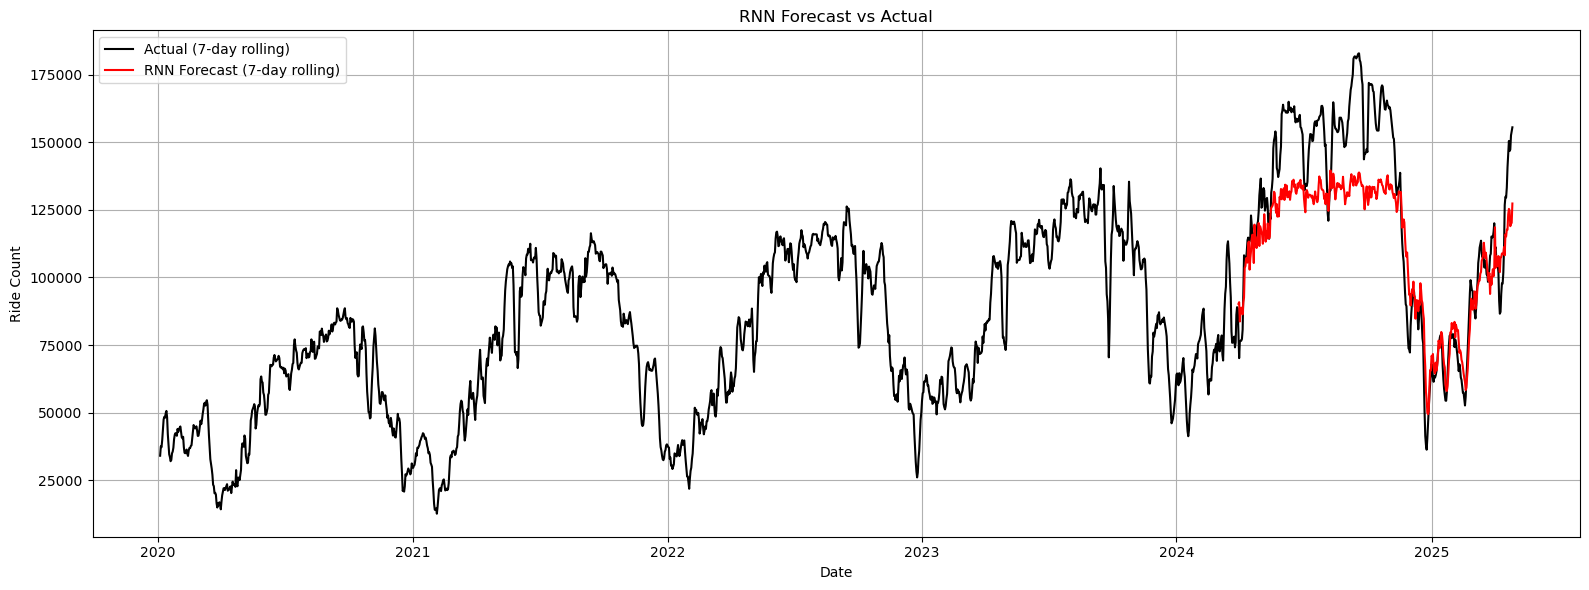

In [88]:
full_actual_smooth = y_daily.rolling(7, center=True).mean()
test_index = y_daily.index[-400:]
pred_smooth = pd.Series(y_pred, index=test_index).rolling(7, center=True).mean()

plt.figure(figsize=(16, 6))
plt.plot(full_actual_smooth, label='Actual (7-day rolling)', color='black')
plt.plot(pred_smooth, label='RNN Forecast (7-day rolling)', color='red')
plt.title("RNN Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Ride Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Observations

- Visual Analysis
    - The RNN shows that it can follow the seasonal pattern, mostly during the periods od gradual change
    - Then it flattens out during bigger increases in bike demand with it also struggling with short-term spikes as well
    - In terms of the train/test loss plot, the validation loss seems to be increasing slowly from about 200 epochs while the train loss keeps decreasing, this suggests overfitting
- Model Metrics
    - RMSE: 30,864.69, MAE: 24,908.50, R^2: 46.03%
        - The RMSE and MAE values are moderate, much better than earlier linear models but no where near the MLP models which preformed the best
        - the R^2 value is somewhat decent and tells us I can tell close to half of the data's variability but not close once again to the high performing MLP models
 
Interpretation of Results

While RNNs are conceptually suitable for this time series project, the simple vanilla RNN used here struggles with long-term dependencies and smalle seasonal patterns. Its somewhat okay performance suggests that LSTM is likely to do much better given the exploding and vanishing gradient problem. Therefore, a multivariate version of RNN is not being implemented due to the chance of LSTM giving higher performance. 

# 29. LSTM

After exploring MLP, I moved on to implementing a LSTM model to capture sequential dependencies in the bike rental data.

- Purpose
    - LSTM are good for time series forecasting because they can remember information over long periods and are able of modeling complex sequential relationships. Given the seasonality anf AFC/PAFC observed in a previous section, LSTMs would be able to better capture these time dependent patterns compared to a standard feed forward neural network
- Feature Engineering
    - Exact same features as the MLP model was used to be able to asses model performance across the same input variables
- Model Training
    - The dataset was tranformed into sequences of 7 days, allowing the model to predict "the next days" rental demand based on the past week.
    - LSTM model created with:
        - One LSTM layer processing sequential data
        - Fully connected output layer predicting the daily ride count
    - Unlike the MLP, early stopping was used based on the valdiation loss so that tranining can be automatically stopped before it starts overfitting
    - Once again Adam optimizer and MSE was used for loss calculations
- Forecasting and Plotting
    -  Similar to the ARIMAX and MLP section, a 7 day rolling mean was applied to all data for better visualiation with the final plot comparing the actual data (gray), the actual data of the test set (red) and the prediction (blue)
- Performance Metrics
    - Once again similar to the ARIMAX and MLP section, RMSE, MAE, and R^2 was used as performance metrics.   


In [313]:
# Resample and clean
y_lstm = citibike_df['ride_count'].resample('D').sum()
X_weather_lstm = citibike_df[['temperature_2m', 'relative_humidity_2m']].resample('D').mean()
X_weather_lstm = X_weather_lstm.ffill().bfill()

# Create calendar features
calendar_df_lstm = pd.DataFrame(index=y_lstm.index)
calendar_df_lstm['dayofweek'] = y_lstm.index.dayofweek
calendar_df_lstm['month'] = y_lstm.index.month
calendar_df_lstm['year'] = y_lstm.index.year
calendar_df_lstm['weekofyear'] = y_lstm.index.isocalendar().week
calendar_df_lstm['is_weekend'] = (y_lstm.index.dayofweek >= 5).astype(int)  # 5=Saturday, 6=Sunday

# Create lag features
lag_1_lstm = y_lstm.shift(1)
lag_7_lstm = y_lstm.shift(7)

# Combine everything
X_full_lstm = pd.concat([X_weather_lstm, calendar_df_lstm, lag_1_lstm.rename('lag_1'), lag_7_lstm.rename('lag_7')], axis=1)

# Drop rows with NaNs due to lagging (first 7 rows will be NaN for lag_7)
X_full_lstm = X_full_lstm.dropna()
y_lstm = y_lstm[X_full_lstm.index]  # Align y

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # if using GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Train-test split
train_size_lstm = int(len(y_lstm) * 0.8)
X_train_lstm = X_full_lstm.iloc[:train_size_lstm]
X_test_lstm = X_full_lstm.iloc[train_size_lstm:]
y_train_lstm = y_lstm.iloc[:train_size_lstm]
y_test_lstm = y_lstm.iloc[train_size_lstm:]


In [314]:
seq_length = 7  # Look back 7 days

def create_sequences(X, y, seq_length):
    Xs, ys = [], []
    for i in range(seq_length, len(X)):
        Xs.append(X[i-seq_length:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# Scaling
scaler_X_lstm = StandardScaler()
X_train_scaled_lstm = scaler_X_lstm.fit_transform(X_train_lstm)
X_test_scaled_lstm = scaler_X_lstm.transform(X_test_lstm)

scaler_y_lstm = StandardScaler()
y_train_scaled_lstm = scaler_y_lstm.fit_transform(y_train_lstm.values.reshape(-1, 1))
y_test_scaled_lstm = scaler_y_lstm.transform(y_test_lstm.values.reshape(-1, 1))

# Create sequences for train and test
X_train_seq_lstm, y_train_seq_lstm = create_sequences(X_train_scaled_lstm, y_train_scaled_lstm, seq_length)
X_test_seq_lstm, y_test_seq_lstm = create_sequences(X_test_scaled_lstm, y_test_scaled_lstm, seq_length)

# Convert to tensors
X_train_tensor_lstm = torch.tensor(X_train_seq_lstm, dtype=torch.float32)
y_train_tensor_lstm = torch.tensor(y_train_seq_lstm, dtype=torch.float32)
X_test_tensor_lstm = torch.tensor(X_test_seq_lstm, dtype=torch.float32)
y_test_tensor_lstm = torch.tensor(y_test_seq_lstm, dtype=torch.float32)

print(X_train_tensor_lstm.shape)  # (batch_size, seq_length, features)
print(y_train_tensor_lstm.shape)  # (batch_size, 1)


torch.Size([1545, 7, 9])
torch.Size([1545, 1])


In [315]:
class DeepMLP(nn.Module):
    def __init__(self, input_dim):
        super(DeepMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),  # Layer 1: Bigger first layer
            nn.ReLU(),
            nn.Linear(128, 64),         # Layer 2
            nn.ReLU(),
            nn.Linear(64, 32),          # Layer 3
            nn.ReLU(),
            nn.Linear(32, 16),          # Layer 4
            nn.ReLU(),
            nn.Linear(16, 1)            # Output layer
        )

    def forward(self, x):
        return self.net(x)

# Initialize
model_lstm = LSTMModel(input_dim=X_train_tensor_lstm.shape[2])

criterion_lstm = nn.MSELoss()
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=0.001)


In [316]:
best_loss_lstm = float('inf')
patience_lstm = 10  # How many epochs to wait
counter_lstm = 0

# Define epochs specifically if not already
epochs_lstm = 560

train_losses_lstm = []
test_losses_lstm = []

for epoch in range(epochs_lstm):
    # Train step
    model_lstm.train()
    optimizer_lstm.zero_grad()
    outputs = model_lstm(X_train_tensor_lstm).squeeze()
    loss = criterion_lstm(outputs, y_train_tensor_lstm.squeeze())
    loss.backward()
    optimizer_lstm.step()

    # Evaluate on test
    model_lstm.eval()
    with torch.no_grad():
        test_outputs = model_lstm(X_test_tensor_lstm).squeeze()
        test_loss = criterion_lstm(test_outputs, y_test_tensor_lstm.squeeze())
    
    train_losses_lstm.append(loss.item())
    test_losses_lstm.append(test_loss.item())

    # Print every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs_lstm}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

    # Early stopping logic
    if test_loss.item() < best_loss_lstm:
        best_loss_lstm = test_loss.item()
        counter_lstm = 0  # reset if improvement
        best_model_lstm = model_lstm.state_dict()  # Save the best model
    else:
        counter_lstm += 1
        if counter_lstm >= patience_lstm:
            print(f"Early stopping at epoch {epoch+1}")
            break

model_lstm.load_state_dict(best_model_lstm)


Epoch 10/560, Train Loss: 0.7642, Test Loss: 2.7346
Epoch 20/560, Train Loss: 0.3978, Test Loss: 1.1456
Epoch 30/560, Train Loss: 0.3146, Test Loss: 0.9422
Early stopping at epoch 35


<All keys matched successfully>

In [317]:
model_lstm.eval()
with torch.no_grad():
    y_pred_scaled_lstm = model_lstm(X_test_tensor_lstm).numpy()

# Inverse scale
y_pred_lstm = scaler_y_lstm.inverse_transform(y_pred_scaled_lstm.reshape(-1, 1))
y_test_actual_lstm = scaler_y_lstm.inverse_transform(y_test_tensor_lstm.numpy().reshape(-1, 1))


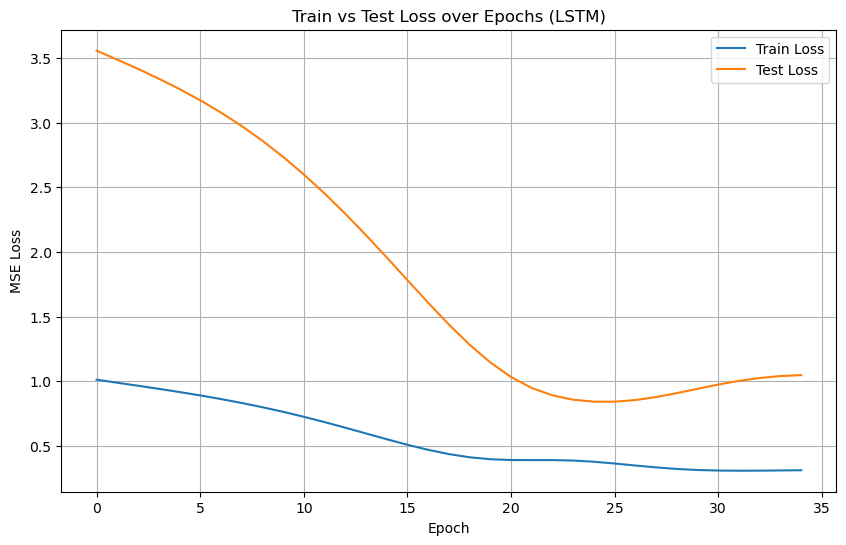

In [318]:
plt.figure(figsize=(10,6))
plt.plot(train_losses_lstm, label='Train Loss')
plt.plot(test_losses_lstm, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Train vs Test Loss over Epochs (LSTM)')
plt.legend()
plt.grid()
plt.show()

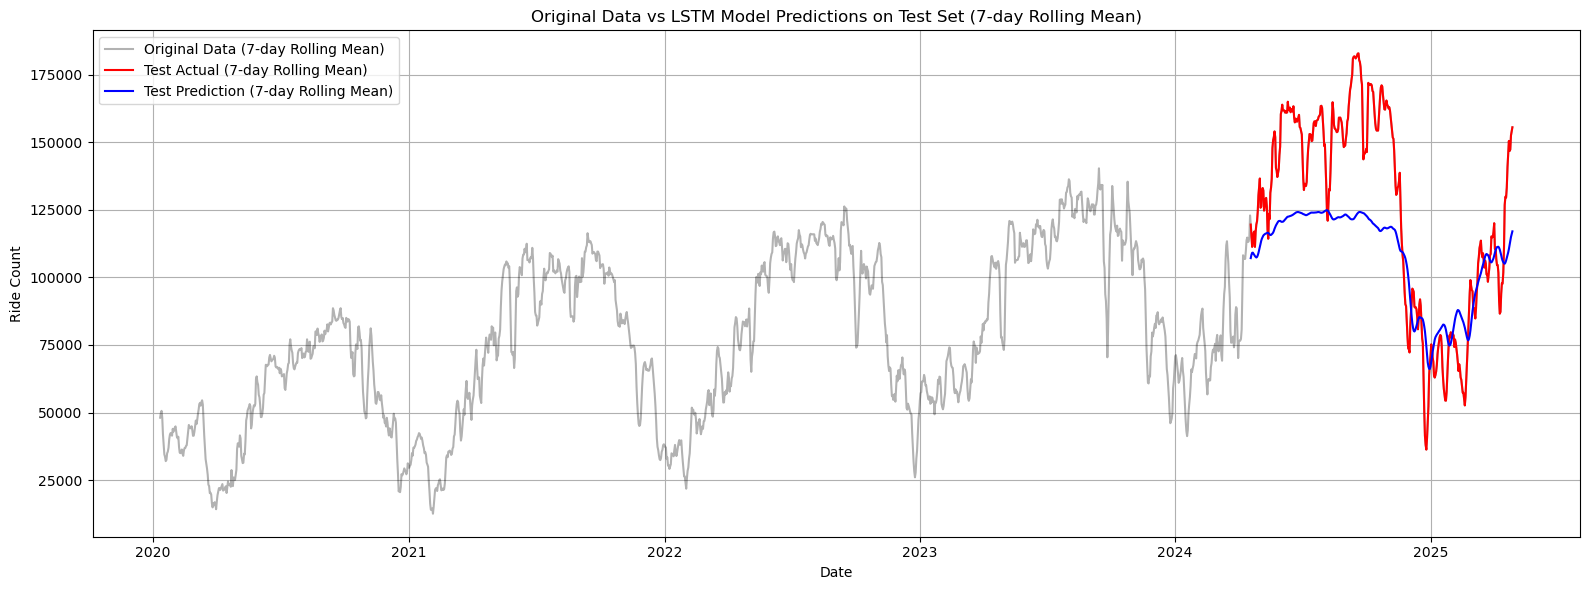

In [319]:
# Adjusted test index (drop the first seq_length days)
adjusted_test_index_lstm = y_test_lstm.index[seq_length:]

# Rolling mean
y_full_actual_smooth_lstm = pd.Series(y_lstm.values, index=y_lstm.index).rolling(window=7, center=True).mean()
y_test_actual_smooth_lstm = pd.Series(y_test_actual_lstm.flatten(), index=adjusted_test_index_lstm).rolling(window=7, center=True).mean()
y_test_pred_smooth_lstm = pd.Series(y_pred_lstm.flatten(), index=adjusted_test_index_lstm).rolling(window=7, center=True).mean()

# Plot
plt.figure(figsize=(16,6))
plt.plot(y_lstm.index, y_full_actual_smooth_lstm, label='Original Data (7-day Rolling Mean)', color='black', alpha=0.3)
plt.plot(adjusted_test_index_lstm, y_test_actual_smooth_lstm, label='Test Actual (7-day Rolling Mean)', color='red')
plt.plot(adjusted_test_index_lstm, y_test_pred_smooth_lstm, label='Test Prediction (7-day Rolling Mean)', color='blue')
plt.xlabel('Date')
plt.ylabel('Ride Count')
plt.title('Original Data vs LSTM Model Predictions on Test Set (7-day Rolling Mean)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [326]:
y_pred_lstm = scaler_y_lstm.inverse_transform(y_pred_scaled_lstm.reshape(-1, 1))

y_test_cut_lstm = y_test_lstm[seq_length:].values.reshape(-1, 1)

rmse_lstm = np.sqrt(mean_squared_error(y_test_cut_lstm, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test_cut_lstm, y_pred_lstm)
r2_lstm = r2_score(y_test_cut_lstm, y_pred_lstm)

print(f"Test RMSE (LSTM): {rmse_lstm:.2f}")
print(f"Test MAE (LSTM): {mae_lstm:.2f}")
print(f"Test R² (LSTM): {r2_lstm*100:.3f}")

Test RMSE (LSTM): 34251.94
Test MAE (LSTM): 29234.55
Test R² (LSTM): 33.187


### Observations

The LSTM model, being a complex model with sophisticated architecture for time series data, it did not perform better than the MLP model. 

- Train test loss curves
    - the training and testing loss curves show normal learning behavior. Initially, the epochs were set at 560. but early stopping was applied after 45 epochs to prevent overfitting.
    - The training loss steadily decreased, but the test loss, after declining for a while, began to increase towards the end, showing that the model was starting to onverfit on the training data
    - Compared to MLP, the LSTMs convergence was slower, and the gap between training and testing loss was a little bigger, indicating higher amounts of overfitting
- Forecasting Results
    - Comparing the smoothed 7 day rolling mean for all the data, the LSTM struggled to follow the specific spikes and dips in the data, similar to the ARIMAX model.
    - While it managed to capture general downward and upward trends, it failed to adapt to more specific changes in the ride counts.
    - This shows that the LSTM had difficulty learning the quick changes or possibly did not have enough parameters for the complexity of the data.
- Evaluation Metrics
    - RMSE: 34,251.94, MAE: 29,234.55, R^2: 33.2%
        - compared to the MLP and SARIMAX models, these metrics show that the LSTM model had lower prediction accuracy as 33.2%, meaning that only 1/3 of the variance was captured.
        - The relatively high RMSE and MAE shows significantly high prediction errors
 
Overall, despite the LSTMs advanage in modeling sequencing dependencies, it underperformed for this dataset. This could be due to a variety of factors including limited weather features, inaccurate model architecture, or insufficiency sequence length for longer term patterns. Regardless, this section of the experiment highlights that LSTM needs care tuning or different input variables to capture the complexity and changes in the bike rental demand 

# 30. Performance Summary

In this section, all of the models that have been implemented will be compared to each other according to the RMSE, MAE, and R^2 score to give insights into how each model performed.

More specifically, they are formatted in two different ways
1. Table: to get a numerical understanding of how each model performed
2. Graph: to get a graphical understanding of each model performed

The main objective here was to get an aggregated view of how each model performed so that only the top performing models can be chosen for hyperparameter optimization which can further improve the performance of the models

In [115]:
perf_sum = {
    'MODEL': ['Mean', 'Naive', 'Drift', 'SES', 'Holt', 'Holt-Winters', 'AR', 'MA', 'ARMA', 'ARIMA', 'SARIMA', 'ARIMAX', 'SARIMAX', 'Univariate MLP', 'Multivariate MLP', 'Multi-headed MLP', 'Univariate CNN', 'Multivariate CNN', 'Univariate RNN', 'LSTM'],
    'RMSE': [62882.56, 46891.97, 45820.44, 57395.72, 55192.30, 35648.16, 59183.69, 62974.27, 54532.73, 47907.10, 50495.04, 32609.96, 32988.26, 25738.35, 16676.52, 24066.54, 26425.88, 35120.07, 30864.69, 34251.94],
    'MAE': [53502.80, 40517.42, 40204.20, 48762.61, 47081.00, 29800.05, 50138.41, 53621.82, 46407.41, 41364.97, 44263.50, 27096.56, 27577.78, 18450.95, 13392.93, 18482.95, 20421.86, 29606.12, 24908.50, 29234.55],
    'R^2': ['-125.48%', '-25.39%', '-19.72%', '-87.849%', '-73.702%', '27.536%', '-98.427%', '-124.659%', '-68.466%', '-30.016%', '-45.394%', '39.361%', '37.042%', '62.47%', '84.064%', '67.19%', '60.44%', '30.13%', '46.03%', '33.187%']
}

df = pd.DataFrame(perf_sum)
print(df)

               MODEL      RMSE       MAE        R^2
0               Mean  62882.56  53502.80   -125.48%
1              Naive  46891.97  40517.42    -25.39%
2              Drift  45820.44  40204.20    -19.72%
3                SES  57395.72  48762.61   -87.849%
4               Holt  55192.30  47081.00   -73.702%
5       Holt-Winters  35648.16  29800.05    27.536%
6                 AR  59183.69  50138.41   -98.427%
7                 MA  62974.27  53621.82  -124.659%
8               ARMA  54532.73  46407.41   -68.466%
9              ARIMA  47907.10  41364.97   -30.016%
10            SARIMA  50495.04  44263.50   -45.394%
11            ARIMAX  32609.96  27096.56    39.361%
12           SARIMAX  32988.26  27577.78    37.042%
13    Univariate MLP  25738.35  18450.95     62.47%
14  Multivariate MLP  16676.52  13392.93    84.064%
15  Multi-headed MLP  24066.54  18482.95     67.19%
16    Univariate CNN  26425.88  20421.86     60.44%
17  Multivariate CNN  35120.07  29606.12     30.13%
18    Univar

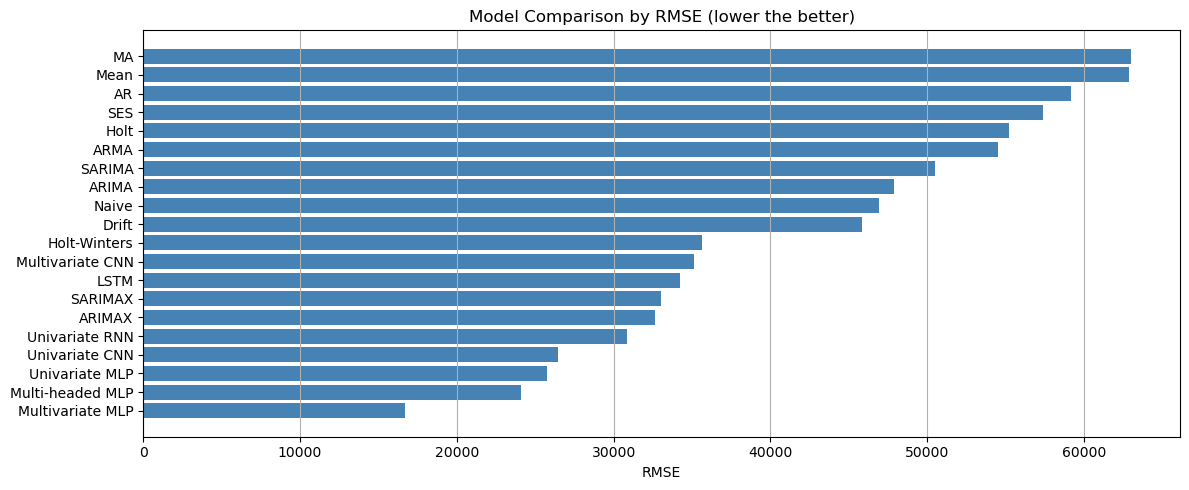

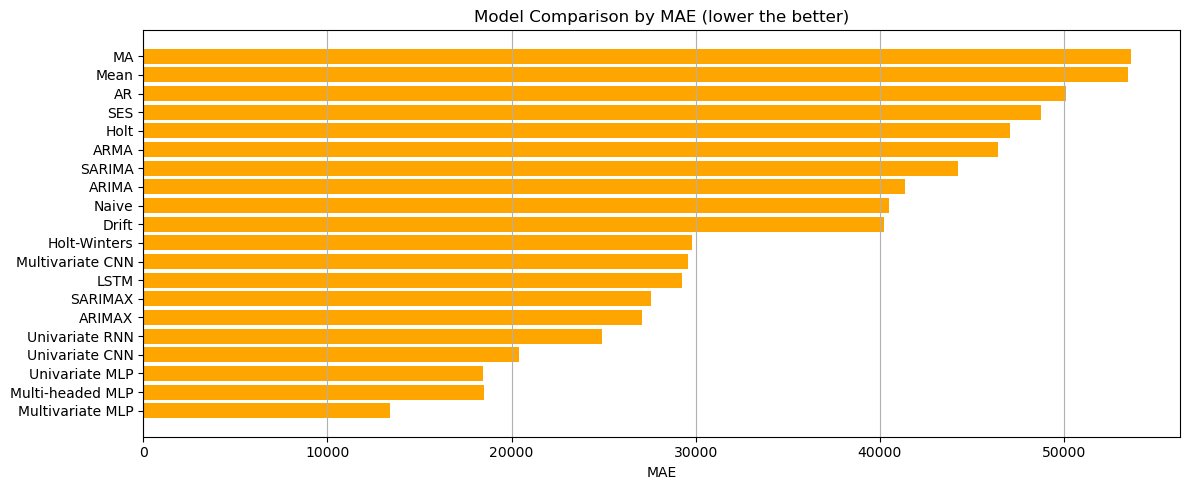

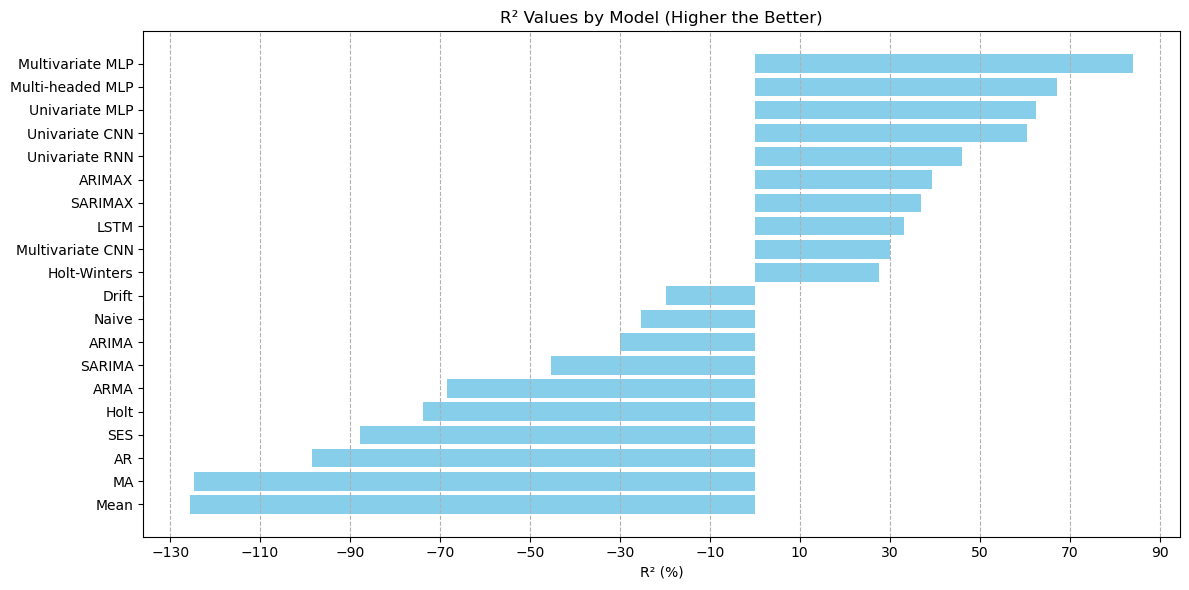

In [116]:
df_rmse = df.sort_values(by='RMSE')
plt.figure(figsize=(12,5))
plt.barh(df_rmse['MODEL'], df_rmse['RMSE'], color='steelblue')
plt.title('Model Comparison by RMSE (lower the better)')
plt.xlabel('RMSE')
plt.tight_layout()
plt.grid(axis='x')
plt.show()

df_mae = df.sort_values(by='MAE')
plt.figure(figsize=(12,5))
plt.barh(df_rmse['MODEL'], df_rmse['MAE'], color='orange')
plt.title('Model Comparison by MAE (lower the better)')
plt.xlabel('MAE')
plt.tight_layout()
plt.grid(axis='x')
plt.show()

df['R^2_float'] = df['R^2'].str.replace('%', '').astype(float)
df_sorted = df.sort_values(by='R^2_float')
plt.figure(figsize=(12, 6))
plt.barh(df_sorted['MODEL'], df_sorted['R^2_float'], color='skyblue')
plt.xlabel('R² (%)')
plt.title('R² Values by Model (Higher the Better)')
plt.grid(axis='x', linestyle='--', alpha=1)
plt.tight_layout()
plt.xticks(range(-130, 91, 20)) 
plt.show()

### Observations

As seen from the table and plots above, the top three performing models were
1. Multivariate MLP : R^2 of 84.064%
2. Multi-headed MLP: R^2 of 67.19%
3. Univariate MLP: R^2 of  62.47%

Understanding that most of the models either has negative R^2 values or very low, logically, choosing the top ones will give me the best results as well as save computational time as well

# 31. Hyperparameter Optimization on Top 3 Models

## a. Univariate MLP with Grid Search

After establishing the effectiveness of a univariate MLP for forecasting demand, the next step was to push its performance limitations further hy conducting hyperparameter optimization. The initial model, while already much better than most models done in this project, it relied on manual/default layer sizes, learning rates and other parameters. To give this model its full potential, a grid search was used

### Why Grid Search?
Grid search was selected as the optimization method because given the total number of configurations (54), it was relatively small and manageable. This allowed for full converage of thie search space, more specifically the major important search spaces given the analysis done before. 

Unlike random search, which might overlook ciritial search spaces, grid search gaurantees a systematic approach for the search space.

Furthermore Bayesian optimization was not used mainly due to the simplicity of the model itself. Because it is univariate, it does not require comprehensive optimization which can waste computational resources and time. Therefore, the grid search was it ideal for its simplicity.

### Search Space Reasoning

hidden_layer_1: to explore depth related capacity. As this is the layer that captures the initial features, testing between generalizing features (64) to extracting complex features (192) can give the model a change to explore a wide range of options

hidden_layer_2: it is standard to have the second hidden layer to be overall smaller than the first, and for similar reasons as the first hidden layers, those three options were chosen

learning_rate: although 0.001 is sometimes known to be the standard, more aggresive learning rates are added in for the purpose of the model to be able to use it and see if it works to find the most optimal learning rate

batch_size: given my computational constraints, those two values were chosen so that the model can choose between more generalizability versus faster computation


In [163]:
search_space = {
    'hidden_layer_1': [64, 128, 192],         
    'hidden_layer_2': [32, 64, 96],         
    'learning_rate': [0.001, 0.0025, 0.005],   
    'batch_size': [32, 64]       
}

grid = list(ParameterGrid(search_space))
print(f"Total combinations to try: {len(grid)}")

Total combinations to try: 54


In [164]:
def train_uvmlp(h1, h2, lr, batch_size, epochs=100):
    # Data prep
    dataset = TensorDataset(X_uvmlp_train_tensor, y_uvmlp_train_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = nn.Sequential(
        nn.Linear(30, h1),
        nn.ReLU(),
        nn.Linear(h1, h2),
        nn.ReLU(),
        nn.Linear(h2, 1)
    )

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            output = model(batch_X)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        preds = model(X_uvmlp_test_tensor).numpy()
    preds_rescaled = scaler_uvmlp_y.inverse_transform(preds)
    actuals_rescaled = scaler_uvmlp_y.inverse_transform(y_uvmlp_test_tensor.numpy())

    rmse = np.sqrt(mean_squared_error(actuals_rescaled, preds_rescaled))
    return rmse, model


In [165]:
results = []

for i, params in enumerate(grid):
    print(f"[{i+1}/{len(grid)}] Trying params: {params}")
    rmse, _ = train_uvmlp(
        h1=params['hidden_layer_1'],
        h2=params['hidden_layer_2'],
        lr=params['learning_rate'],
        batch_size=params['batch_size'],
        epochs=100 
    )
    results.append({**params, 'rmse': rmse})

[1/54] Trying params: {'batch_size': 32, 'hidden_layer_1': 64, 'hidden_layer_2': 32, 'learning_rate': 0.001}
[2/54] Trying params: {'batch_size': 32, 'hidden_layer_1': 64, 'hidden_layer_2': 32, 'learning_rate': 0.0025}
[3/54] Trying params: {'batch_size': 32, 'hidden_layer_1': 64, 'hidden_layer_2': 32, 'learning_rate': 0.005}
[4/54] Trying params: {'batch_size': 32, 'hidden_layer_1': 64, 'hidden_layer_2': 64, 'learning_rate': 0.001}
[5/54] Trying params: {'batch_size': 32, 'hidden_layer_1': 64, 'hidden_layer_2': 64, 'learning_rate': 0.0025}
[6/54] Trying params: {'batch_size': 32, 'hidden_layer_1': 64, 'hidden_layer_2': 64, 'learning_rate': 0.005}
[7/54] Trying params: {'batch_size': 32, 'hidden_layer_1': 64, 'hidden_layer_2': 96, 'learning_rate': 0.001}
[8/54] Trying params: {'batch_size': 32, 'hidden_layer_1': 64, 'hidden_layer_2': 96, 'learning_rate': 0.0025}
[9/54] Trying params: {'batch_size': 32, 'hidden_layer_1': 64, 'hidden_layer_2': 96, 'learning_rate': 0.005}
[10/54] Trying p

In [166]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("rmse")
print("\nTop 5 configurations:")
print(results_df.head())


Top 5 configurations:
    batch_size  hidden_layer_1  hidden_layer_2  learning_rate          rmse
11          32             128              32          0.005  20532.914455
8           32              64              96          0.005  20577.273678
9           32             128              32          0.001  20632.698709
33          64              64              96          0.001  20682.657469
47          64             192              32          0.005  20694.335457


In [167]:
# Corrected data loader with batch_size = 32
final_uvmlp_train_loader = DataLoader(final_uvmlp_train_dataset, batch_size=32, shuffle=True)

# Updated model to match best hidden layer sizes
class FinalUnivariateMLP(nn.Module):
    def __init__(self, input_size):
        super(FinalUnivariateMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),  # hidden_layer_1
            nn.ReLU(),
            nn.Linear(128, 32),          # hidden_layer_2
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

# Optimizer with best learning rate
final_uvmlp_model = FinalUnivariateMLP(input_size=30)
final_uvmlp_optimizer = optim.Adam(final_uvmlp_model.parameters(), lr=0.005)

In [168]:
final_uvmlp_train_losses = []
final_uvmlp_val_losses = []

# Train for 560 epochs as in your original training
for epoch in range(560):
    final_uvmlp_model.train()
    epoch_loss = 0
    for batch_X, batch_y in final_uvmlp_train_loader:
        final_uvmlp_optimizer.zero_grad()
        output = final_uvmlp_model(batch_X)
        loss = final_uvmlp_criterion(output, batch_y)
        loss.backward()
        final_uvmlp_optimizer.step()
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(final_uvmlp_train_loader)
    final_uvmlp_train_losses.append(avg_train_loss)
    
    final_uvmlp_model.eval()
    with torch.no_grad():
        val_output = final_uvmlp_model(X_uvmlp_test_tensor)
        val_loss = final_uvmlp_criterion(val_output, y_uvmlp_test_tensor).item()
        final_uvmlp_val_losses.append(val_loss)
    
    if (epoch+1) % 10 == 0:
        print(f"[Final UVMLP] Epoch {epoch+1}/560 - Train Loss: {avg_train_loss:.4f} - Val Loss: {val_loss:.4f}")


[Final UVMLP] Epoch 10/560 - Train Loss: 0.0113 - Val Loss: 0.0267
[Final UVMLP] Epoch 20/560 - Train Loss: 0.0108 - Val Loss: 0.0257
[Final UVMLP] Epoch 30/560 - Train Loss: 0.0118 - Val Loss: 0.0192
[Final UVMLP] Epoch 40/560 - Train Loss: 0.0105 - Val Loss: 0.0179
[Final UVMLP] Epoch 50/560 - Train Loss: 0.0112 - Val Loss: 0.0228
[Final UVMLP] Epoch 60/560 - Train Loss: 0.0109 - Val Loss: 0.0171
[Final UVMLP] Epoch 70/560 - Train Loss: 0.0107 - Val Loss: 0.0197
[Final UVMLP] Epoch 80/560 - Train Loss: 0.0107 - Val Loss: 0.0199
[Final UVMLP] Epoch 90/560 - Train Loss: 0.0105 - Val Loss: 0.0172
[Final UVMLP] Epoch 100/560 - Train Loss: 0.0105 - Val Loss: 0.0193
[Final UVMLP] Epoch 110/560 - Train Loss: 0.0101 - Val Loss: 0.0169
[Final UVMLP] Epoch 120/560 - Train Loss: 0.0116 - Val Loss: 0.0216
[Final UVMLP] Epoch 130/560 - Train Loss: 0.0104 - Val Loss: 0.0211
[Final UVMLP] Epoch 140/560 - Train Loss: 0.0108 - Val Loss: 0.0170
[Final UVMLP] Epoch 150/560 - Train Loss: 0.0099 - Val Lo


[Final Univariate MLP Evaluation (Best Params)]
RMSE: 22194.64
MAE: 16610.48
R²: 72.09%


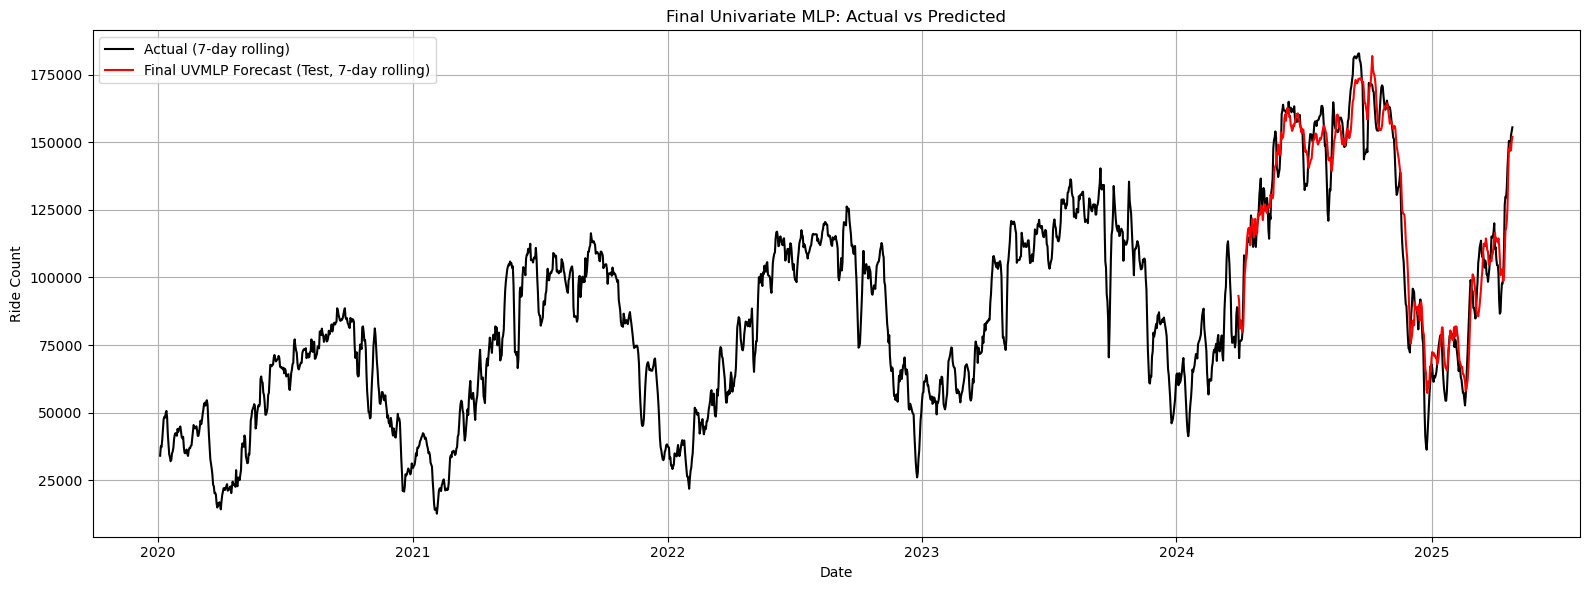

In [169]:
final_uvmlp_model.eval()
with torch.no_grad():
    y_final_uvmlp_pred_tensor = final_uvmlp_model(X_uvmlp_test_tensor)
y_final_uvmlp_pred = y_final_uvmlp_pred_tensor.numpy().flatten()

y_final_uvmlp_pred_rescaled = scaler_uvmlp_y.inverse_transform(y_final_uvmlp_pred.reshape(-1, 1)).flatten()
y_final_uvmlp_test_rescaled = scaler_uvmlp_y.inverse_transform(y_uvmlp_test_tensor.numpy()).flatten()

final_rmse = np.sqrt(mean_squared_error(y_final_uvmlp_test_rescaled, y_final_uvmlp_pred_rescaled))
final_mae = mean_absolute_error(y_final_uvmlp_test_rescaled, y_final_uvmlp_pred_rescaled)
final_r2 = r2_score(y_final_uvmlp_test_rescaled, y_final_uvmlp_pred_rescaled)

print("\n[Final Univariate MLP Evaluation (Best Params)]")
print(f"RMSE: {final_rmse:.2f}")
print(f"MAE: {final_mae:.2f}")
print(f"R²: {final_r2 * 100:.2f}%")

# Final plot
full_actual_smooth_final = ride_count_daily_uvmlp.rolling(7, center=True).mean()
index_test_final = ride_count_daily_uvmlp.index[-400:]
pred_smooth_final = pd.Series(y_final_uvmlp_pred_rescaled, index=index_test_final).rolling(7, center=True).mean()

plt.figure(figsize=(16, 6))
plt.plot(full_actual_smooth_final, label='Actual (7-day rolling)', color='black')
plt.plot(pred_smooth_final, label='Final UVMLP Forecast (Test, 7-day rolling)', color='red')
plt.title("Final Univariate MLP: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Ride Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [176]:
uvmlp_comp = {
    'MODEL': ['Univariate MLP (before optimization)', 'Univariate MLP (after optimization)'],
    'RMSE': [25738.35, 22194.64],
    'MAE': [18450.95, 16610.48],
    'R^2': ['62.47%', '72.09%']
}

df2 = pd.DataFrame(uvmlp_comp)
print(df2)

                                  MODEL      RMSE       MAE     R^2
0  Univariate MLP (before optimization)  25738.35  18450.95  62.47%
1   Univariate MLP (after optimization)  22194.64  16610.48  72.09%


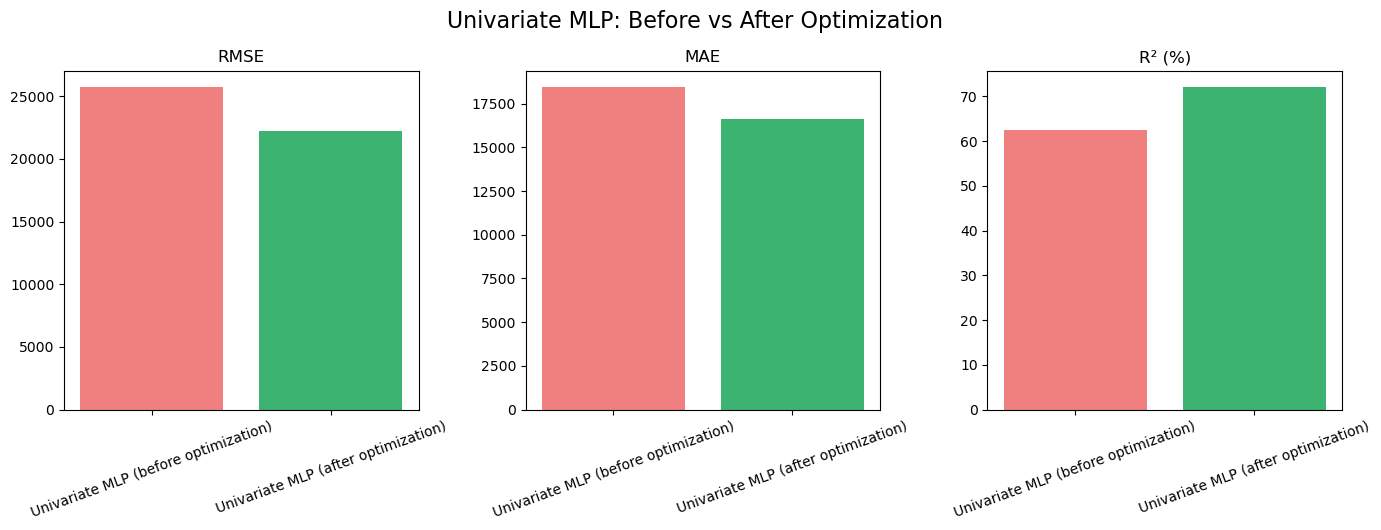

In [177]:
df2['R^2_float'] = df2['R^2'].str.replace('%', '').astype(float)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# RMSE
axes[0].bar(df2['MODEL'], df2['RMSE'], color=['lightcoral', 'mediumseagreen'])
axes[0].set_title('RMSE')
axes[0].tick_params(axis='x', rotation=20)

# MAE
axes[1].bar(df2['MODEL'], df2['MAE'], color=['lightcoral', 'mediumseagreen'])
axes[1].set_title('MAE')
axes[1].tick_params(axis='x', rotation=20)

# R²
axes[2].bar(df2['MODEL'], df2['R^2_float'], color=['lightcoral', 'mediumseagreen'])
axes[2].set_title('R² (%)')
axes[2].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.suptitle('Univariate MLP: Before vs After Optimization', y=1.05, fontsize=16)
plt.show()

### Observations

The best performing configurations:
- hidden_layer_1 = 128
- hidden_layer_2 = 32
- learning_rate = 0.005
- batch_size = 32

The architecture was likely the choice based on the grid search because it was able to strike a balance between complex understanding of relationships and generalization (to avoid overfitting). Furthermore, with the addition of a higher learning rate, the model possibly was able to converge better

Results
- RMSE: 22194.64
- MAE: 16610.48
- R²: 72.09%

As seen from these values as well as the plot describing the before and after optimization results, it can be said that the optimization was successful in extracting the highest amount of performance and gave an R^2 score of about 72% which is about 10% better than the original

## b. Multivariate MLP Using Bayesian Optimization

After confirming that the multivariate MLP performed strongly using default settings, the next step is to optimize its hyperparameters. The model already benefited from a richer input space that included weather and pattern features, but tuning the parameters will give us the understanding of the full capability of a multivariate MLP model

### Why Bayesian Optimization?
Unlike the univariate ase, the multivariate MLP has a larger architecture, more input features, and broader hyperparameter space. Exhaustively searching this space with grid search would be inefficient and computationally expensive. 

To handle, Baysesian optimization through Optuna was used. It was chosen because
- adapts based on previous trials
- more efficienct that grid search or random walk
- converges quickly on high preforming parameters

### Search Space Reasoning
hidden_layer_1: same reasoning as before: has the ability to capture both complexity and generalizability at the cost of possibly overfitting

hidden_layer_2: same reasoning as before: standard to lower the second layer but still provides regularization

learning_rate: Changed to a much smaller number than the previous model as with more features, giving large values can cause it to overfit easily.

dropout: added on in this model so that the model can prevent overfitting by randomly deactivating neurons during training

activation (ReLU, LeakyReLU, Tanh): Each of these activation functions have their own benefits such as reducing vanishing gradient, allowing it if input is less than zero, and allowing for negative values. Testing between the three gives the model to choose from the best option

weight_decay: Adds regularization to reduce overfitting by punishing large weights

In [69]:
def objective(trial):
    # Suggest hyperparameters
    hidden_1 = trial.suggest_categorical('hidden_layer_1', [64, 128, 192, 256])
    hidden_2 = trial.suggest_categorical('hidden_layer_2', [16, 32, 64, 96, 128])
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout', 0.0, 0.5)
    activation_name = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'Tanh'])
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)

    # Choose activation function
    if activation_name == 'ReLU':
        activation_fn = nn.ReLU()
    elif activation_name == 'LeakyReLU':
        activation_fn = nn.LeakyReLU()
    elif activation_name == 'Tanh':
        activation_fn = nn.Tanh()

    # Build the model
    model = nn.Sequential(
        nn.Linear(X_train_tensor_mlp.shape[1], hidden_1),
        activation_fn,
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_1, hidden_2),
        activation_fn,
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_2, 1)
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    # Training loop
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_tensor_mlp)
        loss = criterion(output, y_train_tensor_mlp)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_test_tensor_mlp).numpy()

    y_pred = scaler_y_mlp.inverse_transform(y_pred_scaled)
    y_true = scaler_y_mlp.inverse_transform(y_test_scaled_mlp)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse


In [70]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=True)  # Increase n_trials if you want

[I 2025-06-25 20:16:16,888] A new study created in memory with name: no-name-c86cd26f-6461-4625-baea-b73e9afdba19


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-25 20:16:18,212] Trial 0 finished with value: 17374.366180382127 and parameters: {'hidden_layer_1': 192, 'hidden_layer_2': 128, 'learning_rate': 0.0009503782616772591, 'dropout': 0.17579797290792243, 'activation': 'ReLU', 'weight_decay': 9.38950398280118e-05}. Best is trial 0 with value: 17374.366180382127.
[I 2025-06-25 20:16:19,164] Trial 1 finished with value: 16750.024741995076 and parameters: {'hidden_layer_1': 192, 'hidden_layer_2': 96, 'learning_rate': 0.0005440190779554356, 'dropout': 0.10622852924975018, 'activation': 'LeakyReLU', 'weight_decay': 1.5453424131393586e-06}. Best is trial 1 with value: 16750.024741995076.
[I 2025-06-25 20:16:19,969] Trial 2 finished with value: 17472.294208760803 and parameters: {'hidden_layer_1': 128, 'hidden_layer_2': 64, 'learning_rate': 0.0022029005805409246, 'dropout': 0.394555511607865, 'activation': 'ReLU', 'weight_decay': 8.223432881858172e-05}. Best is trial 1 with value: 16750.024741995076.
[I 2025-06-25 20:16:21,236] Trial 3 

In [71]:
print("Best hyperparameters:")
print(study.best_params)
print(f"Best RMSE: {study.best_value:.2f}")

Best hyperparameters:
{'hidden_layer_1': 256, 'hidden_layer_2': 64, 'learning_rate': 0.007893934745866542, 'dropout': 0.40149572859605953, 'activation': 'ReLU', 'weight_decay': 1.4610653982613857e-05}
Best RMSE: 14680.01


In [72]:
best_params = {
    'hidden_layer_1': 256,
    'hidden_layer_2': 64,
    'learning_rate': 0.007893934745866542,
    'dropout': 0.40149572859605953,
    'activation': 'ReLU',
    'weight_decay': 1.4610653982613857e-05
}

# Set activation function
if best_params['activation'] == 'ReLU':
    activation_fn = nn.ReLU()
elif best_params['activation'] == 'LeakyReLU':
    activation_fn = nn.LeakyReLU()
elif best_params['activation'] == 'Tanh':
    activation_fn = nn.Tanh()

In [73]:
# Define model
final_model_mlp = nn.Sequential(
    nn.Linear(X_train_tensor_mlp.shape[1], best_params['hidden_layer_1']),
    activation_fn,
    nn.Dropout(best_params['dropout']),
    nn.Linear(best_params['hidden_layer_1'], best_params['hidden_layer_2']),
    activation_fn,
    nn.Dropout(best_params['dropout']),
    nn.Linear(best_params['hidden_layer_2'], 1)
)

# Define optimizer and loss
optimizer_mlp_final = torch.optim.Adam(
    final_model_mlp.parameters(),
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)
criterion_mlp_final = nn.MSELoss()

In [74]:
epochs_final = 560
train_losses_final = []
test_losses_final = []

for epoch in range(epochs_final):
    final_model_mlp.train()
    optimizer_mlp_final.zero_grad()
    output = final_model_mlp(X_train_tensor_mlp)
    loss = criterion_mlp_final(output, y_train_tensor_mlp)
    loss.backward()
    optimizer_mlp_final.step()
    train_losses_final.append(loss.item())

    # Evaluate
    final_model_mlp.eval()
    with torch.no_grad():
        test_output = final_model_mlp(X_test_tensor_mlp)
        test_loss = criterion_mlp_final(test_output, y_test_tensor_mlp)
        test_losses_final.append(test_loss.item())

    if (epoch+1) % 10 == 0:
        print(f"[Epoch {epoch+1}] Train Loss: {loss.item():.4f} | Test Loss: {test_loss.item():.4f}")

[Epoch 10] Train Loss: 0.2366 | Test Loss: 0.4601
[Epoch 20] Train Loss: 0.1904 | Test Loss: 0.5210
[Epoch 30] Train Loss: 0.1562 | Test Loss: 0.3522
[Epoch 40] Train Loss: 0.1505 | Test Loss: 0.2521
[Epoch 50] Train Loss: 0.1359 | Test Loss: 0.2228
[Epoch 60] Train Loss: 0.1307 | Test Loss: 0.2543
[Epoch 70] Train Loss: 0.1249 | Test Loss: 0.2561
[Epoch 80] Train Loss: 0.1235 | Test Loss: 0.2437
[Epoch 90] Train Loss: 0.1138 | Test Loss: 0.2117
[Epoch 100] Train Loss: 0.1103 | Test Loss: 0.2546
[Epoch 110] Train Loss: 0.1130 | Test Loss: 0.1791
[Epoch 120] Train Loss: 0.1095 | Test Loss: 0.2356
[Epoch 130] Train Loss: 0.1055 | Test Loss: 0.1968
[Epoch 140] Train Loss: 0.1014 | Test Loss: 0.2049
[Epoch 150] Train Loss: 0.1025 | Test Loss: 0.2253
[Epoch 160] Train Loss: 0.1036 | Test Loss: 0.1818
[Epoch 170] Train Loss: 0.1014 | Test Loss: 0.2046
[Epoch 180] Train Loss: 0.0990 | Test Loss: 0.2074
[Epoch 190] Train Loss: 0.1038 | Test Loss: 0.2249
[Epoch 200] Train Loss: 0.0882 | Test Lo

In [75]:
final_model_mlp.eval()
with torch.no_grad():
    y_pred_scaled_final = final_model_mlp(X_test_tensor_mlp).numpy()

y_pred_final = scaler_y_mlp.inverse_transform(y_pred_scaled_final)
y_test_actual_final = scaler_y_mlp.inverse_transform(y_test_scaled_mlp)

In [76]:
final_rmse = np.sqrt(mean_squared_error(y_test_actual_final, y_pred_final))
final_mae = mean_absolute_error(y_test_actual_final, y_pred_final)
final_r2 = r2_score(y_test_actual_final, y_pred_final)

print("\n[Final Multivariate MLP Evaluation]")
print(f"RMSE: {final_rmse:.2f}")
print(f"MAE: {final_mae:.2f}")
print(f"R²: {final_r2 * 100:.2f}%")


[Final Multivariate MLP Evaluation]
RMSE: 13775.81
MAE: 10679.90
R²: 89.05%


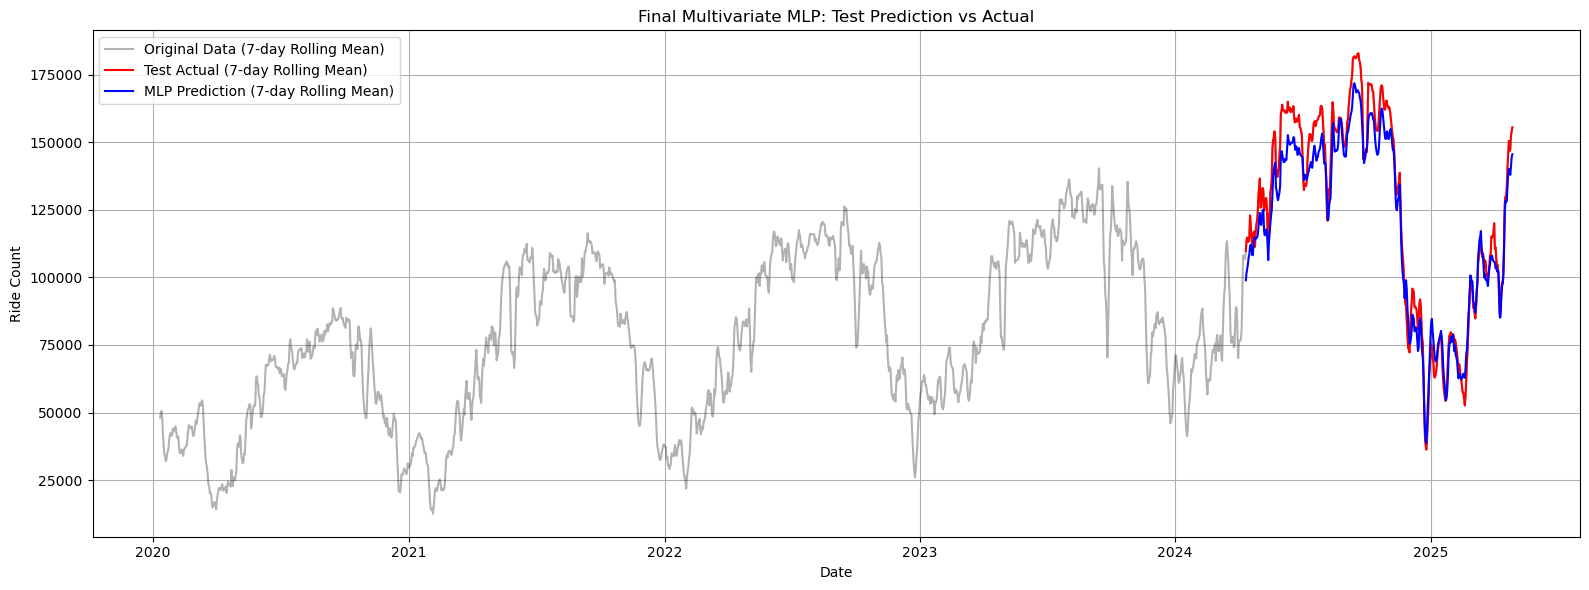

In [77]:
# Smooth actual + prediction
y_full_actual_smooth_final = y_mlp.rolling(window=7, center=True).mean()
y_test_actual_smooth_final = y_test_mlp.rolling(window=7, center=True).mean()
y_test_pred_smooth_final = pd.Series(y_pred_final.flatten(), index=y_test_mlp.index).rolling(window=7, center=True).mean()

# Plot
plt.figure(figsize=(16,6))
plt.plot(y_mlp.index, y_full_actual_smooth_final, label='Original Data (7-day Rolling Mean)', color='black', alpha=0.3)
plt.plot(y_test_mlp.index, y_test_actual_smooth_final, label='Test Actual (7-day Rolling Mean)', color='red')
plt.plot(y_test_mlp.index, y_test_pred_smooth_final, label='MLP Prediction (7-day Rolling Mean)', color='blue')
plt.xlabel('Date')
plt.ylabel('Ride Count')
plt.title('Final Multivariate MLP: Test Prediction vs Actual')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [78]:
mulvmlp_comp = {
    'MODEL': ['Multivariate MLP (before optimization)', 'Multivariate MLP (after optimization)'],
    'RMSE': [16618.77, 13775.81],
    'MAE': [13339.06, 10679.90],
    'R^2': ['84.063', '89.05%']
}

df2 = pd.DataFrame(mulvmlp_comp)
print(df2)

                                    MODEL      RMSE       MAE     R^2
0  Multivariate MLP (before optimization)  16618.77  13339.06  84.063
1   Multivariate MLP (after optimization)  13775.81  10679.90  89.05%


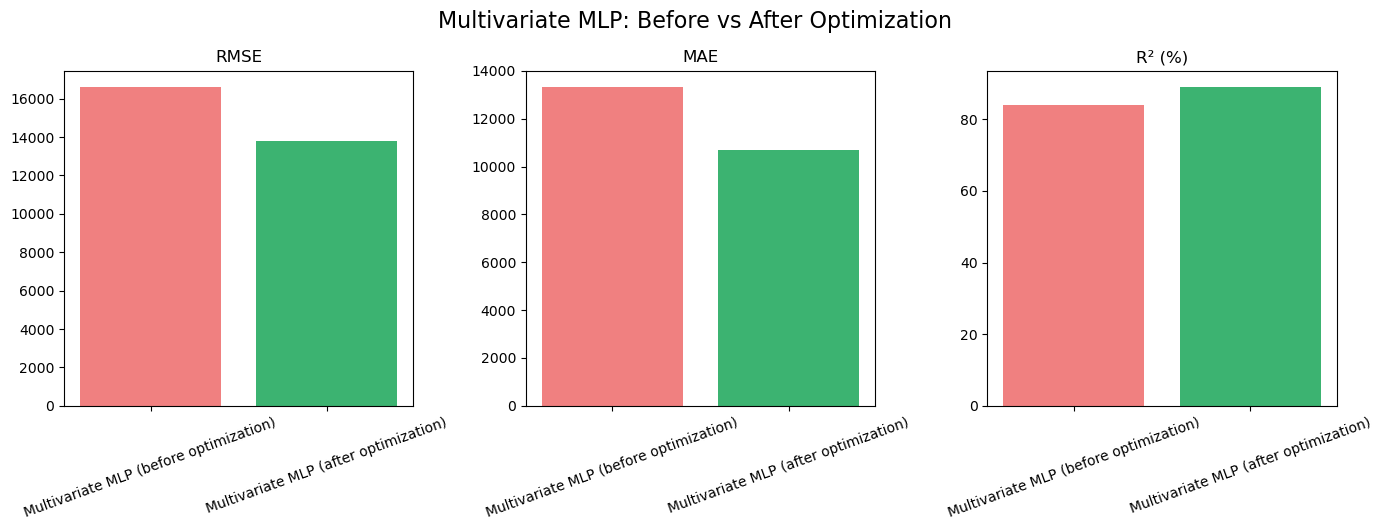

In [79]:
df2['R^2_float'] = df2['R^2'].str.replace('%', '').astype(float)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# RMSE
axes[0].bar(df2['MODEL'], df2['RMSE'], color=['lightcoral', 'mediumseagreen'])
axes[0].set_title('RMSE')
axes[0].tick_params(axis='x', rotation=20)

# MAE
axes[1].bar(df2['MODEL'], df2['MAE'], color=['lightcoral', 'mediumseagreen'])
axes[1].set_title('MAE')
axes[1].tick_params(axis='x', rotation=20)

# R²
axes[2].bar(df2['MODEL'], df2['R^2_float'], color=['lightcoral', 'mediumseagreen'])
axes[2].set_title('R² (%)')
axes[2].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.suptitle('Multivariate MLP: Before vs After Optimization', y=1.05, fontsize=16)
plt.show()

### Observations

Best Performing Configuration
- hidden_layer_1 = 256
- hidden_layer_2 = 64
- learning_rate ≈ 0.0079
- dropout ≈ 0.40
- activation = ReLU
- weight_decay ≈ 1.46e-5

This set of configurations tells us that the model benefited from a first layer that is able to capture complex relationships with a high learning rate. Additionally the use of ReLU most likely helped maintain gradients without vanishing or exploding during training.

Results
- RMSE: 13,775.81
- MAE: 10,679.90
- R²: 89.05%

Compared to the baseline multivariate MLP, as seen on the table and plot, the optimization let to a 17% reduction in RMSE and a 5% boost in R^2, confirming that the tuning process done improved both error reduction and variance explanation

## c. Multi-headed MLP Using Bayesian Optimization

Similar to part b. Multi-headed MLP preformed well with the standard parameters but to further imporve it, once again, bayesian optimization was used. 

In terms of why it was used and why the parameters were chosen as they were, please refer back to part b. as its the exact same reasoning for this model as well but with the added layer information for the exegenous variables

In [137]:
import optuna

def objective_mh(trial):
    # --- Hyperparameters ---
    hidden_lag_1 = trial.suggest_categorical('hidden_lag_1', [64, 128, 192])
    hidden_lag_2 = trial.suggest_categorical('hidden_lag_2', [32, 64, 96])

    hidden_exog_1 = trial.suggest_categorical('hidden_exog_1', [64, 128, 192])
    hidden_exog_2 = trial.suggest_categorical('hidden_exog_2', [32, 64, 96])

    hidden_combined = trial.suggest_categorical('hidden_combined', [32, 64, 96])

    lr = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    activation_name = trial.suggest_categorical('activation', ['ReLU', 'LeakyReLU', 'Tanh'])
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)

    # --- Activation ---
    if activation_name == 'ReLU':
        activation_fn = nn.ReLU()
    elif activation_name == 'LeakyReLU':
        activation_fn = nn.LeakyReLU()
    elif activation_name == 'Tanh':
        activation_fn = nn.Tanh()

    # --- Model ---
    class MultiHeadMLPOpt(nn.Module):
        def __init__(self, lag_input_size, exog_input_size):
            super(MultiHeadMLPOpt, self).__init__()
            self.lag_head = nn.Sequential(
                nn.Linear(lag_input_size, hidden_lag_1),
                activation_fn,
                nn.Dropout(dropout),
                nn.Linear(hidden_lag_1, hidden_lag_2),
                activation_fn,
                nn.Dropout(dropout)
            )
            self.exog_head = nn.Sequential(
                nn.Linear(exog_input_size, hidden_exog_1),
                activation_fn,
                nn.Dropout(dropout),
                nn.Linear(hidden_exog_1, hidden_exog_2),
                activation_fn,
                nn.Dropout(dropout)
            )
            self.combined = nn.Sequential(
                nn.Linear(hidden_lag_2 + hidden_exog_2, hidden_combined),
                activation_fn,
                nn.Dropout(dropout),
                nn.Linear(hidden_combined, 1)
            )

        def forward(self, x_lag, x_exog):
            h1 = self.lag_head(x_lag)
            h2 = self.exog_head(x_exog)
            combined = torch.cat((h1, h2), dim=1)
            return self.combined(combined)

    model = MultiHeadMLPOpt(lag_input_size=30, exog_input_size=X_exog_train_mh.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    # --- Training ---
    loader = DataLoader(mh_train_dataset, batch_size=32, shuffle=True)
    for epoch in range(100):  # Shortened for tuning phase
        model.train()
        for x_lag_b, x_exog_b, y_b in loader:
            optimizer.zero_grad()
            pred = model(x_lag_b, x_exog_b)
            loss = criterion(pred, y_b)
            loss.backward()
            optimizer.step()

    # --- Evaluation ---
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_lag_test_t_mh, X_exog_test_t_mh).numpy()
    y_pred = scaler_y_mh.inverse_transform(y_pred_scaled)
    y_true = scaler_y_mh.inverse_transform(y_test_mh)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

In [138]:
study_mh = optuna.create_study(direction='minimize')
study_mh.optimize(objective_mh, n_trials=200, show_progress_bar=True)

[I 2025-06-25 20:55:10,383] A new study created in memory with name: no-name-79f1aa80-9b92-44b8-98b4-6bc9ff2c04af


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-06-25 20:55:22,527] Trial 0 finished with value: 24586.225715290377 and parameters: {'hidden_lag_1': 128, 'hidden_lag_2': 64, 'hidden_exog_1': 64, 'hidden_exog_2': 96, 'hidden_combined': 64, 'learning_rate': 0.00024353099053359492, 'dropout': 0.37304281596169625, 'activation': 'ReLU', 'weight_decay': 0.0002065217842529048}. Best is trial 0 with value: 24586.225715290377.
[I 2025-06-25 20:55:33,453] Trial 1 finished with value: 24072.482942598177 and parameters: {'hidden_lag_1': 64, 'hidden_lag_2': 64, 'hidden_exog_1': 64, 'hidden_exog_2': 64, 'hidden_combined': 96, 'learning_rate': 0.001417427266125575, 'dropout': 0.3142459947839466, 'activation': 'ReLU', 'weight_decay': 0.00019576507399581347}. Best is trial 1 with value: 24072.482942598177.
[I 2025-06-25 20:55:45,547] Trial 2 finished with value: 24455.772622970013 and parameters: {'hidden_lag_1': 128, 'hidden_lag_2': 32, 'hidden_exog_1': 128, 'hidden_exog_2': 64, 'hidden_combined': 96, 'learning_rate': 0.0028136646364905773,

In [139]:
print("Best params:")
print(study_mh.best_params)
print(f"Best RMSE: {study_mh.best_value:.2f}")


Best params:
{'hidden_lag_1': 192, 'hidden_lag_2': 64, 'hidden_exog_1': 192, 'hidden_exog_2': 64, 'hidden_combined': 96, 'learning_rate': 0.0005984490035016844, 'dropout': 0.060875446739637955, 'activation': 'Tanh', 'weight_decay': 6.969871037198953e-05}
Best RMSE: 20731.17


In [140]:
# Activation
activation_name_mh = 'Tanh'
if activation_name_mh == 'ReLU':
    activation_fn_mh = nn.ReLU()
elif activation_name_mh == 'LeakyReLU':
    activation_fn_mh = nn.LeakyReLU()
elif activation_name_mh == 'Tanh':
    activation_fn_mh = nn.Tanh()

class FinalMultiHeadMLP(nn.Module):
    def __init__(self):
        super(FinalMultiHeadMLP, self).__init__()
        self.lag_head = nn.Sequential(
            nn.Linear(30, 192),
            activation_fn_mh,
            nn.Dropout(0.060875446739637955),
            nn.Linear(192, 64),
            activation_fn_mh,
            nn.Dropout(0.060875446739637955)
        )
        self.exog_head = nn.Sequential(
            nn.Linear(X_exog_train_mh.shape[1], 192),
            activation_fn_mh,
            nn.Dropout(0.060875446739637955),
            nn.Linear(192, 64),
            activation_fn_mh,
            nn.Dropout(0.060875446739637955)
        )
        self.combined = nn.Sequential(
            nn.Linear(64 + 64, 96),
            activation_fn_mh,
            nn.Dropout(0.060875446739637955),
            nn.Linear(96, 1)
        )

    def forward(self, x_lag, x_exog):
        h1 = self.lag_head(x_lag)
        h2 = self.exog_head(x_exog)
        combined = torch.cat((h1, h2), dim=1)
        return self.combined(combined)

In [141]:
final_model_mh = FinalMultiHeadMLP()
optimizer_mh = torch.optim.Adam(final_model_mh.parameters(), lr=0.003848036425713436, weight_decay=0.00021387573988441096)
criterion_mh = nn.MSELoss()

In [142]:
# Train loop
train_losses_mh = []
val_losses_mh = []
mh_train_loader = DataLoader(mh_train_dataset, batch_size=32, shuffle=True)

for epoch in range(560):
    final_model_mh.train()
    total_loss = 0
    for x_lag_b, x_exog_b, y_b in mh_train_loader:
        optimizer_mh.zero_grad()
        output = final_model_mh(x_lag_b, x_exog_b)
        loss = criterion_mh(output, y_b)
        loss.backward()
        optimizer_mh.step()
        total_loss += loss.item()
    
    train_losses_mh.append(total_loss / len(mh_train_loader))

    final_model_mh.eval()
    with torch.no_grad():
        val_pred_mh = final_model_mh(X_lag_test_t_mh, X_exog_test_t_mh)
        val_loss_mh = criterion_mh(val_pred_mh, y_test_t_mh).item()
        val_losses_mh.append(val_loss_mh)

    if (epoch + 1) % 10 == 0:
        print(f"[Epoch {epoch+1}] Train Loss: {train_losses_mh[-1]:.6f} | Val Loss: {val_loss_mh:.4f}")

[Epoch 10] Train Loss: 0.013016 | Val Loss: 0.0348
[Epoch 20] Train Loss: 0.013213 | Val Loss: 0.0501
[Epoch 30] Train Loss: 0.013672 | Val Loss: 0.0197
[Epoch 40] Train Loss: 0.011662 | Val Loss: 0.0242
[Epoch 50] Train Loss: 0.012250 | Val Loss: 0.0258
[Epoch 60] Train Loss: 0.012024 | Val Loss: 0.0301
[Epoch 70] Train Loss: 0.011706 | Val Loss: 0.0181
[Epoch 80] Train Loss: 0.011818 | Val Loss: 0.0228
[Epoch 90] Train Loss: 0.012254 | Val Loss: 0.0241
[Epoch 100] Train Loss: 0.011673 | Val Loss: 0.0547
[Epoch 110] Train Loss: 0.011374 | Val Loss: 0.0185
[Epoch 120] Train Loss: 0.011396 | Val Loss: 0.0300
[Epoch 130] Train Loss: 0.011658 | Val Loss: 0.0245
[Epoch 140] Train Loss: 0.011627 | Val Loss: 0.0373
[Epoch 150] Train Loss: 0.011415 | Val Loss: 0.0359
[Epoch 160] Train Loss: 0.011283 | Val Loss: 0.0334
[Epoch 170] Train Loss: 0.011858 | Val Loss: 0.0257
[Epoch 180] Train Loss: 0.011608 | Val Loss: 0.0296
[Epoch 190] Train Loss: 0.011786 | Val Loss: 0.0209
[Epoch 200] Train Los

In [143]:
final_model_mh.eval()
with torch.no_grad():
    y_pred_scaled_mh = final_model_mh(X_lag_test_t_mh, X_exog_test_t_mh).numpy()

y_pred_mh = scaler_y_mh.inverse_transform(y_pred_scaled_mh).flatten()
y_test_orig_mh = scaler_y_mh.inverse_transform(y_test_mh).flatten()

In [144]:
rmse_mh = np.sqrt(mean_squared_error(y_test_orig_mh, y_pred_mh))
mae_mh = mean_absolute_error(y_test_orig_mh, y_pred_mh)
r2_mh = r2_score(y_test_orig_mh, y_pred_mh)

print("\n[Final Multi-Headed MLP Evaluation]")
print(f"RMSE: {rmse_mh:.2f}")
print(f"MAE: {mae_mh:.2f}")
print(f"R²: {r2_mh * 100:.2f}%")


[Final Multi-Headed MLP Evaluation]
RMSE: 28714.49
MAE: 24303.89
R²: 53.29%


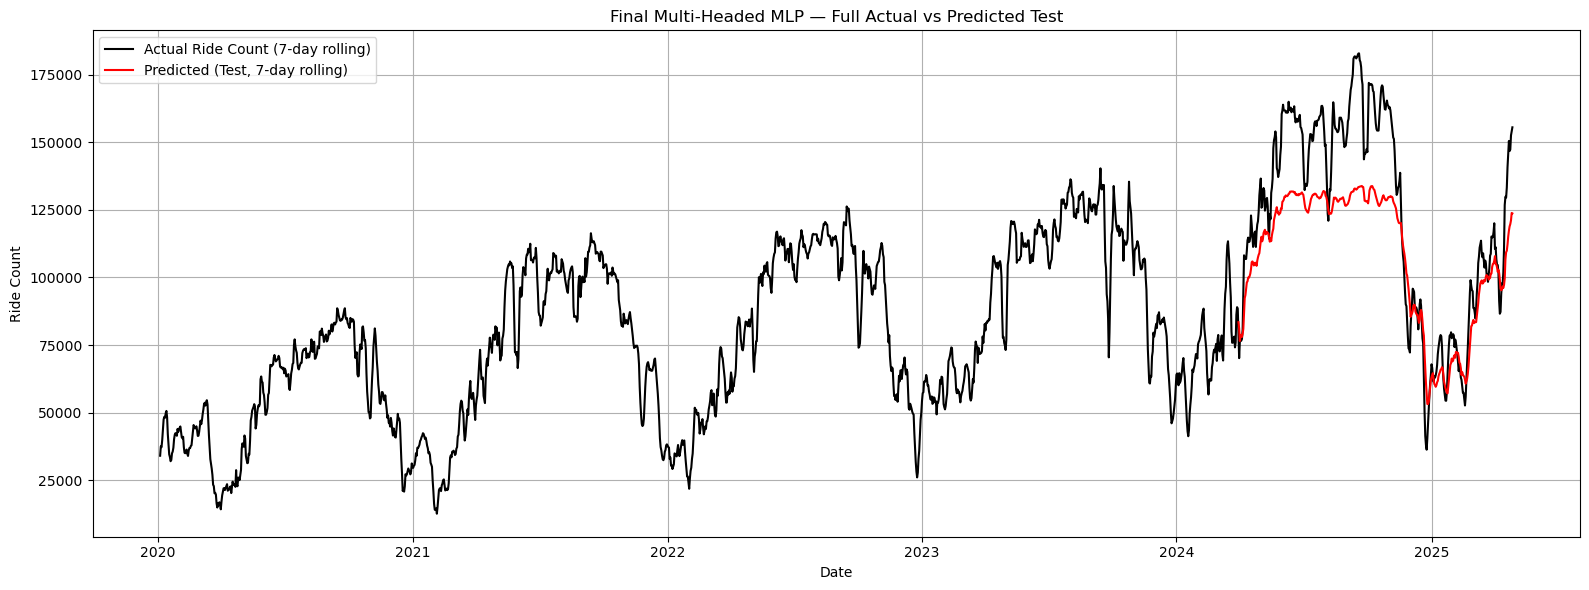

In [145]:
# Actual full series (smoothed)
ride_count_smooth_mh = mh_daily_df['ride_count'].rolling(7, center=True).mean()

# Predicted test segment (smoothed)
index_test_mh = mh_daily_df.index[-400:]
pred_series_mh = pd.Series(y_pred_mh, index=index_test_mh)
pred_smooth_mh = pred_series_mh.rolling(7, center=True).mean()

# Plot actual full range with predicted test overlay
plt.figure(figsize=(16, 6))
plt.plot(ride_count_smooth_mh, label='Actual Ride Count (7-day rolling)', color='black')
plt.plot(pred_smooth_mh, label='Predicted (Test, 7-day rolling)', color='red')
plt.title("Final Multi-Headed MLP — Full Actual vs Predicted Test")
plt.xlabel("Date")
plt.ylabel("Ride Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [146]:
mulhmlp_comp = {
    'MODEL': ['Multi-headed MLP (before optimization)', 'Multiv-headed MLP (after optimization)'],
    'RMSE': [24066.54, 28714.49],
    'MAE': [18482.95, 24303.89],
    'R^2': ['67.19%', '53.29%']
}

df3 = pd.DataFrame(mulhmlp_comp)
print(df3)

                                    MODEL      RMSE       MAE     R^2
0  Multi-headed MLP (before optimization)  24066.54  18482.95  67.19%
1  Multiv-headed MLP (after optimization)  28714.49  24303.89  53.29%


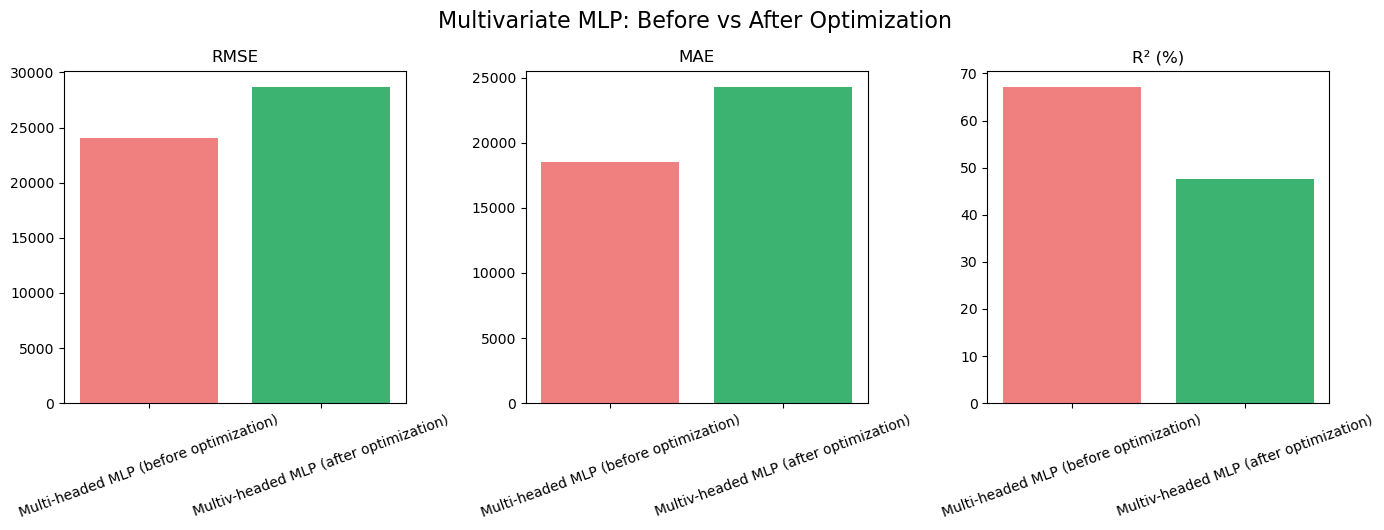

In [147]:
df3['R^2_float'] = df2['R^2'].str.replace('%', '').astype(float)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# RMSE
axes[0].bar(df2['MODEL'], df3['RMSE'], color=['lightcoral', 'mediumseagreen'])
axes[0].set_title('RMSE')
axes[0].tick_params(axis='x', rotation=20)

# MAE
axes[1].bar(df2['MODEL'], df3['MAE'], color=['lightcoral', 'mediumseagreen'])
axes[1].set_title('MAE')
axes[1].tick_params(axis='x', rotation=20)

# R²
axes[2].bar(df2['MODEL'], df3['R^2_float'], color=['lightcoral', 'mediumseagreen'])
axes[2].set_title('R² (%)')
axes[2].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.suptitle('Multivariate MLP: Before vs After Optimization', y=1.05, fontsize=16)
plt.show()

### Observations

Best Performing Configuration
- hidden_lag = 192
- hidden_lag = 64
- 'hidden_exog_1': 192
- 'hidden_exog_2': 64
- 'hidden_combined': 96
- 'learning_rate': 0.0005984490035016844
- 'dropout': 0.060875446739637955
- activation': 'Tanh'
- 'weight_decay': 6.969871037198953e-05

Both heads for the lags and the external variables are symmetric, which likely helped balance learning capacity for both of them.
The Tanh activation function may have helped capture smoother relationships, which is especially useful when combining different data types/sets
And lastly, the low learning rate dropout suggests that the model required subtle, fine-tuned adjustments rather than aggressive which shows this model may have been prone to overfitting

Results
- RMSE: 28714.49
- MAE: 24303.89
- R²: 53.29%

Interestingly, compared to the original model, the optimized version did somewhat worse. This may be to many different factors such as not enough loops (computational constraint), or a unlucky intially randomized search space.

# 32. Discussion & Future Work

The forecasting task for NYC CitiBike demand combined both traditional time series models and advanced neural network architectures after going through deep analysis through seasonal plots, STL decomposition, and correlation with weather variables. Among all the models implemented, the multivariate MLP performed the best. This showes that the model effectively captured the relationship between weather features and bike demand, with even more gains after hypterparameter optimization. 

The most interesting part about this analysis was the relationship between the weather variables and the bike data itself. Across most of the models, when it went from a univariate version to a multivariate or exegeous versions (for SARIMAX ARIMAX), the model most of the time preformed much better. This highlights the fact that some datasets, although cannot be seen at face value, can have much more deepers meanings and relationships across variables and choosing the correct ones with the correct architecture can significantly improve how the model performs. 

### Future Work

In terms of future work there are several aspects that would improve this analysis process

1. Improve LSTM Architecture: The LSTM model did not perform optimally. Future work should include investigating alternative configurations such as attension mechanims or hybrid versions such as LSTM-CNN to capture even more patterns within the data
2. Incorporate more features: Including additional variables such as holidays, public transit information, and even location based data (which was included in the original data but was out of scope), can be used to get further information about this data as get more interesting insights
3. As mentioned before, my biggest interest in terms of how this project can be improved is combining multiple models. for example combining ARIMA, MLP, and a CNN may result in more robust predictions. They can use their strengths to their advantage and models may also fill in the negatives of other models which overall, can improve performance of the model (within reason given 